---
---

### Decoders structure experiments aimed at deciding which correective decoder architecture and approach to take 

This notebook contains various expeiments run on surfae, slices, pointwise data to understand the second decoder behaviour. The notebook is based on VAE-GRU-VAE modlues in the pipeline given the results form temporal analysis. 

---
---

In [1]:
# Set Keras 3 backend to PyTorch and enable CUDA
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
keras.config.set_backend("torch")

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Keras backend:", keras.backend.backend())
print("PyTorch CUDA available:", torch.cuda.is_available())
print("Selected device:", device)

Keras backend: torch
PyTorch CUDA available: True
Selected device: cuda


In [2]:

import sys
sys.path.append(os.path.abspath("../src"))

from data.loader import load_and_clean_raw_dataset

# --- Load raw dataset
df = load_and_clean_raw_dataset("../data/vol_tensor_dataset.csv")

# --- Global config
LOOKBACK = 20
BATCH_SIZE = 32
LATENT_DIM = 12
SURFACE_SHAPE = (11, 10)
FEATURE_DIM = LOOKBACK * (11 * 10 + 1 + 32)

TARGET_DATE = "2025-05-21"
TARGET_STRIKE = 1.0
TARGET_TAU = 1.0

USE_PREPROCESSED_INPUTS = False


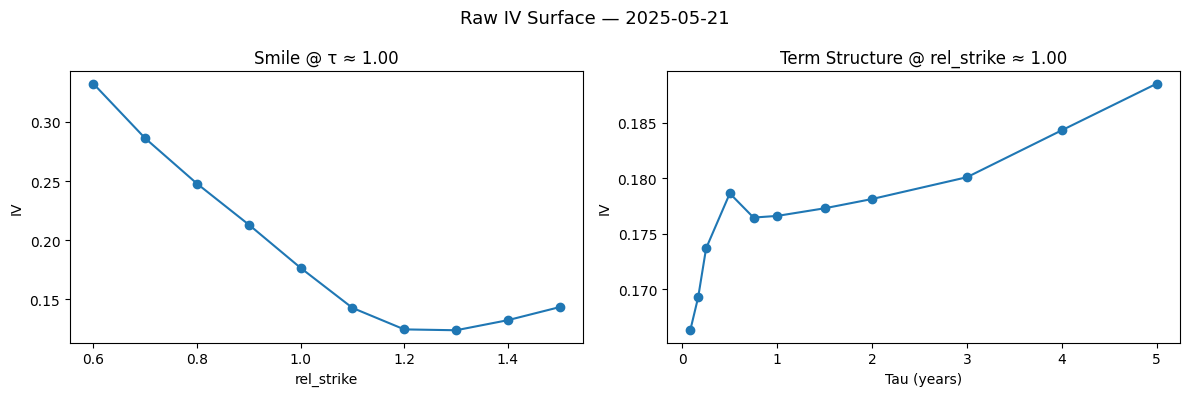

In [3]:

from data.loader import load_and_clean_raw_dataset

df = load_and_clean_raw_dataset("../data/vol_tensor_dataset.csv")


from utils.plotting import plot_raw_iv_slice

plot_raw_iv_slice(df, target_date=TARGET_DATE, target_strike=TARGET_STRIKE, target_tau=TARGET_TAU,)



In [4]:
from data.dataset_builder import build_full_surface_feature_df

# Load enriched surface + features
df_all = build_full_surface_feature_df("../data/vol_tensor_dataset.csv")

# Identify IV and feature columns
iv_cols = [c for c in df_all.columns if c.startswith("IV_")]
feat_cols = [c for c in df_all.columns if not c.startswith("IV_")]
df_all = df_all.dropna(subset=feat_cols)

print("Final DataFrame shape:", df_all.shape)
print("Surface columns:", len(iv_cols), "| Feature columns:", len(feat_cols))
print("IV column sample:", iv_cols[:5])
print("Feature column sample:", feat_cols[:5])


Final DataFrame shape: (1265, 136)
Surface columns: 110 | Feature columns: 26
IV column sample: ['IV_1m_0.60', 'IV_1m_0.70', 'IV_1m_0.80', 'IV_1m_0.90', 'IV_1m_1.00']
Feature column sample: ['log_return', 'log_return_ma20', 'log_return_z20', 'realized_vol_5d', 'realized_vol_5d_ma20']


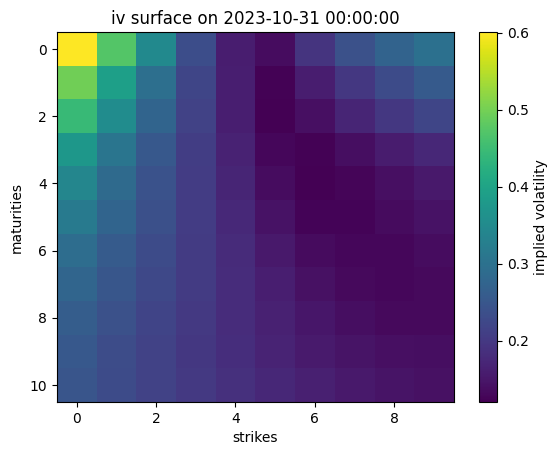


iv surface table on 2023-10-31 00:00:00


strike       0.6     0.7     0.8     0.9     1.0     1.1     1.2     1.3  \
maturity                                                                   
18m       0.6005  0.4731  0.3476  0.2351  0.1591  0.1371  0.1933  0.2396   
1m        0.4966  0.3922  0.2958  0.2210  0.1608  0.1244  0.1588  0.1981   
1y        0.4431  0.3535  0.2750  0.2148  0.1604  0.1220  0.1399  0.1699   
2m        0.3751  0.3078  0.2530  0.2087  0.1667  0.1283  0.1230  0.1384   
2y        0.3402  0.2863  0.2425  0.2063  0.1712  0.1364  0.1208  0.1271   
3m        0.3190  0.2745  0.2377  0.2065  0.1755  0.1446  0.1261  0.1257   
3y        0.2922  0.2580  0.2296  0.2049  0.1795  0.1542  0.1357  0.1283   
4y        0.2779  0.2490  0.2249  0.2042  0.1823  0.1603  0.1427  0.1324   
5y        0.2623  0.2391  0.2191  0.2009  0.1826  0.1649  0.1499  0.1390   
6m        0.2523  0.2330  0.2155  0.1989  0.1828  0.1677  0.1551  0.1457   
9m        0.2476  0.2306  0.2151  0.2005  0.1864  0.1733  0.1621  0.1531   

strike       1.4     1.5  
maturity                  
18m       0.2727  0.2974  
1m        0.2305  0.2560  
1y        0.1977  0.2211  
2m        0.1569  0.1749  
2y        0.1400  0.1539  
3m        0.1341  0.1447  
3y        0.1301  0.1362  
4y        0.1299  0.1324  
5y        0.1333  0.1322  
6m        0.1402  0.1381  
9m        0.1467  0.1430

In [5]:
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd

# pick random date
ix = np.random.randint(len(df_all))
date = df_all.index[ix]

# parse shape from iv column names
maturities = sorted(set(re.search(r"IV_(.*?)_", c).group(1) for c in iv_cols))
strikes = sorted(set(float(re.search(r"_(\d\.\d+)", c).group(1)) for c in iv_cols))

# extract and reshape surface
surface_values = df_all.iloc[ix][iv_cols].values.reshape(len(maturities), len(strikes))

# plot
plt.imshow(surface_values, cmap="viridis", aspect="auto")
plt.title(f"iv surface on {date}")
plt.xlabel("strikes")
plt.ylabel("maturities")
plt.colorbar(label="implied volatility")
plt.show()

# display surface table
surface_df = pd.DataFrame(surface_values, index=maturities, columns=strikes)
surface_df.index.name = "maturity"
surface_df.columns.name = "strike"

print(f"\niv surface table on {date}")
display(surface_df.round(4))

In [6]:
from data.tensor_builder import prepare_surface_and_feature_tensors
from keras import ops

# build tensors from cleaned dataframes
tensors, X_feat_tensor, df_feat = prepare_surface_and_feature_tensors(
   df_all=df_all,
   df_raw=df,  # original raw dataframe is named df
   feat_cols=feat_cols,
   monthly_interpolation=False
)

# print tensor shapes
print("tensors built:")
for k, v in tensors.items():
   try:
       print(f"  • {k:20s}: {ops.shape(v)}")
   except Exception:
       print(f"  • {k:20s}: {type(v)}")

print("\nfeature tensor:", ops.convert_to_numpy(X_feat_tensor).shape)
print("feature dataframe:", df_feat.shape)

tensors built:
  • date_tensor         : (1258,)
  • spot_tensor         : (1258,)
  • curve_tensor        : (1258, 32)
  • surface_tensor      : (1258, 11, 10, 6)
  • ssvi_tensor         : (1258, 11, 10, 3)
  • heston_tensor       : (1258, 11, 5)
  • strike_tensor       : (10,)
  • abs_strike_tensor   : (1258, 10)
  • dates               : <class 'list'>
  • maturities          : <class 'list'>
  • taus                : <class 'list'>
  • rel_strikes         : <class 'list'>
  • date_index          : <class 'dict'>
  • maturity_to_tau     : <class 'dict'>
  • iv_diff_tensor      : (1258, 11, 10, 7)

feature tensor: (1258, 136)
feature dataframe: (1258, 26)


pca-var rmse_σ: 0.0166


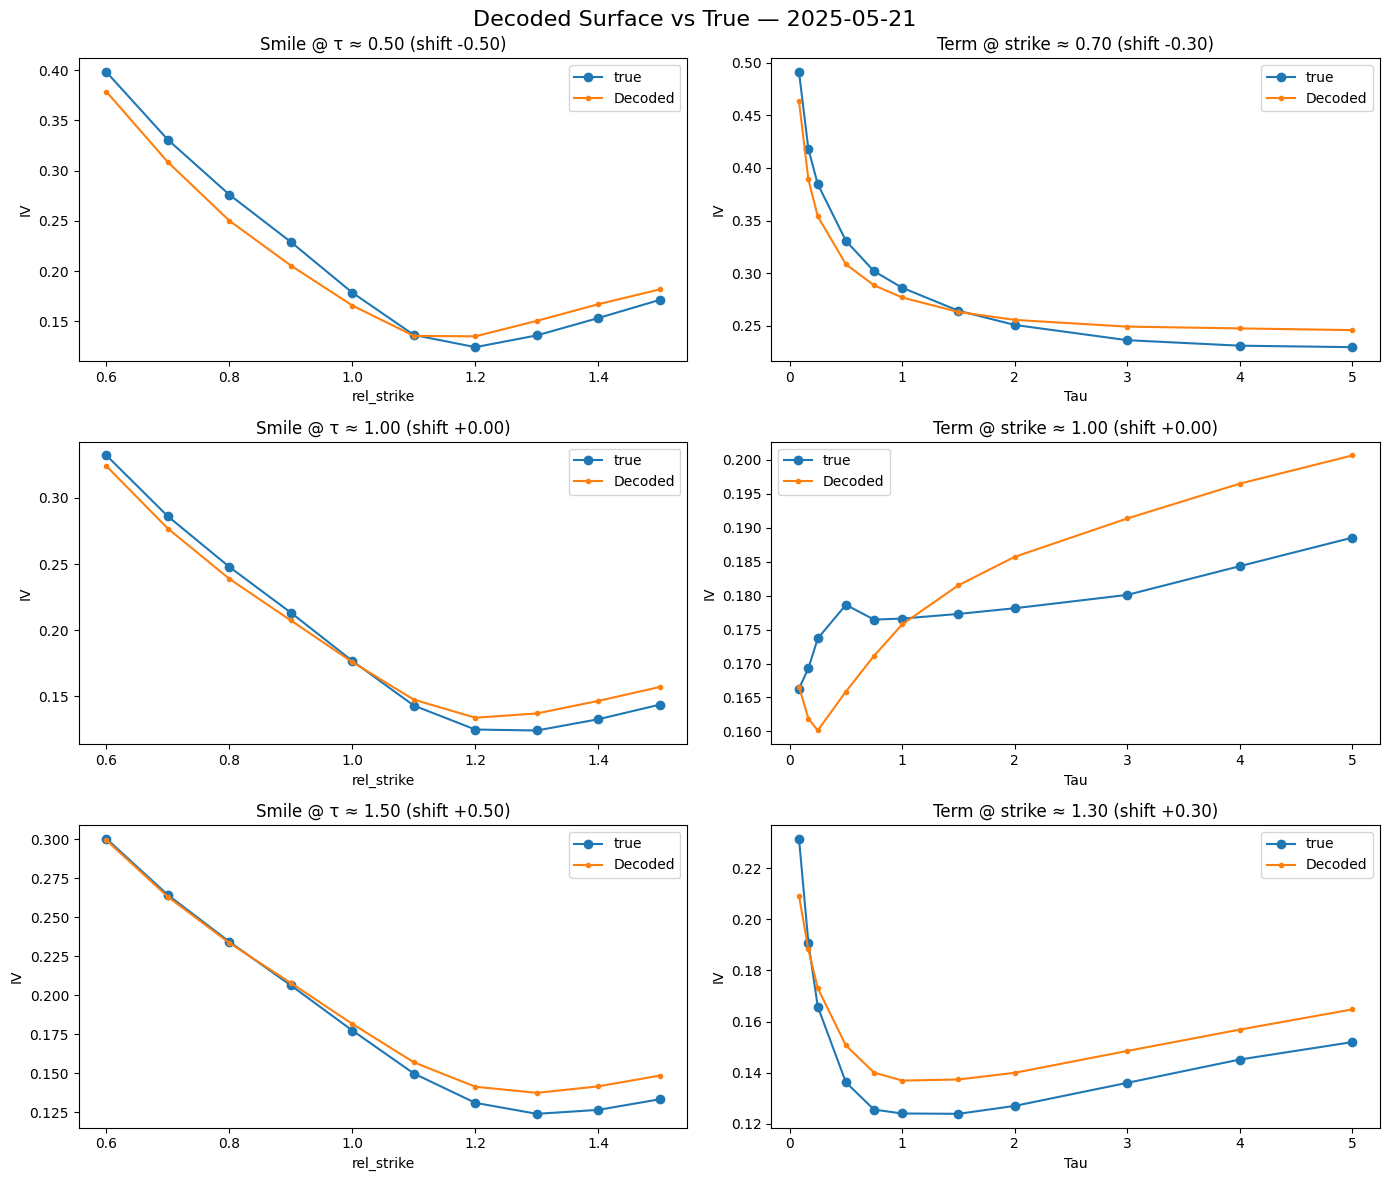

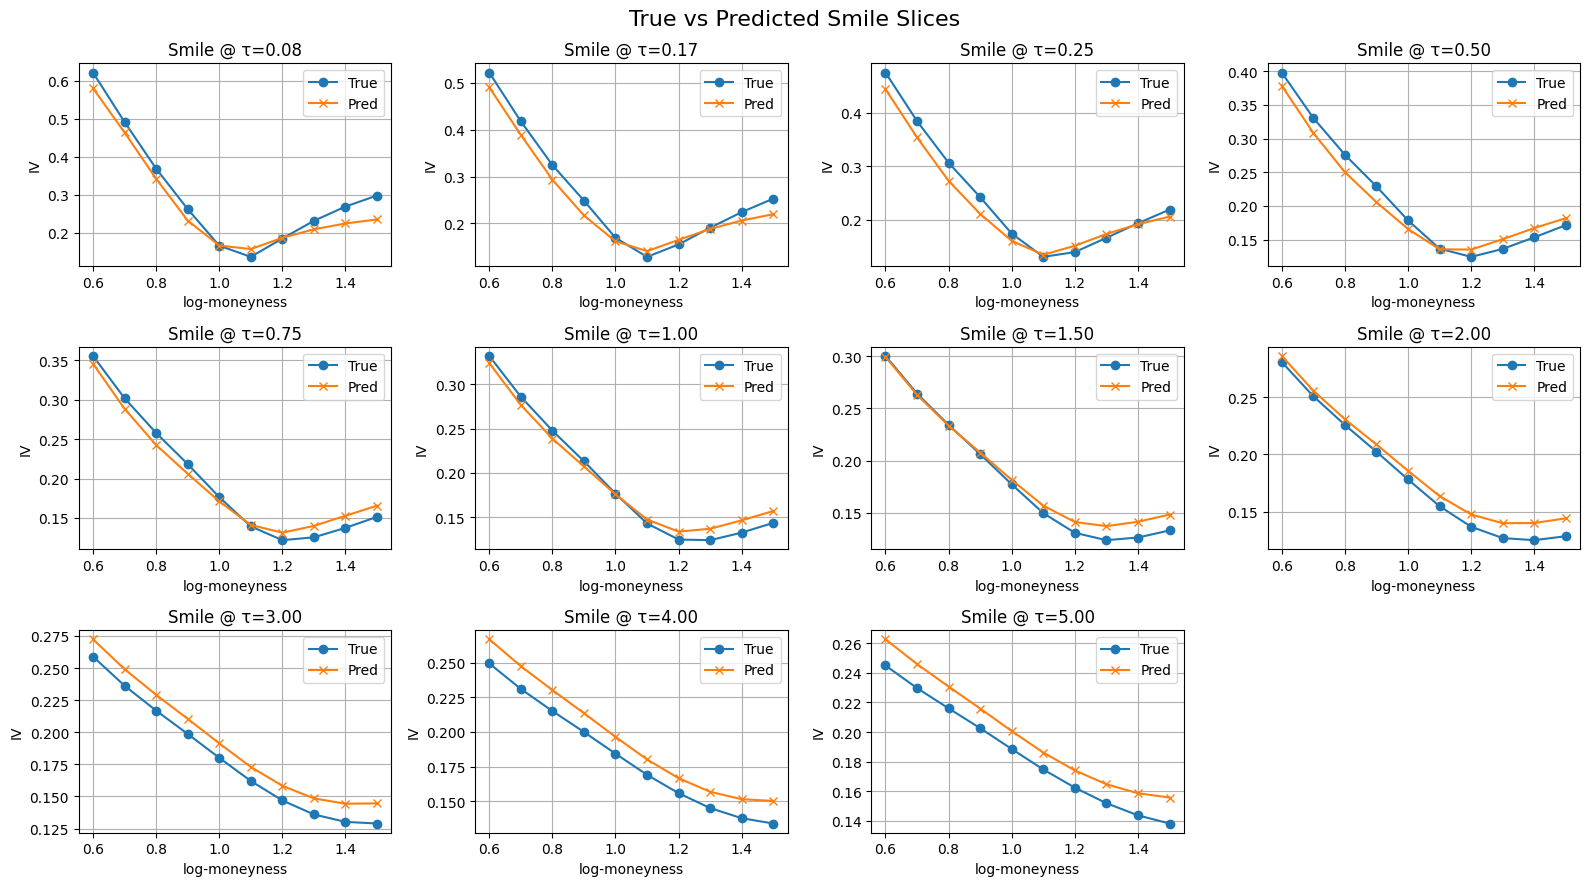

In [7]:
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR
from sklearn.metrics import root_mean_squared_error
import numpy as np

# extract surface tensor (σ) and flatten to (T, M*K)
iv_surface = ops.convert_to_numpy(tensors["surface_tensor"])[..., -1]  # shape (T, M, K)
T, M, K = iv_surface.shape
X_surface_flat = iv_surface.reshape(T, M * K).astype(np.float64)

# align with features
feature_index = df_feat.index.intersection(df_all.index)
X_df = df_all.loc[feature_index, iv_cols]
F = df_feat.loc[feature_index]
X_grid = X_df.values.astype(np.float64)
F_aligned = F.values.astype(np.float64)

# demean surfaces for pca
X_mean = X_grid.mean(axis=1, keepdims=True)
X_demeaned = X_grid - X_mean

# fit pca on demeaned surfaces
pca_model = PCA(n_components=LATENT_DIM)
Z_all_pca = pca_model.fit_transform(X_demeaned)
Z_aug_pca = np.concatenate([Z_all_pca, F_aligned], axis=1)  # augment with features

# train/test split
T_total = len(Z_aug_pca)
T_train = int(0.7 * T_total)
Z_train = Z_aug_pca[:T_train]
Z_test = Z_aug_pca[T_train:]
Z_train_pure = Z_all_pca[:T_train]

# var on augmented latent space
var_model = VAR(Z_train)
var_result = var_model.fit(maxlags=5)
Z_forecast_pca = var_result.forecast(Z_train[-var_result.k_ar:], steps=len(Z_test))
Z_forecast_pure = Z_forecast_pca[:, :LATENT_DIM]  # extract latent part only

# reconstruct iv surfaces
X_recon_demeaned = pca_model.inverse_transform(Z_forecast_pure)
X_mean_forecast = X_mean[T_train:T_train + len(X_recon_demeaned)]
X_pred_pca = X_recon_demeaned + X_mean_forecast  # add back mean
X_true_pca = X_grid[T_train:T_train + len(X_pred_pca)]

# compute rmse
rmse_pca = root_mean_squared_error(X_true_pca, X_pred_pca)
print(f"pca-var rmse_σ: {rmse_pca:.4f}")

# reshape to (T_test, M, K)
X_true_pca = X_true_pca.reshape(-1, M, K)
X_pred_pca = X_pred_pca.reshape(-1, M, K)

from utils.plotting import plot_iv_slices_shifts, plot_smile_slices_comparison

# last surface for plotting
true_surface_t = X_true_pca[-1]
recon_surface_t = X_pred_pca[-1]

plot_iv_slices_shifts(
   true_surface=true_surface_t,
   decoded_surface=recon_surface_t,
   taus=tensors["taus"],
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   decoded_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
)

plot_smile_slices_comparison(
   true_surface=true_surface_t,
   pred_surface=recon_surface_t,
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   taus=tensors["taus"],
)

In [8]:
import importlib
import data.dataset
importlib.reload(data.dataset)

from data.tensor_builder import split_time_series_indices, slice_tensors
from data.dataset import FeatureToLatentSequenceDataset
from keras import ops
import pandas as pd

# split time indices
T = tensors["surface_tensor"].shape[0]
train_idx, val_idx, test_idx = split_time_series_indices(T)

train = slice_tensors(tensors, train_idx)
val   = slice_tensors(tensors, val_idx)
test  = slice_tensors(tensors, test_idx)

LOOKBACK = 20
BATCH_SIZE = 32

# datasets with global index tracking
train_dataset = FeatureToLatentSequenceDataset(
   surface_tensor=train["surface_tensor"],
   feature_tensor=X_feat_tensor[train_idx],
   lookback=LOOKBACK,
   batch_size=BATCH_SIZE,
   global_indices=train_idx
)

val_dataset = FeatureToLatentSequenceDataset(
   surface_tensor=val["surface_tensor"],
   feature_tensor=X_feat_tensor[val_idx],
   lookback=LOOKBACK,
   batch_size=BATCH_SIZE,
   global_indices=val_idx
)

test_dataset = FeatureToLatentSequenceDataset(
   surface_tensor=test["surface_tensor"],
   feature_tensor=X_feat_tensor[test_idx],
   lookback=LOOKBACK,
   batch_size=BATCH_SIZE,
   global_indices=test_idx
)

# inspect one batch to confirm structure
sample = next(iter(train_dataset))

print("batch from train_dataset")
print("type:", type(sample))
print("len:", len(sample))

x, y = sample
print("\ninput tuple (x):", type(x), "length:", len(x))
print("  x[0] (surf_seq) shape:", x[0].shape)
print("  x[1] (feat_seq) shape:", x[1].shape)

print("\ntarget (y):", type(y), "shape:", y.shape)

# global diagnostics
M, K = tensors["surface_tensor"].shape[1:3]
flat_len = M * K

print(f"\ndataset shapes and diagnostics:")
print(f"  - train_dataset batches   : {len(train_dataset)}")
print(f"  - val_dataset batches     : {len(val_dataset)}")
print(f"  - test_dataset batches    : {len(test_dataset)}")
print(f"  - iv surface dim (m, k)   : ({M}, {K})")

# check target date location
target_date = pd.Timestamp("2025-05-21")
idx = np.where(tensors["date_tensor"] == target_date)[0][0]
print("\ndate check")
print("target global index:", idx)
print("in test?", idx in test_dataset.global_indices)
print("train:", train_idx[[0, -1]])
print("val:", val_idx[[0, -1]])
print("test:", test_idx[[0, -1]])

batch from train_dataset
type: <class 'tuple'>
len: 2

input tuple (x): <class 'tuple'> length: 2
  x[0] (surf_seq) shape: torch.Size([32, 20, 11, 10, 6])
  x[1] (feat_seq) shape: torch.Size([32, 20, 136])

target (y): <class 'torch.Tensor'> shape: torch.Size([32, 11, 10, 6])

dataset shapes and diagnostics:
  - train_dataset batches   : 26
  - val_dataset batches     : 5
  - test_dataset batches    : 5
  - iv surface dim (m, k)   : (11, 10)

date check
target global index: 1257
in test? True
train: [  0 879]
val: [ 880 1068]
test: [1069 1257]


In [9]:
from keras.models import load_model
from models.vae_mle import sample_z
from models.lstm import EncodedLatentSequence
from models.gru import GRUForecasterAugmented
from keras import ops
import numpy as np

# load trained vae encoder and patch predict to return z_sample
encoder = load_model(
   "saved_models/vae_mle/vae_mle_encoder.keras",
   custom_objects={"sample_z": sample_z}
)
# override predict to return sampled z instead of full tuple
encoder.predict = lambda x, **kwargs: encoder(x, training=False)[0]

# use full dataset for gru input
full_dataset = FeatureToLatentSequenceDataset(
   surface_tensor=tensors["surface_tensor"],
   feature_tensor=X_feat_tensor,
   lookback=LOOKBACK,
   batch_size=BATCH_SIZE,
   global_indices=np.arange(T)
)
gru_input_gen = EncodedLatentSequence(full_dataset, encoder)

# load gru forecaster model
gru_model = load_model(
   "saved_models/gru/gru_model_vae.keras",
   custom_objects={"GRUForecasterAugmented": GRUForecasterAugmented}
)

# forecast z(t+1) from gru
Z_forecast_vae = gru_model.predict(gru_input_gen, verbose=0)

# optional demeaning of forecasted latents
apply_demeaning = False # we dont want to demean the latents doesnt work 
z_mean = ops.convert_to_numpy(ops.mean(Z_forecast_vae, axis=0, keepdims=True)) if apply_demeaning else 0.0
Z_forecast_demeaned = Z_forecast_vae - z_mean if apply_demeaning else Z_forecast_vae

# align corresponding surface slices
X_surface_all = ops.convert_to_numpy(tensors["surface_tensor"][..., -1].reshape(T, -1))
idx_eval = ops.convert_to_numpy(full_dataset.global_indices)[-len(Z_forecast_demeaned):]
Y_surface_flat = X_surface_all[idx_eval]

# final decoder input/output
Z_decoder = Z_forecast_demeaned  # forecasted latent codes
Y_decoder = Y_surface_flat       # ground truth surfaces

print(f"decoder inputs: Z_decoder shape {Z_decoder.shape}, Y_decoder shape {Y_decoder.shape}")

decoder inputs: Z_decoder shape (1216, 12), Y_decoder shape (1216, 110)


Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 0.0591 - val_loss: 0.0250 - learning_rate: 1.0000e-04
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0219 - val_loss: 0.0271 - learning_rate: 1.0000e-04
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0282 - val_loss: 0.0134 - learning_rate: 1.0000e-04
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0201 - val_loss: 0.0277 - learning_rate: 1.0000e-04
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0349 - val_loss: 0.0272 - learning_rate: 1.0000e-04
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0308 - val_loss: 0.0170 - learning_rate: 1.0000e-04
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0177 - val_loss: 0.0138 - learning_rate: 1.0000e-04
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0139 - val_loss: 0.0096 - learning_rate: 1.0000e-04
Epoch 9/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - val_loss: 0.0067 - learni

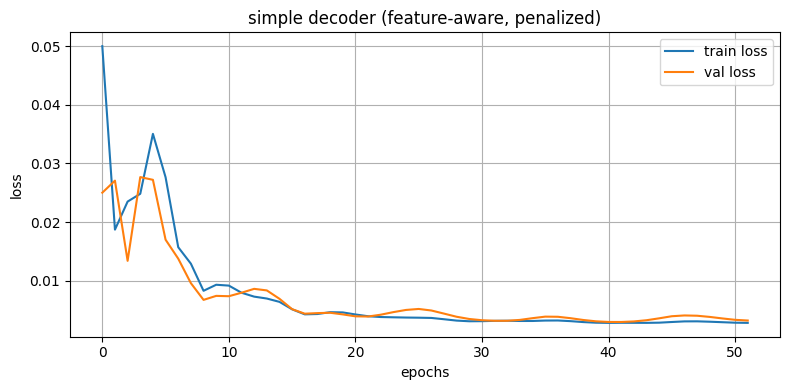

final train loss: 0.002809
final val loss: 0.003206


In [10]:
import importlib
import models.decoder
importlib.reload(models.decoder)

from models.decoder import SimpleSurfaceDecoder
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import os
from models.decoder_losses import create_black_scholes_hybrid_loss

# prepare input - concatenate latent codes with features
idx_eval = ops.convert_to_numpy(full_dataset.global_indices)[-len(Z_decoder):]
F_aligned = X_feat_tensor[idx_eval]
F_aligned_np = ops.convert_to_numpy(F_aligned)
ZF_decoder = np.concatenate([Z_decoder, F_aligned_np], axis=-1)  # combine z and features

# create model with arbitrage penalties
decoder_simple = SimpleSurfaceDecoder(
   latent_dim=LATENT_DIM,
   feature_dim=F_aligned.shape[1],
   M=M,
   K=K,
   use_penalties=True,
   lambda_cal=0.2,  # calendar arbitrage penalty weight
   lambda_smile=0.1  # smile arbitrage penalty weight
)

taus = ops.convert_to_numpy(tensors["taus"])
rel_strikes = ops.convert_to_numpy(tensors["strike_tensor"])

# Create Black-Scholes hybrid loss
bs_loss, vega_w, gamma_w = create_black_scholes_hybrid_loss(
    taus, rel_strikes, M, K
)
decoder_simple.compile(optimizer=Adam(1e-4), loss=bs_loss)
#decoder_simple.compile(optimizer=Adam(learning_rate=1e-4))

# callbacks
os.makedirs("saved_models/simple_surface", exist_ok=True)
callbacks = [
   EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
   ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=5),
   ModelCheckpoint("saved_models/simple_surface/decoder.keras", save_best_only=True)
]

# train decoder
history = decoder_simple.fit(
   x=ZF_decoder,
   y=Y_decoder,
   batch_size=BATCH_SIZE,
   validation_split=0.2,
   epochs=200,
   callbacks=callbacks,
   verbose=1
)

# plot training curves
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title("simple decoder (feature-aware, penalized)")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"final train loss: {history.history['loss'][-1]:.6f}")
print(f"final val loss: {history.history['val_loss'][-1]:.6f}")

raw vae-gru (feature-aware simple decoder) RMSE_σ: 0.0315
RMSE by maturity (mean ± std): 0.0326 ± 0.0092
RMSE by strike    (mean ± std): 0.0332 ± 0.0068


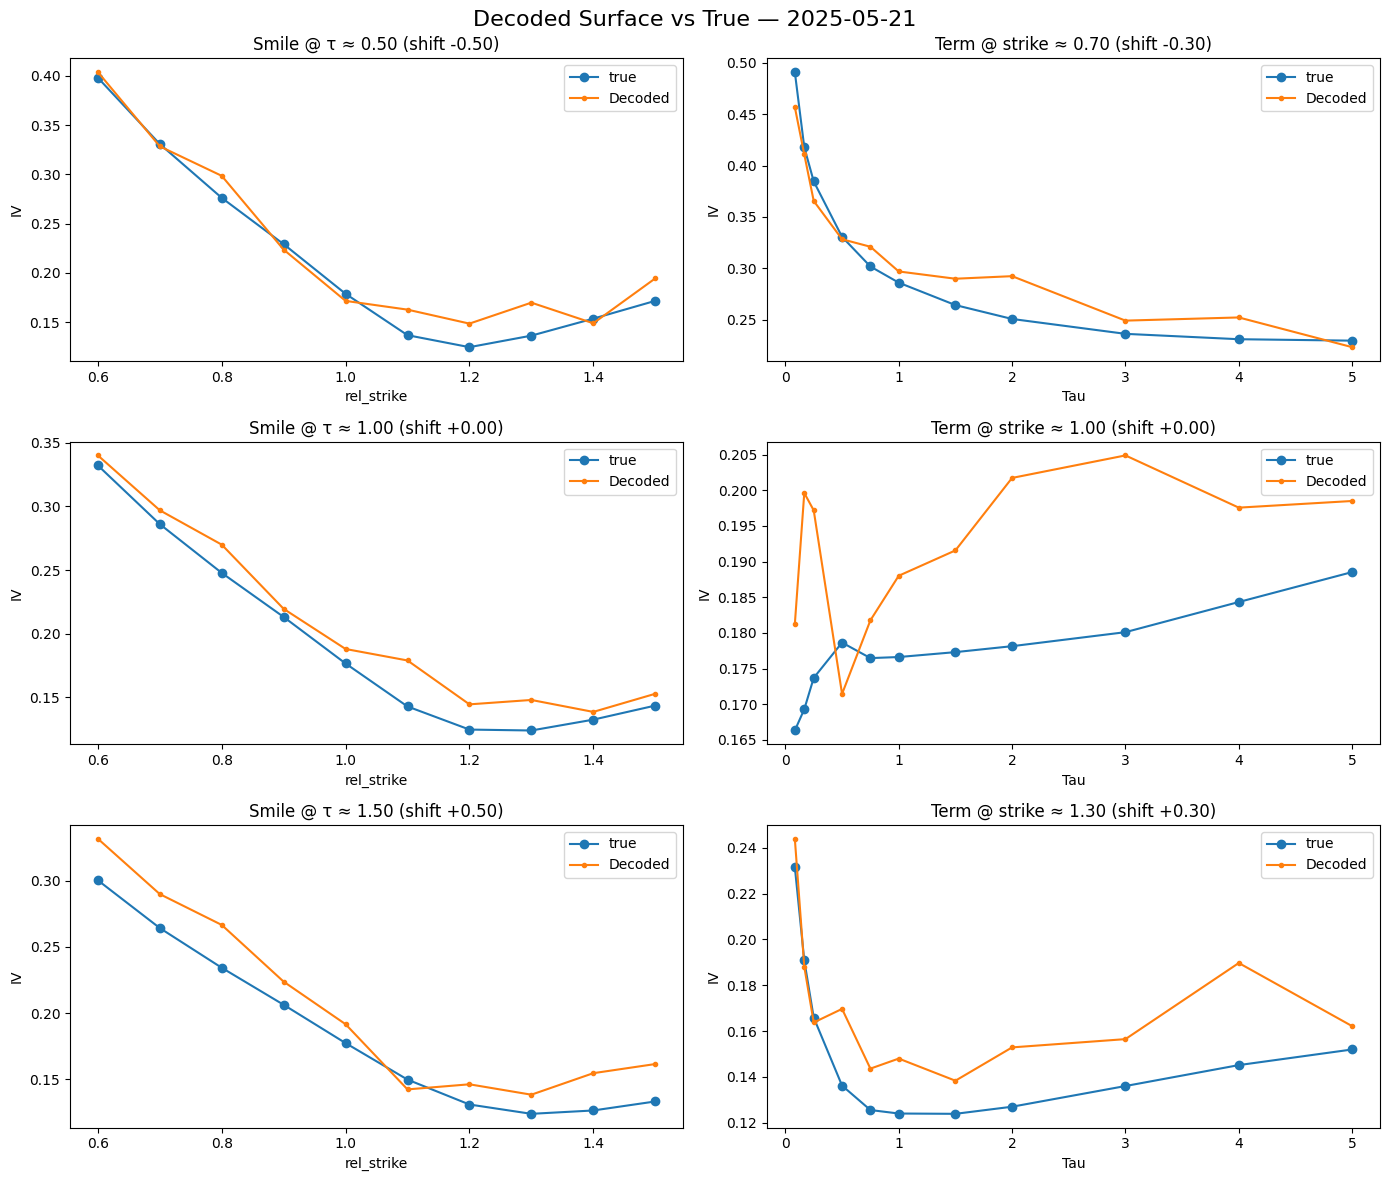

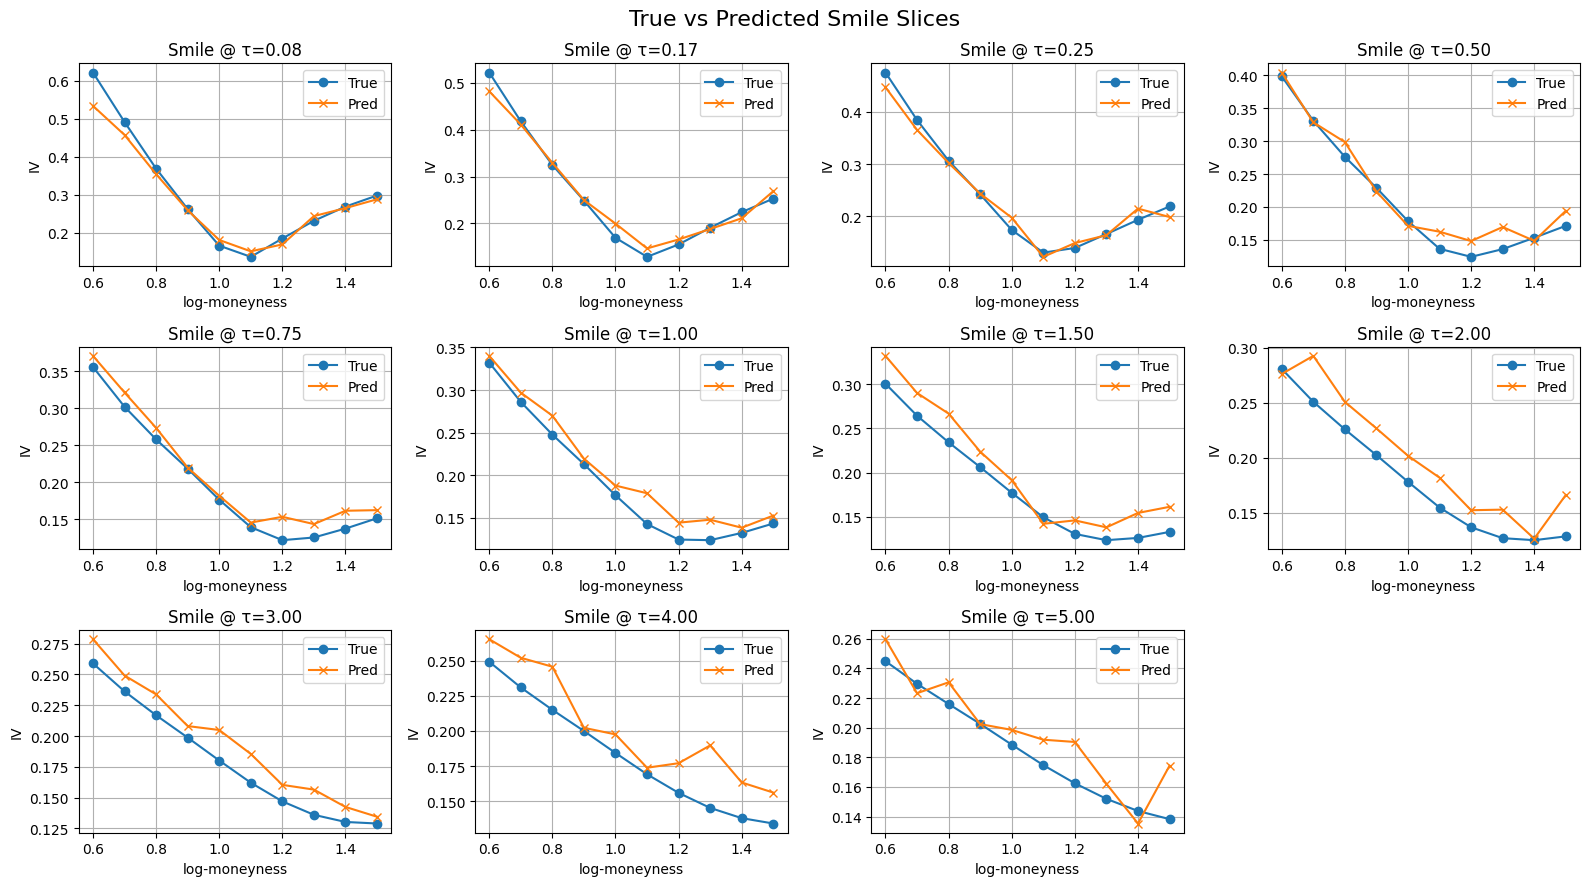

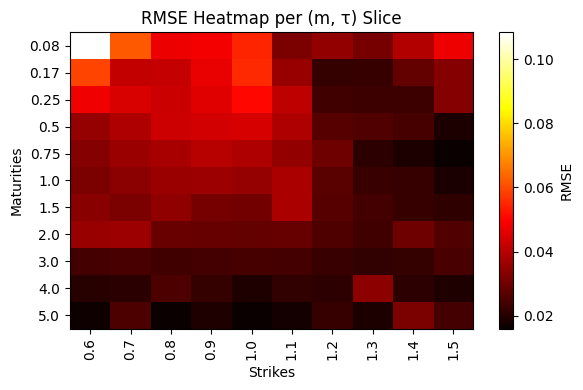

In [11]:
from utils.eval import evaluate_decoder_output

# full evaluation set (no slicing)
Z_eval = Z_decoder
F_eval = F_aligned_np
X_grid_eval = Y_decoder  # already aligned to z_eval

# predict decoded surfaces (z + f)
X_pred_raw = np.stack([
   decoder_simple.predict_surface(z, f)
   for z, f in zip(Z_eval, F_eval)
])

# evaluate raw predictions
evaluate_decoder_output(
   decoder=decoder_simple,
   Z_forecast=Z_eval,
   X_grid=X_grid_eval,
   X_true_idx=None,
   tensors=tensors,
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   taus=ops.convert_to_numpy(tensors["taus"]),
   target_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
   decoded_surfaces_override=X_pred_raw,
   title="raw vae-gru (feature-aware simple decoder)"
)

Epoch 1/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - val_loss: 7.6297e-04 - learning_rate: 1.0000e-04
Epoch 2/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 0.0028 - learning_rate: 1.0000e-04
Epoch 3/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - val_loss: 0.0034 - learning_rate: 1.0000e-04
Epoch 4/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - val_loss: 5.3796e-04 - learning_rate: 1.0000e-04
Epoch 5/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - val_loss: 0.0024 - learning_rate: 1.0000e-04
Epoch 6/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - val_loss: 0.0021 - learning_rate: 1.0000e-04
Epoch 7/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - val_loss: 0.0013 - learning_rate: 1.0000e-04
Epoch 8/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 4.8260e-04 - learning_rate: 1.0000e-04
Epoch 9/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.6705e-04 - val_loss: 4.

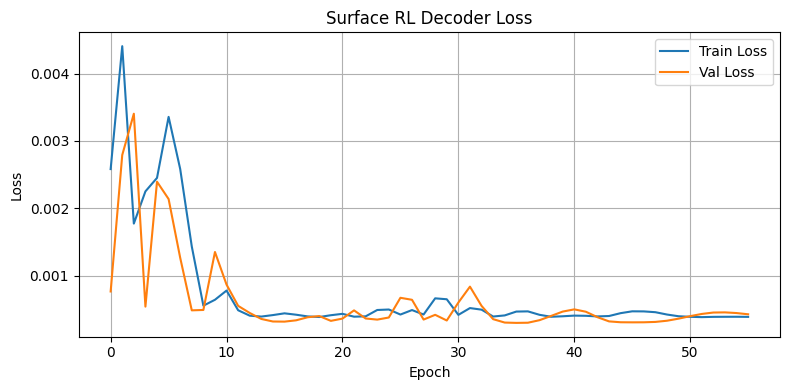

In [12]:
import models.rl_decoder
import importlib    
importlib.reload(models.rl_decoder)

from models.rl_decoder import SurfaceRLDecoder
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import os

X_train_surf = X_pred_raw[..., None]  # shape: (N, M, K, 1)
Y_train_surf = Y_decoder.reshape(-1, M, K, 1)

# originally set us as a residual
rl_model = SurfaceRLDecoder(M=M, K=K)
rl_model.compile(optimizer=Adam(1e-4))

callbacks = [
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=10),
    ModelCheckpoint("saved_models/surface_rl_decoder.keras", save_best_only=True)
]

# --- Optional split
split = int(0.9 * len(X_train_surf))
X_rl_train, X_rl_val = X_train_surf[:split], X_train_surf[split:]
Y_rl_train, Y_rl_val = Y_train_surf[:split], Y_train_surf[split:]

# --- Train
history = rl_model.fit(
    x=X_rl_train,
    y=Y_rl_train,
    validation_data=(X_rl_val, Y_rl_val),
    batch_size=32,
    epochs=300,
    callbacks=callbacks,
    verbose=1
)

# --- Plot
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Surface RL Decoder Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Decoder + RL Correction (Full Surface) RMSE_σ: 0.1561
RMSE by maturity (mean ± std): 0.1578 ± 0.0069
RMSE by strike    (mean ± std): 0.1568 ± 0.0187


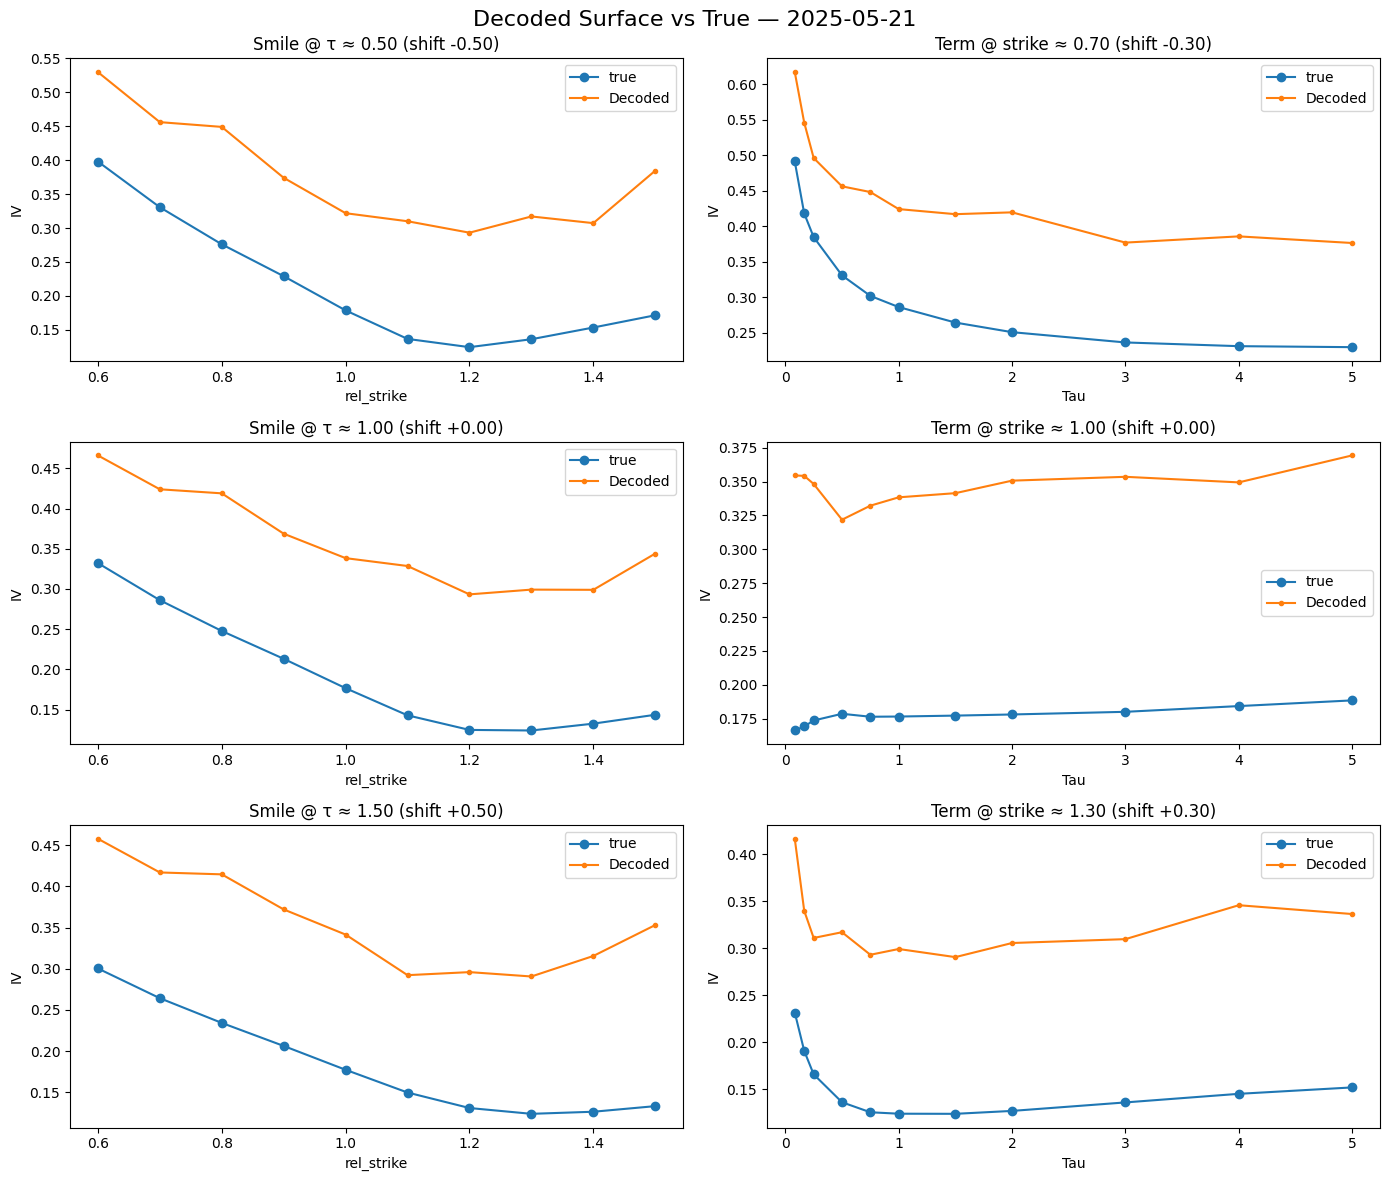

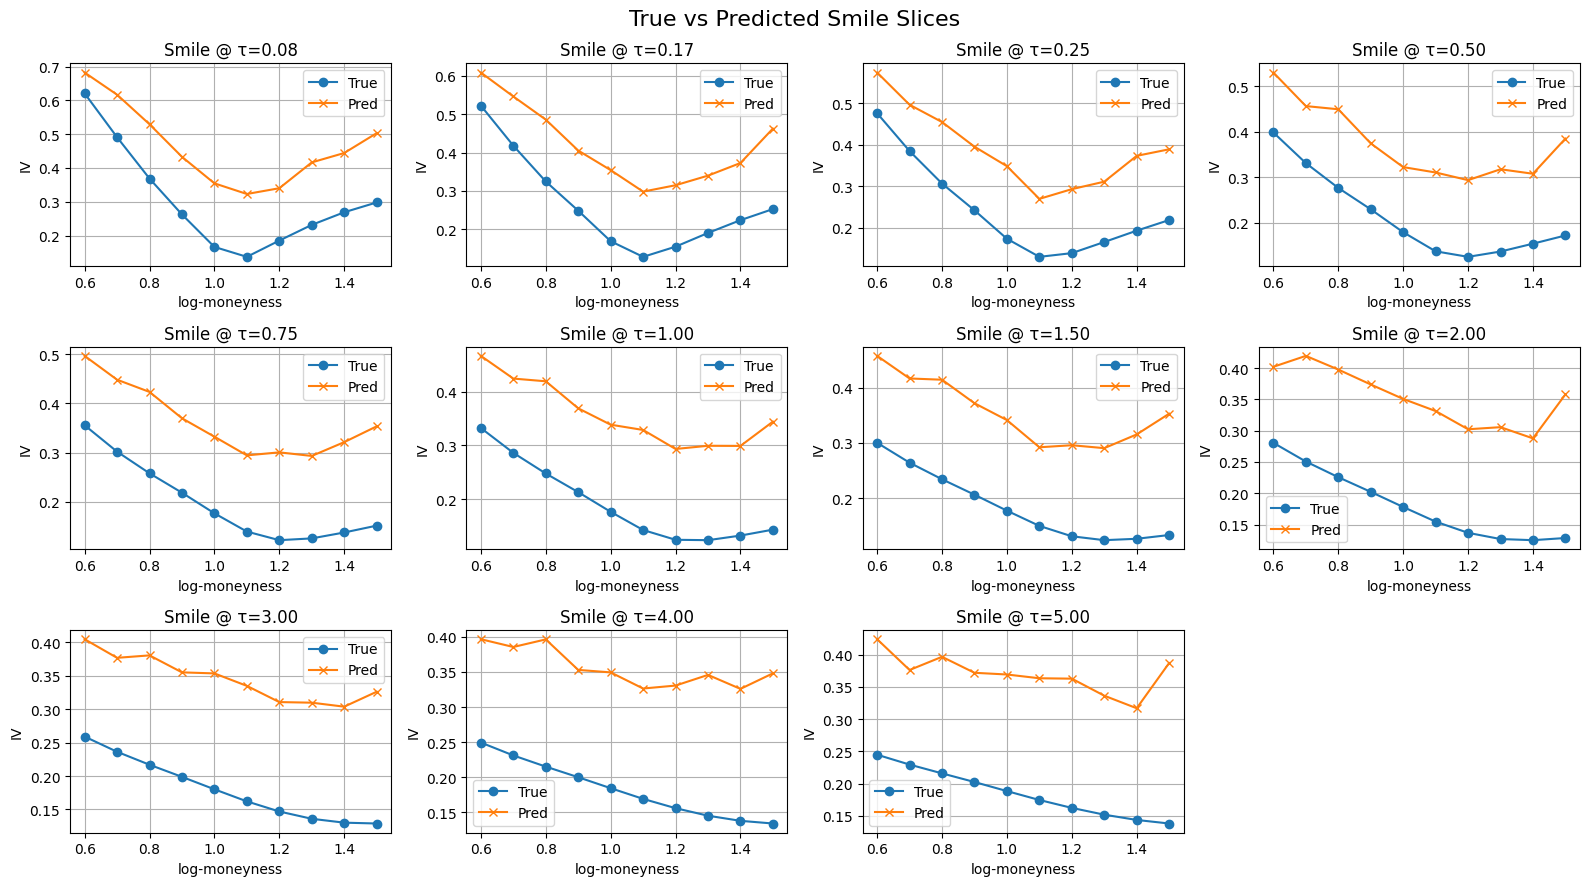

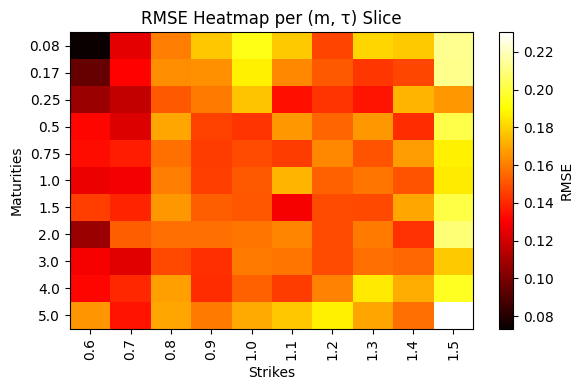

In [13]:
#Apply correction
X_delta = rl_model.predict(X_pred_raw[..., None], batch_size=64)  # shape: (N, M, K, 1)
X_corrected = (X_pred_raw[..., None] + X_delta)[..., 0]  # shape: (N, M, K)


evaluate_decoder_output(
    decoder=decoder_simple,
    Z_forecast=Z_decoder,
    X_grid=Y_decoder.reshape(-1, M, K),
    X_true_idx=None,
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoded_surfaces_override=X_corrected,
    title="Decoder + RL Correction (Full Surface)"
)


Smoothed VAE–GRU (Feature-Aware Simple Decoder) RMSE_σ: 0.0213
RMSE by maturity (mean ± std): 0.0226 ± 0.0118
RMSE by strike    (mean ± std): 0.0243 ± 0.0075


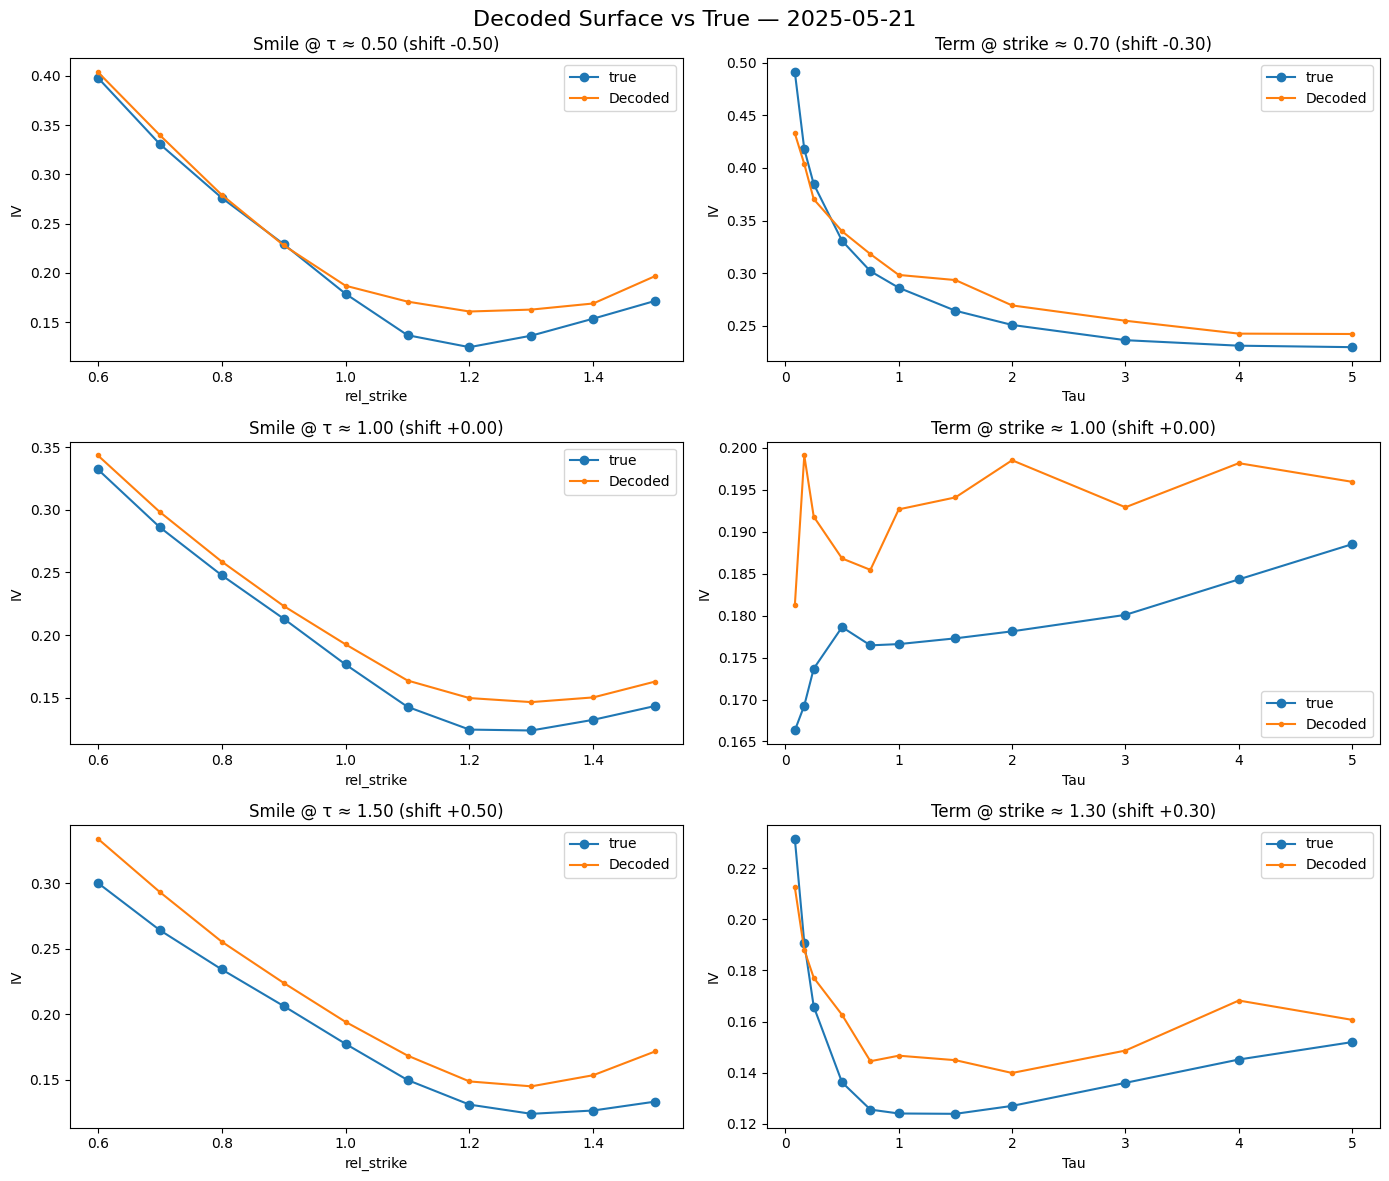

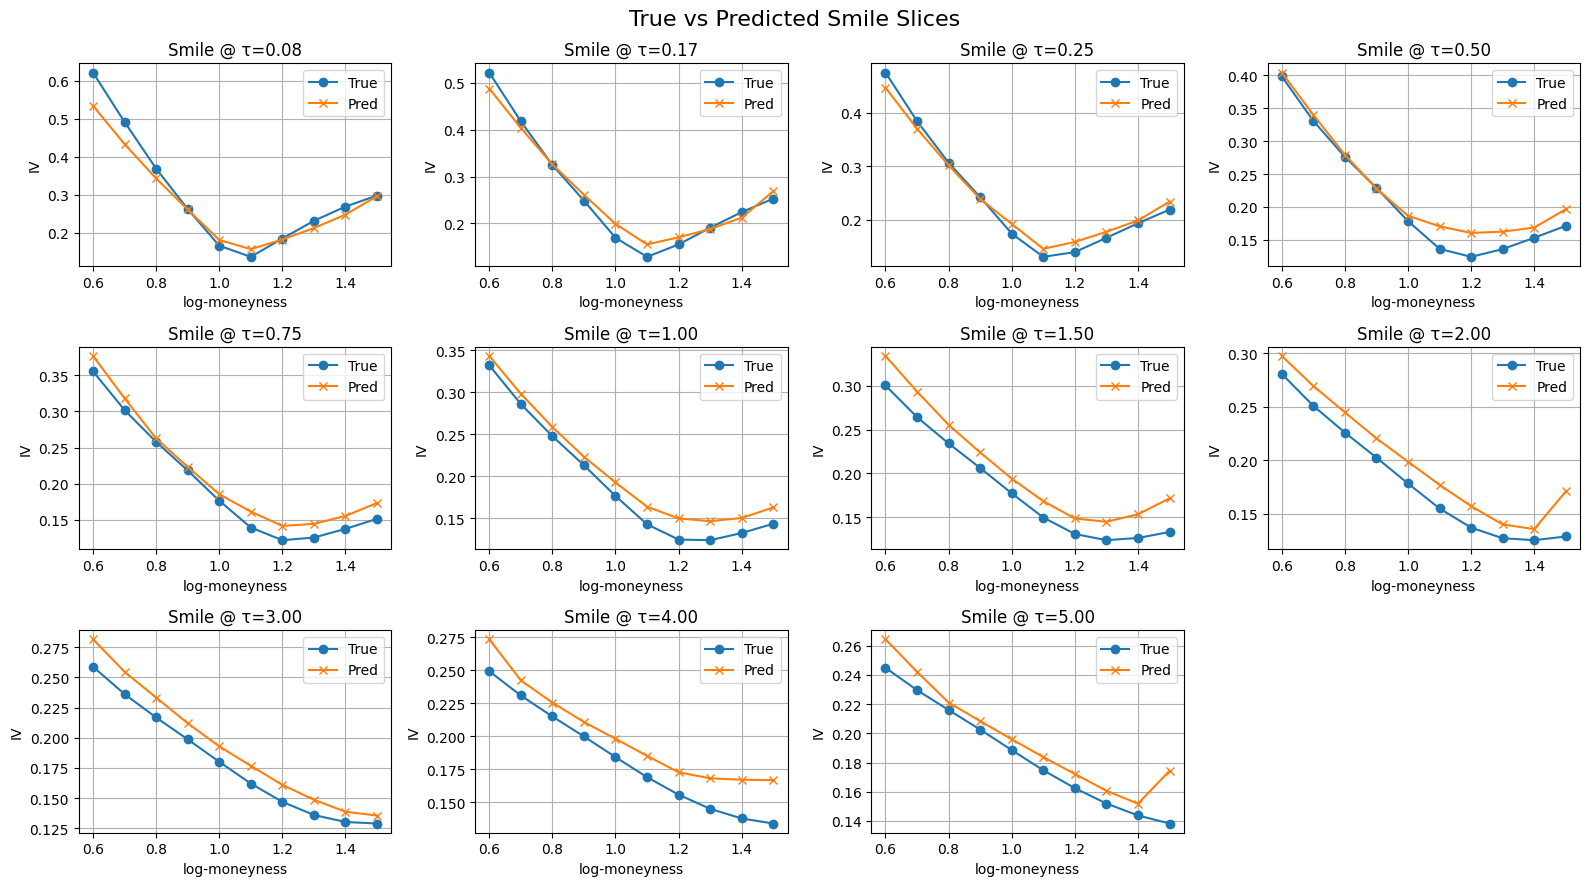

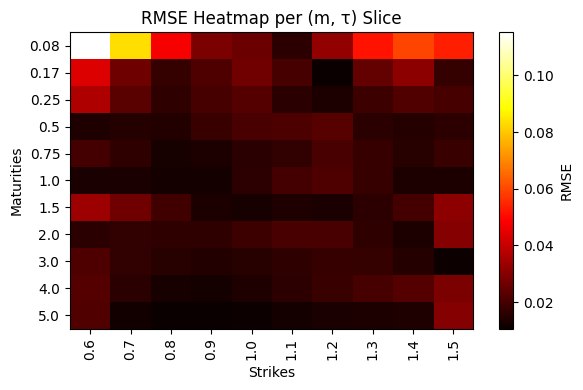

In [14]:

SMOOTH_ALL = False
N_surfaces = 20

# Select forecasted latents and features
Z_eval = Z_decoder if SMOOTH_ALL else Z_decoder[-N_surfaces:]
F_eval = F_aligned_np if SMOOTH_ALL else F_aligned_np[-N_surfaces:]
X_grid_eval = Y_decoder if SMOOTH_ALL else Y_decoder[-N_surfaces:]

# Predict surfaces
X_pred_raw = np.stack([
    decoder_simple.predict_surface(z, f)
    for z, f in zip(Z_eval, F_eval)
])

#  Smooth surfaces
X_pred_smooth = np.stack([
    decoder_simple.refine_surface(surf, lambda_cal=0.2, lambda_smile=0.7)
    for surf in X_pred_raw
])

# Evaluate smoothed predictions
evaluate_decoder_output(
    decoder=decoder_simple,
    Z_forecast=Z_eval,
    X_grid=X_grid_eval,
    X_true_idx=None,
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoded_surfaces_override=X_pred_smooth,
    title="Smoothed VAE–GRU (Feature-Aware Simple Decoder)"
)


Epoch 1/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1996 - val_loss: 0.1621 - learning_rate: 1.0000e-05
Epoch 2/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1205 - val_loss: 0.1057 - learning_rate: 1.0000e-05
Epoch 3/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0749 - val_loss: 0.0711 - learning_rate: 1.0000e-05
Epoch 4/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0472 - val_loss: 0.0494 - learning_rate: 1.0000e-05
Epoch 5/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0319 - val_loss: 0.0354 - learning_rate: 1.0000e-05
Epoch 6/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0206 - val_loss: 0.0263 - learning_rate: 1.0000e-05
Epoch 7/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0146 - val_loss: 0.0201 - learning_rate: 1.0000e-05
Epoch 8/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0109 - val_loss: 0.0158 - learning_rate: 1.0000e-05
Epoch 9/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - val_loss: 0.0129 - learning_

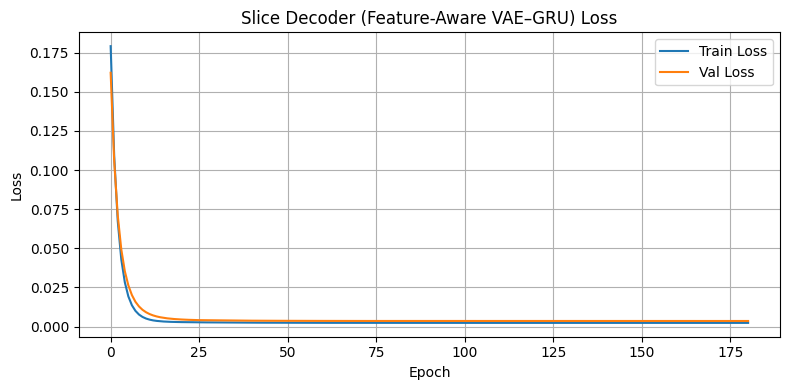

In [15]:
import models.decoder
import importlib
importlib.reload(models.decoder)

from models.decoder import SliceSurfaceDecoder
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import os

#  Align surface and feature data
idx_eval = ops.convert_to_numpy(full_dataset.global_indices)[-len(Z_decoder):]

#  Retrieve aligned features f_t
F_aligned = X_feat_tensor[idx_eval]  # (N, d_f)
F_aligned_np = ops.convert_to_numpy(F_aligned)

#  Combine z  f
ZF_decoder = np.concatenate([Z_decoder, F_aligned_np], axis=-1)  # (N, latent_dim + feature_dim)

# --- Reshape surface targets
Y_decoder_reshaped = Y_decoder.reshape(-1, M, K)  # (N, M, K)


#  Instantiate model with taus and feature_dim
taus = ops.convert_to_numpy(tensors["taus"])
decoder_slice = SliceSurfaceDecoder(
    latent_dim=LATENT_DIM,
    feature_dim=F_aligned_np.shape[1],
    M=M,
    K=K,
    taus=taus
)
decoder_slice.compile(optimizer=Adam(learning_rate=1e-5), loss="mse")

#  Callbacks
os.makedirs("saved_models/slice_surface", exist_ok=True)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=5),
    ModelCheckpoint("saved_models/slice_surface/decoder.keras", save_best_only=True)
]

#  Fit decoder on GRU forecasted [z + f] → surface
Y_decoder_reshaped = Y_decoder.reshape(-1, M, K)
history = decoder_slice.fit(
    ZF_decoder,
    Y_decoder_reshaped,
    validation_split=0.2,
    batch_size=BATCH_SIZE,
    epochs=300,
    callbacks=callbacks,
    verbose=1
)

# --- Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Slice Decoder (Feature-Aware VAE–GRU) Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Raw VAE–GRU (Feature-Aware Slice Decoder) RMSE_σ: 0.0485
RMSE by maturity (mean ± std): 0.0495 ± 0.0126
RMSE by strike    (mean ± std): 0.0505 ± 0.0075


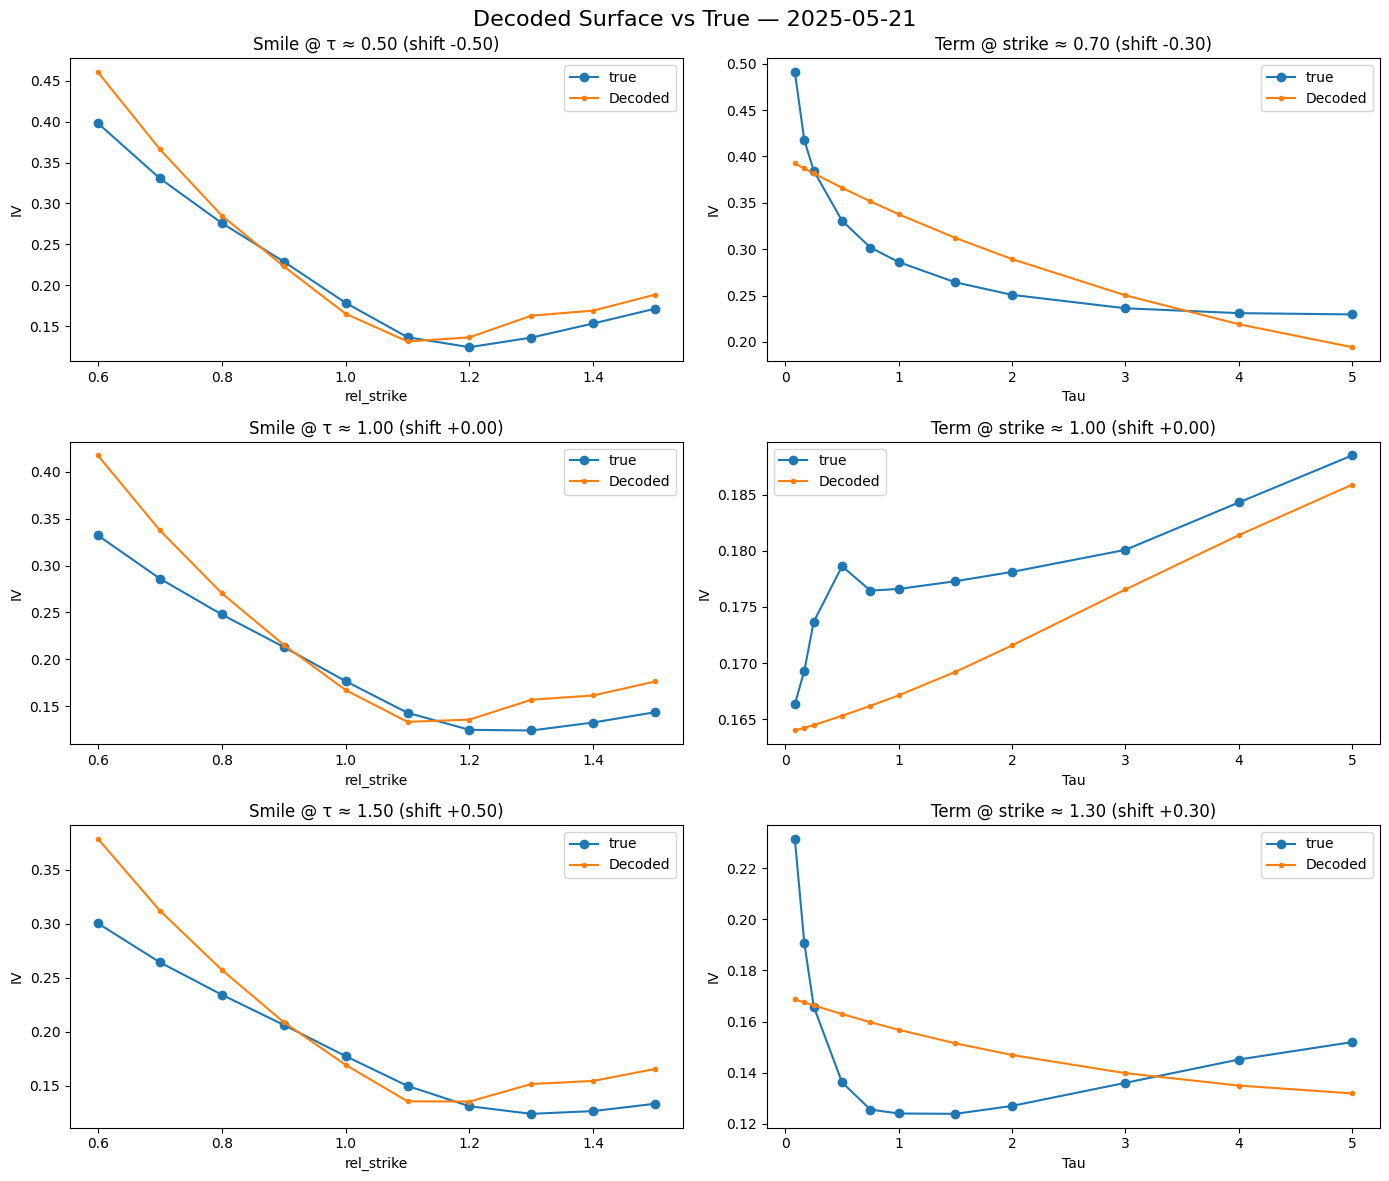

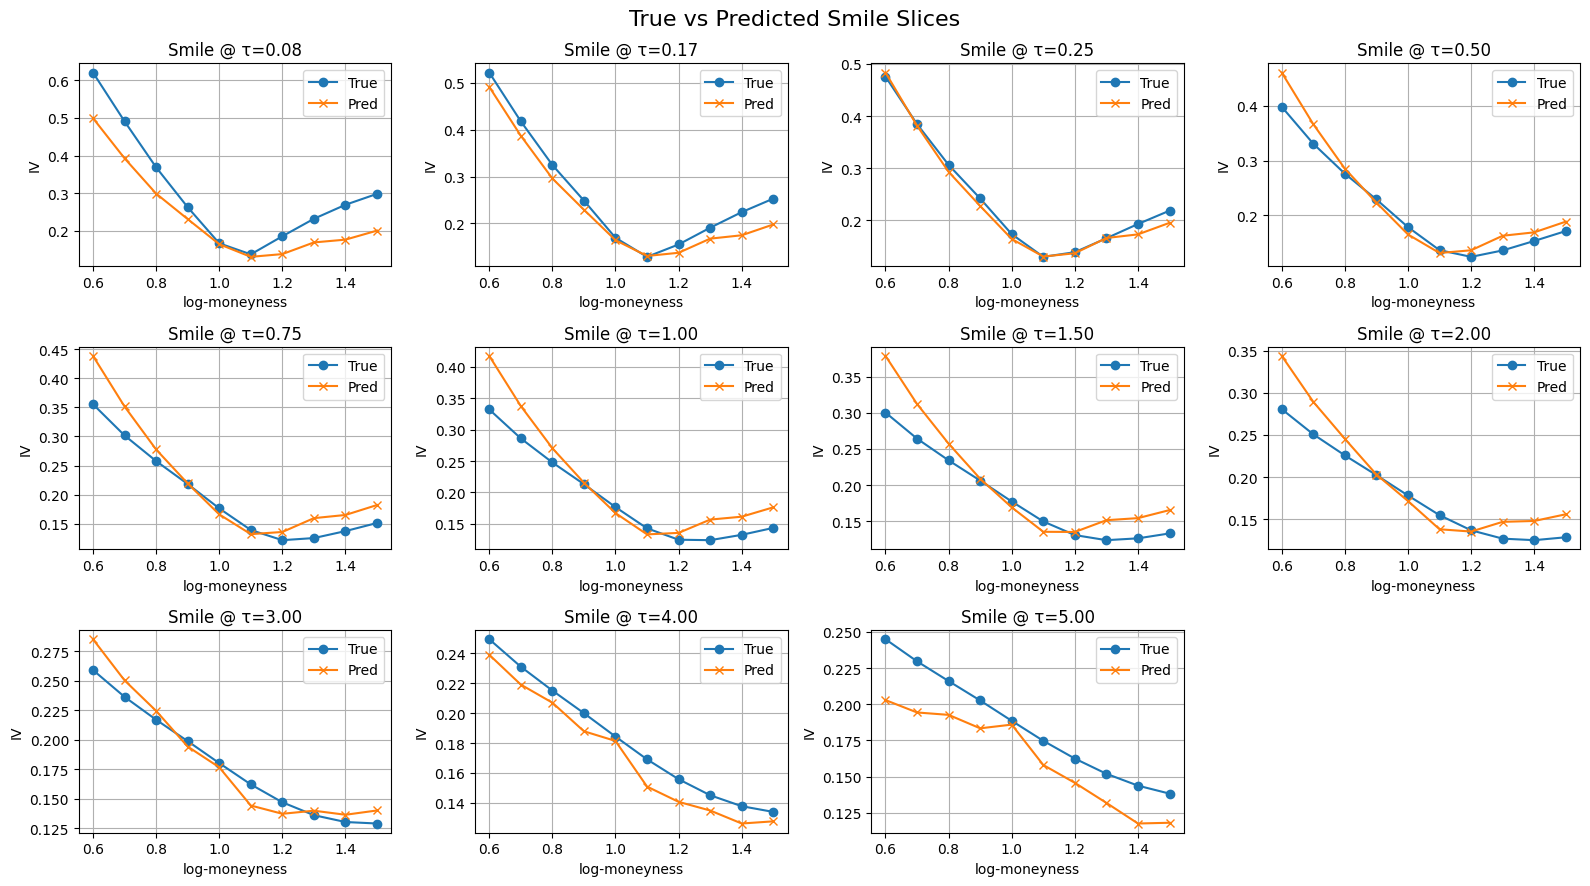

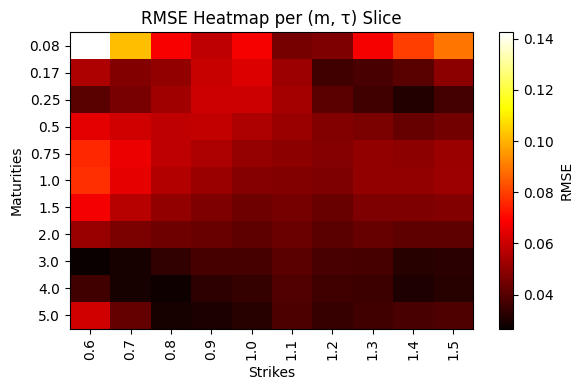

In [16]:
from utils.eval import evaluate_decoder_output


Z_eval = Z_decoder
F_eval = F_aligned_np
X_grid_eval = Y_decoder  # (N, M*K)

# - Predict surfaces using decoder_slice
X_pred_raw = np.stack([
    decoder_slice.predict_surface(z, f)
    for z, f in zip(Z_eval, F_eval)
])  # shape: (N, M, K)

# 
evaluate_decoder_output(
    decoder=decoder_slice,
    Z_forecast=Z_eval,
    X_grid=X_grid_eval,
    X_true_idx=None,
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoded_surfaces_override=X_pred_raw,
    title="Raw VAE–GRU (Feature-Aware Slice Decoder)"
)


Epoch 1/300
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0131 - val_loss: 0.0179 - learning_rate: 1.0000e-04
Epoch 2/300
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0817 - val_loss: 0.0572 - learning_rate: 1.0000e-04
Epoch 3/300
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2188 - val_loss: 0.0841 - learning_rate: 1.0000e-04
Epoch 4/300
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0980 - val_loss: 0.1406 - learning_rate: 1.0000e-04
Epoch 5/300
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1020 - val_loss: 0.0631 - learning_rate: 1.0000e-04
Epoch 6/300
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0295 - val_loss: 0.0280 - learning_rate: 1.0000e-04
Epoch 7/300
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0212 - val_loss: 0.0048 - learning_rate: 1.0000e-04
Epoch 8/300
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0162 - val_loss: 0.0327 - learning_rate: 1.0000e-04
Epoch 9/300
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0193 - val_loss: 

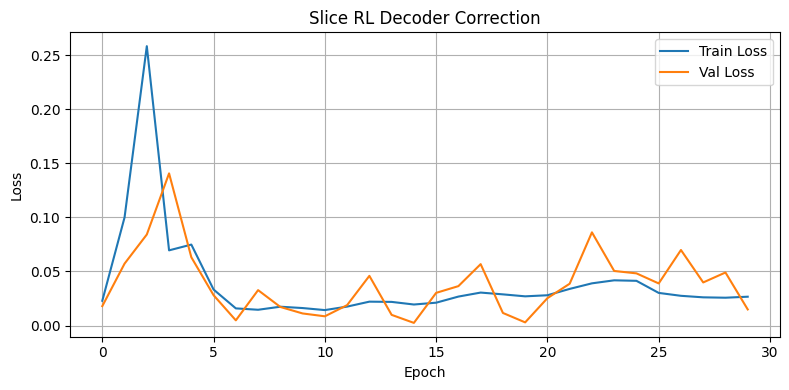

In [17]:
import models.rl_decoder
import importlib    
importlib.reload(models.rl_decoder)

from models.rl_decoder import SliceRLDecoder, build_slice_dataset
import os
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# slice decoder for smiles 
X_pred_raw = np.stack([
    decoder_slice.predict_surface(z, f)
    for z, f in zip(Z_decoder, F_aligned_np)
])  # shape: (N, M, K)

IV_true_surf = Y_decoder.reshape(-1, M, K)

#  Slice-level data
X_rl, _ = build_slice_dataset(X_pred_raw)
Y_rl_true, _ = build_slice_dataset(IV_true_surf)

#  Instantiate RL correction model
rl_model = SliceRLDecoder(K=K)
rl_model.compile(optimizer=keras.optimizers.Adam(1e-4))

#  Callbacks
os.makedirs("saved_models/rl_decoder", exist_ok=True)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=10, min_lr=1e-7),
    ModelCheckpoint("saved_models/rl_decoder/slice_rl_decoder.keras", save_best_only=True)
]

#  Train/val split
split = int(0.9 * len(X_rl))
X_rl_train, X_rl_val = X_rl[:split], X_rl[split:]
Y_rl_train, Y_rl_val = Y_rl_true[:split], Y_rl_true[split:]

#  Train RL slice decoder
history = rl_model.fit(
    x=X_rl_train,
    y=Y_rl_train,
    validation_data=(X_rl_val, Y_rl_val),
    batch_size=32,
    epochs=300,
    callbacks=callbacks,
    verbose=1
)

#  Plot loss
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Slice RL Decoder Correction")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Slice Decoder + RL Correction RMSE_σ: 0.0488
RMSE by maturity (mean ± std): 0.0498 ± 0.0145
RMSE by strike    (mean ± std): 0.0514 ± 0.0075


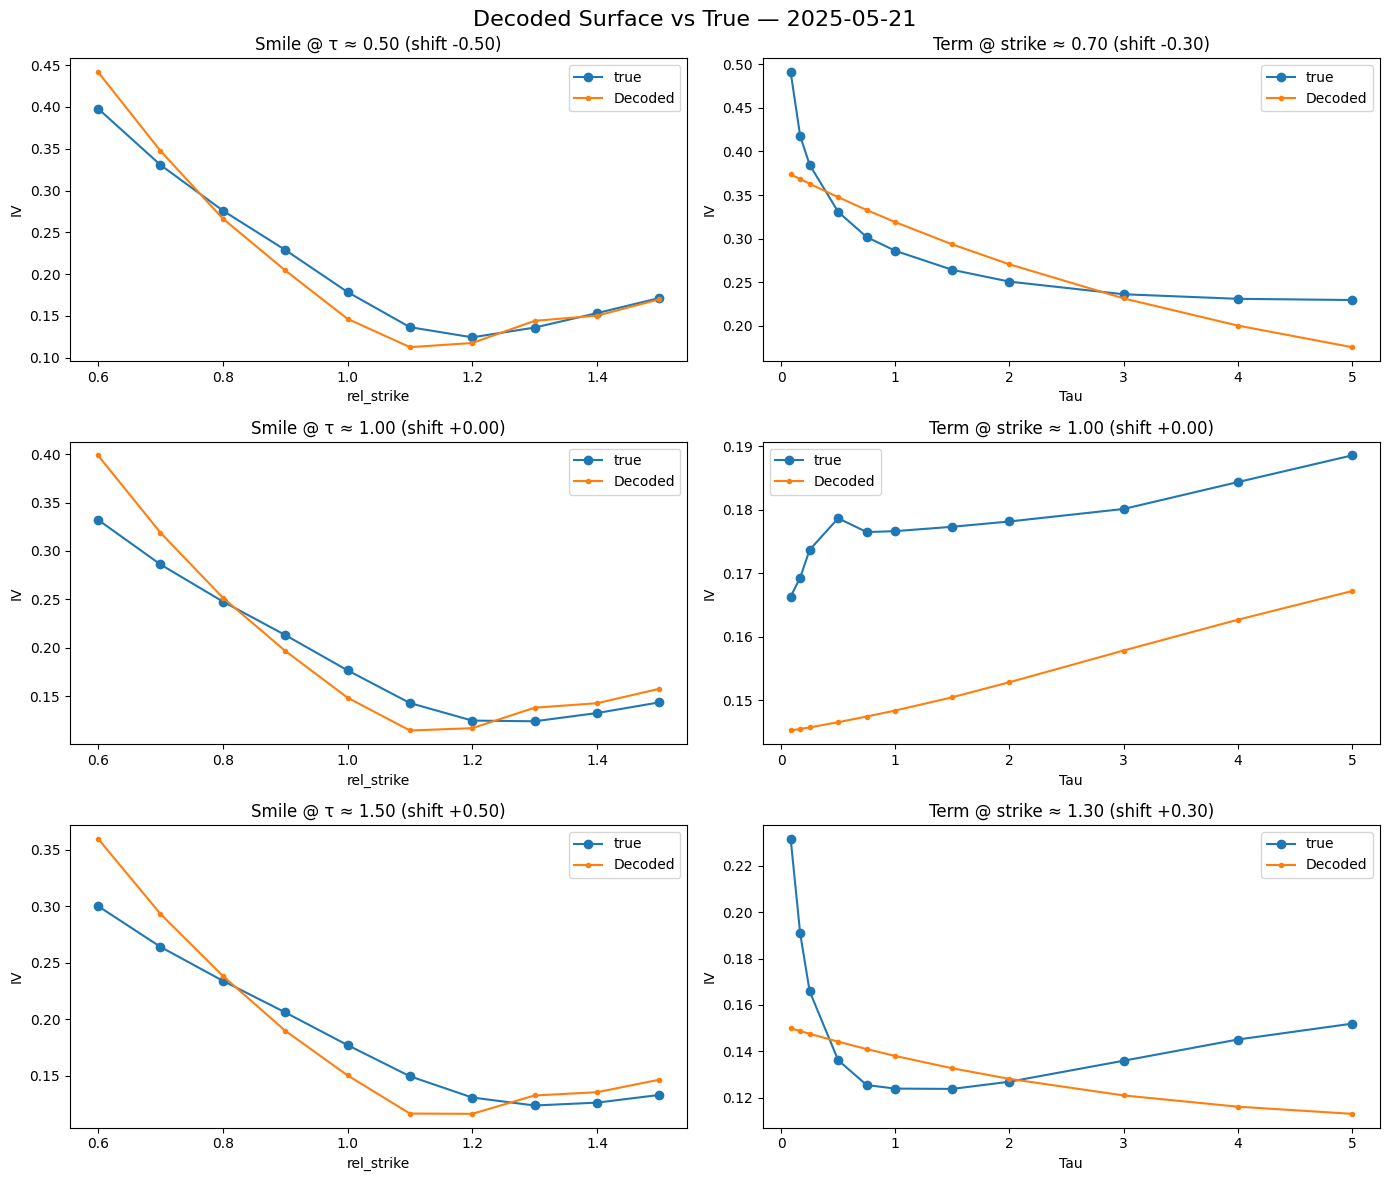

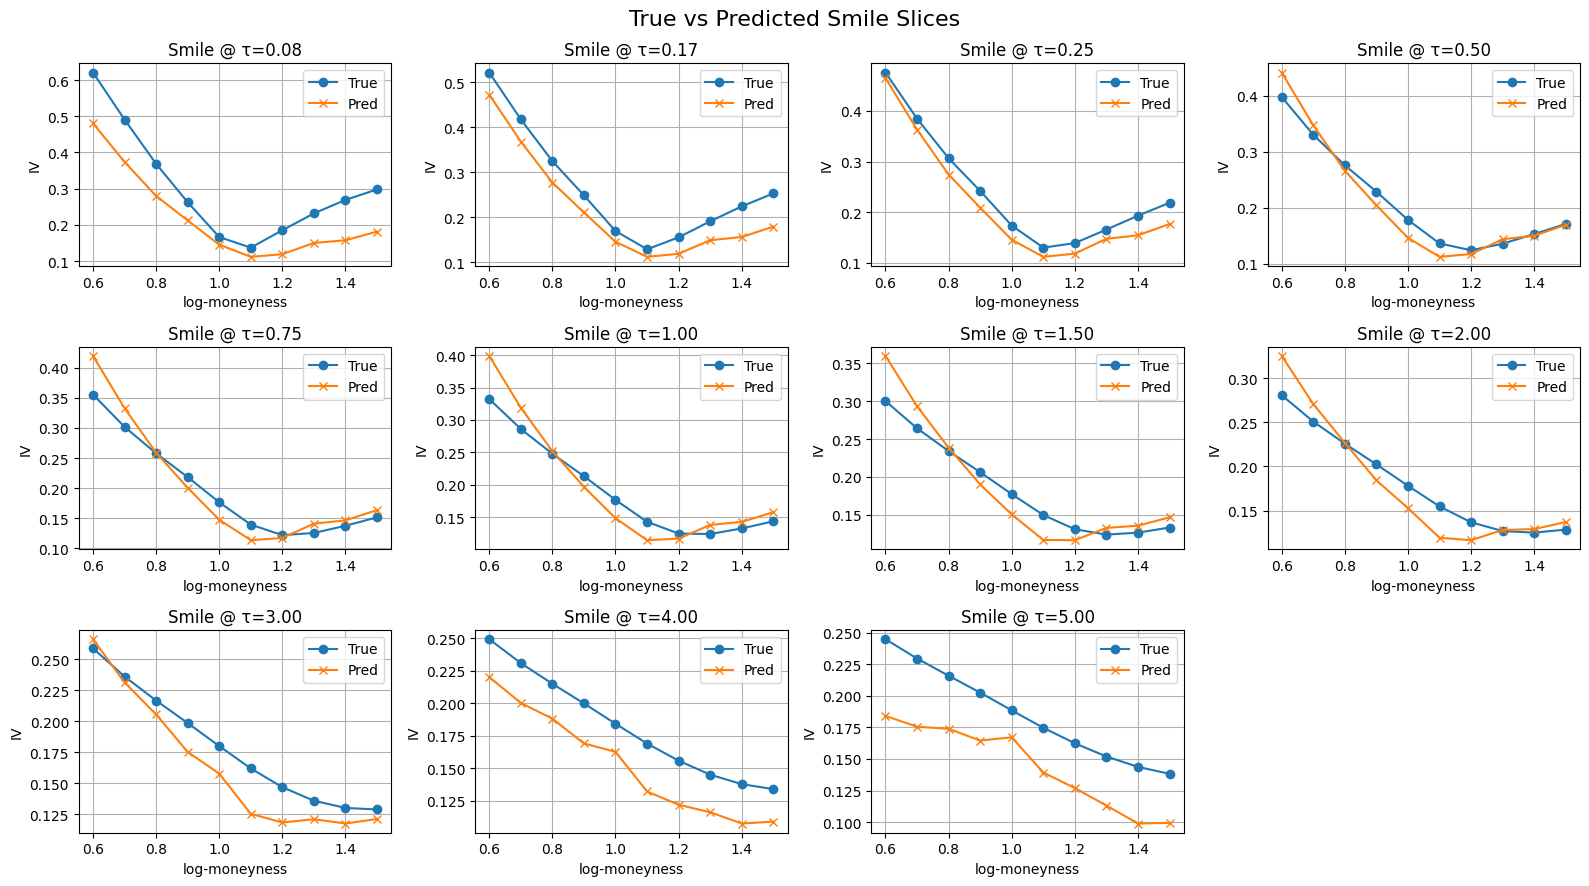

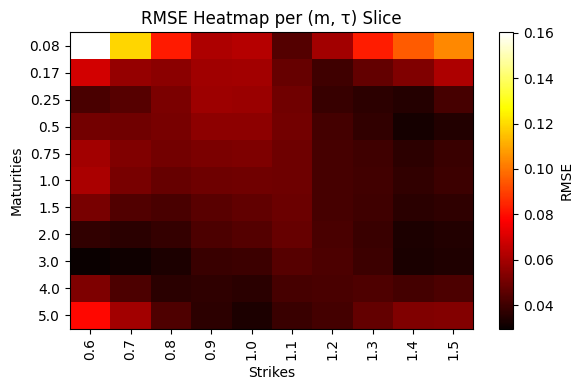

In [18]:
from utils.eval import evaluate_decoder_output

#  Predict decoded surfaces from slice decoder
X_pred_raw = np.stack([
    decoder_slice.predict_surface(z, f)
    for z, f in zip(Z_decoder, F_aligned_np)
])  # shape: (N, M, K)

#  Apply RL correction (slice by slice)
X_rl_input = X_pred_raw.reshape(-1, K, 1)            # (N*M, K, 1)
delta_rl = rl_model.predict(X_rl_input, batch_size=128)
X_pred_corrected = (X_rl_input + delta_rl).reshape(-1, M, K)

#  Evaluate corrected surfaces
evaluate_decoder_output(
    decoder=decoder_slice,
    Z_forecast=Z_decoder,
    X_grid=Y_decoder.reshape(-1, M, K),
    X_true_idx=None,
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoded_surfaces_override=X_pred_corrected,
    title="Slice Decoder + RL Correction"
)


Smoothed VAE–GRU (Feature-Aware Slice Decoder) RMSE_σ: 0.0297
RMSE by maturity (mean ± std): 0.0329 ± 0.0169
RMSE by strike    (mean ± std): 0.0339 ± 0.0148


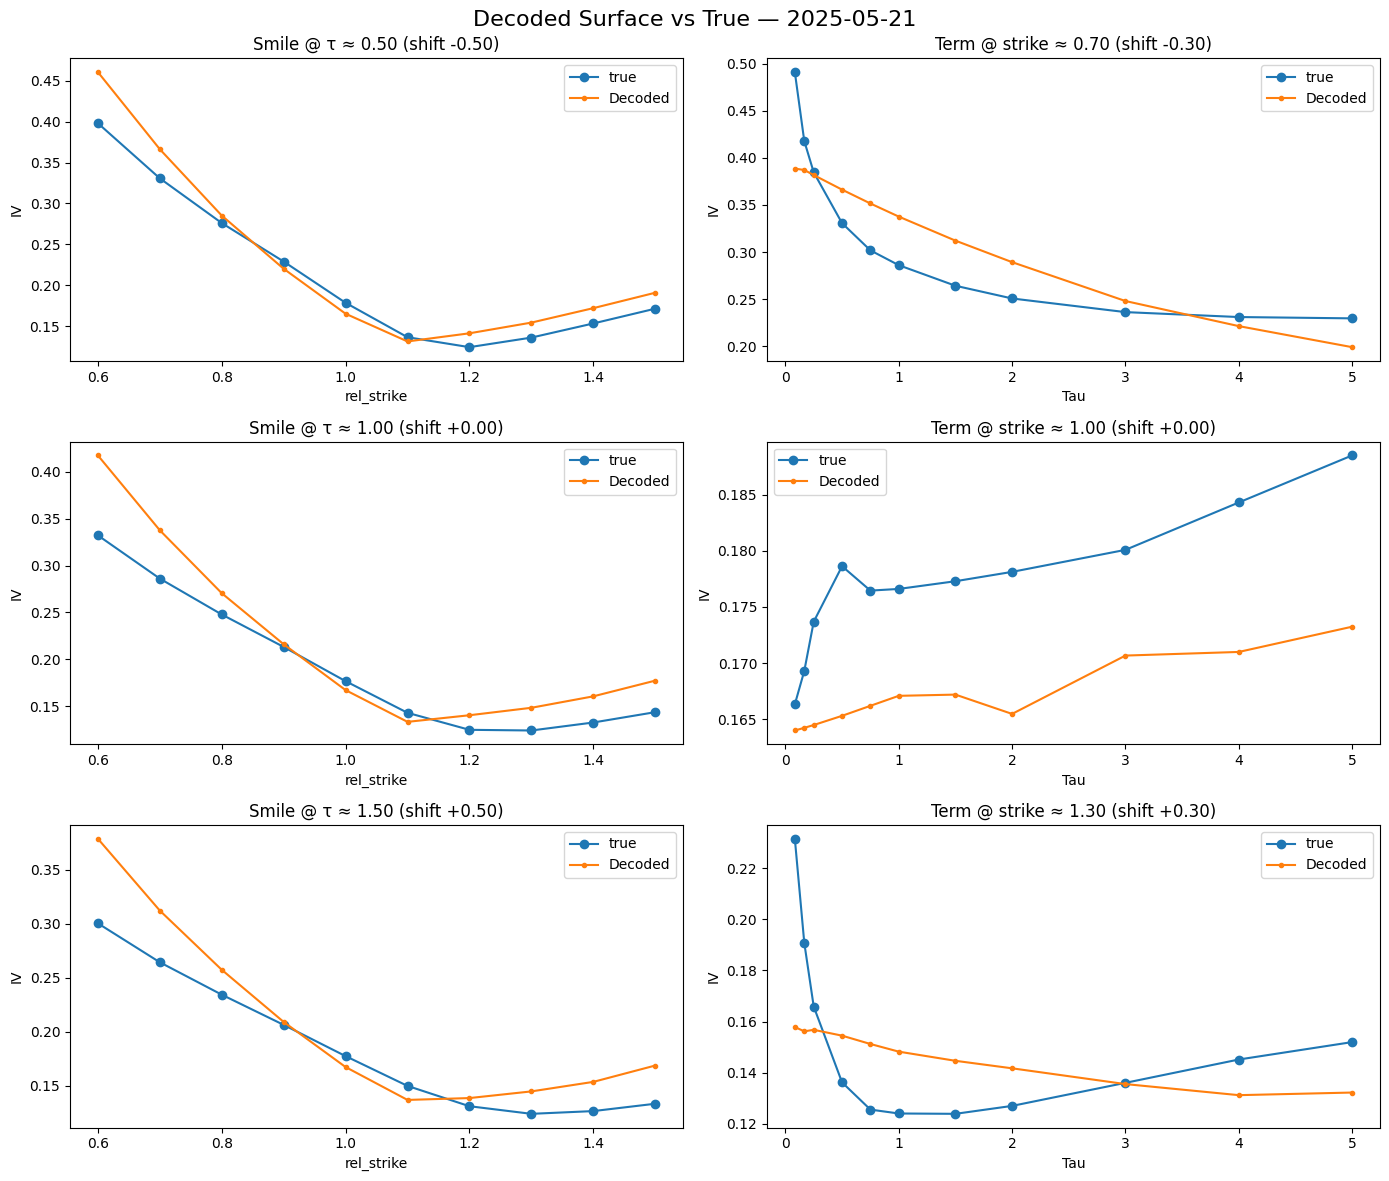

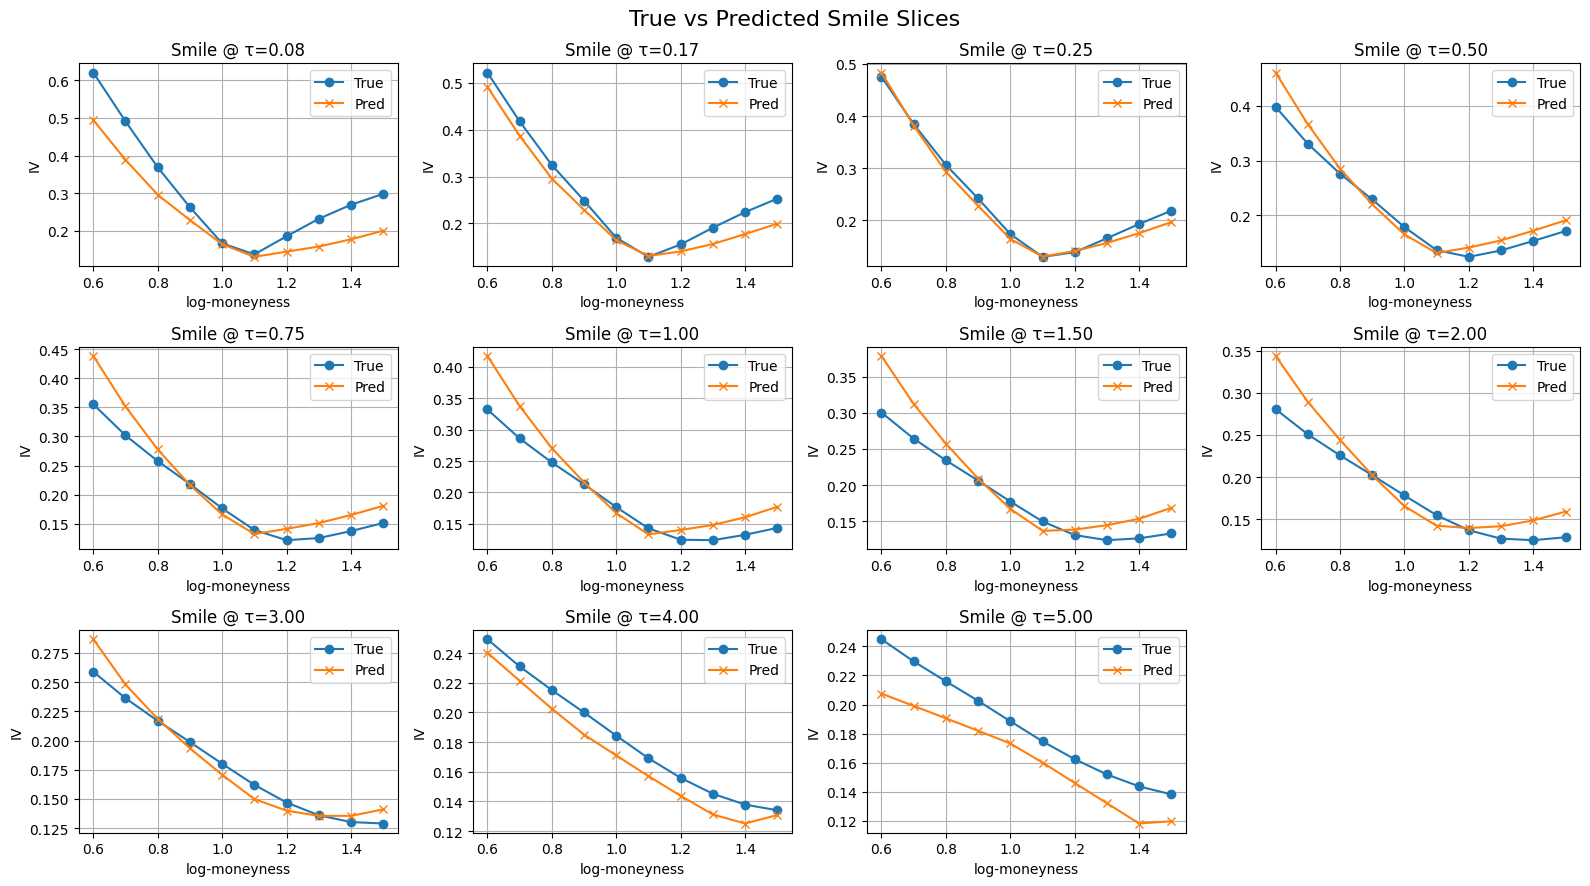

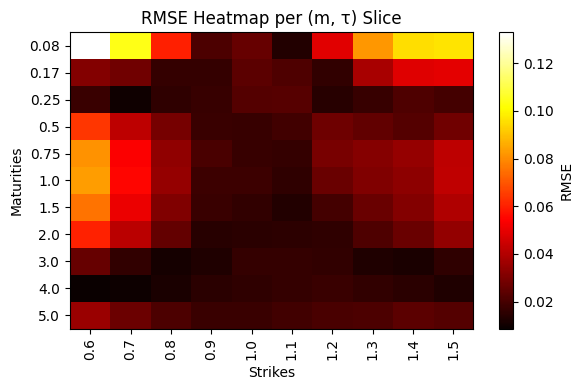

In [19]:
import importlib
import utils.eval
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output

#  Config
SMOOTH_ALL = False
N_surfaces = 10

#  Select forecasted latents, features, and true surfaces
Z_eval = Z_decoder if SMOOTH_ALL else Z_decoder[-N_surfaces:]
F_eval = F_aligned_np if SMOOTH_ALL else F_aligned_np[-N_surfaces:]
X_grid_eval = Y_decoder if SMOOTH_ALL else Y_decoder[-N_surfaces:]

X_pred_slice = np.stack([
    decoder_slice.predict_surface(z, f) for z, f in zip(Z_eval, F_eval)
])

#  Optional smoothing (refinement with zero penalty)
X_pred_slice_smooth = np.stack([
    decoder_slice.refine_surface(surf, lambda_cal=0.51, lambda_smile=1.0)
    for surf in X_pred_slice
])


evaluate_decoder_output(
    decoder=decoder_slice,
    Z_forecast=Z_eval,
    X_grid=X_grid_eval,
    X_true_idx=None,
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoded_surfaces_override=X_pred_slice_smooth,
    title="Smoothed VAE–GRU (Feature-Aware Slice Decoder)"
)


In [20]:
import models.decoder
import importlib
importlib.reload(models.decoder)

from models.decoder import PiecewiseSurfaceDecoder
from keras.optimizers import Adam

#  Instantiate feature-aware decoder
decoder_pw = PiecewiseSurfaceDecoder(
    latent_dim=LATENT_DIM,
    M=M,
    K=K,
    feature_dim=F_aligned.shape[1]  # includes f_t
)
decoder_pw.compile(optimizer=Adam(learning_rate=5e-5), loss="mse")
#  Prepare strike and maturity grids
rel_strikes = ops.convert_to_numpy(tensors["strike_tensor"])
taus = ops.convert_to_numpy(tensors["taus"])

#  Reshape targets to (N, M*K)
Y_surface_full = Y_decoder.reshape(-1, M * K)

#  Train/val/test split
N_total = len(Z_decoder)
train_split = int(0.7 * N_total)
val_split = int(0.85 * N_total)

Z_train, Z_val, Z_test = np.split(Z_decoder, [train_split, val_split])
F_train, F_val, F_test = np.split(F_aligned, [train_split, val_split])
Y_train, Y_val, Y_test = np.split(Y_surface_full, [train_split, val_split])

#  Build training data from surfaces
[X_zf_train, X_m_train, X_tau_train], y_train = decoder_pw.build_training_data_from_surfaces(
    Z_train, Y_train, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_train
)
[X_zf_val, X_m_val, X_tau_val], y_val = decoder_pw.build_training_data_from_surfaces(
    Z_val, Y_val, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_val
)
[X_zf_test, X_m_test, X_tau_test], y_test = decoder_pw.build_training_data_from_surfaces(
    Z_test, Y_test, strike_tensor=rel_strikes, tau_tensor=taus, F_features=F_test
)

#  Final Keras input aliases
X_train = [X_zf_train, X_m_train, X_tau_train]
X_val   = [X_zf_val,   X_m_val,   X_tau_val]
X_test  = [X_zf_test,  X_m_test,  X_tau_test]


Epoch 1/300
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0211 - val_loss: 0.0030 - learning_rate: 5.0000e-05
Epoch 2/300
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0023 - val_loss: 0.0027 - learning_rate: 5.0000e-05
Epoch 3/300
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0019 - val_loss: 0.0021 - learning_rate: 5.0000e-05
Epoch 4/300
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0013 - val_loss: 0.0013 - learning_rate: 5.0000e-05
Epoch 5/300
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 8.7835e-04 - val_loss: 8.7980e-04 - learning_rate: 5.0000e-05
Epoch 6/300
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 6.3334e-04 - val_loss: 6.6701e-04 - learning_rate: 5.0000e-05
Epoch 7/300
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 4.6628e-04 - val_loss: 5.0488e-04 - learning_rate: 5.0000e-05
Epoch 8/300
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 3.6391e-04 - val_loss: 4.3853e-04 - learning_rate: 5.0000e-05
Epoch 9/300
2926/2926 ━━

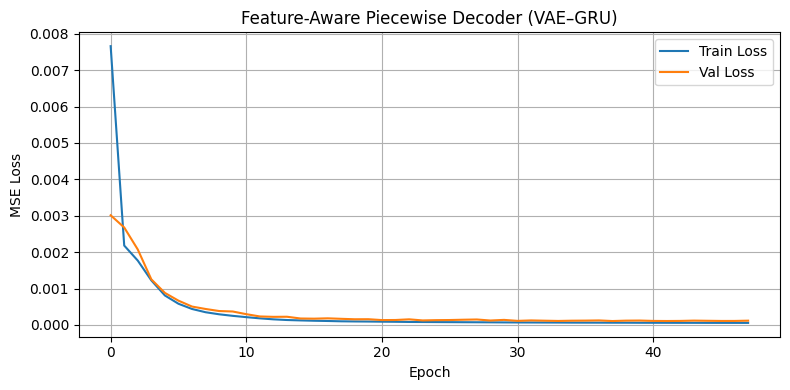

In [21]:
import os
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


os.makedirs("saved_models/piecewise_surface", exist_ok=True)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=5, min_lr=1e-7),
    ModelCheckpoint("saved_models/piecewise_surface/decoder.keras", save_best_only=True)
]


history = decoder_pw.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=300,
    callbacks=callbacks,
    verbose=1
)


plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Feature-Aware Piecewise Decoder (VAE–GRU)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Raw VAE–GRU (Feature-Aware Decoder) RMSE_σ: 0.0080
RMSE by maturity (mean ± std): 0.0083 ± 0.0040
RMSE by strike    (mean ± std): 0.0090 ± 0.0016


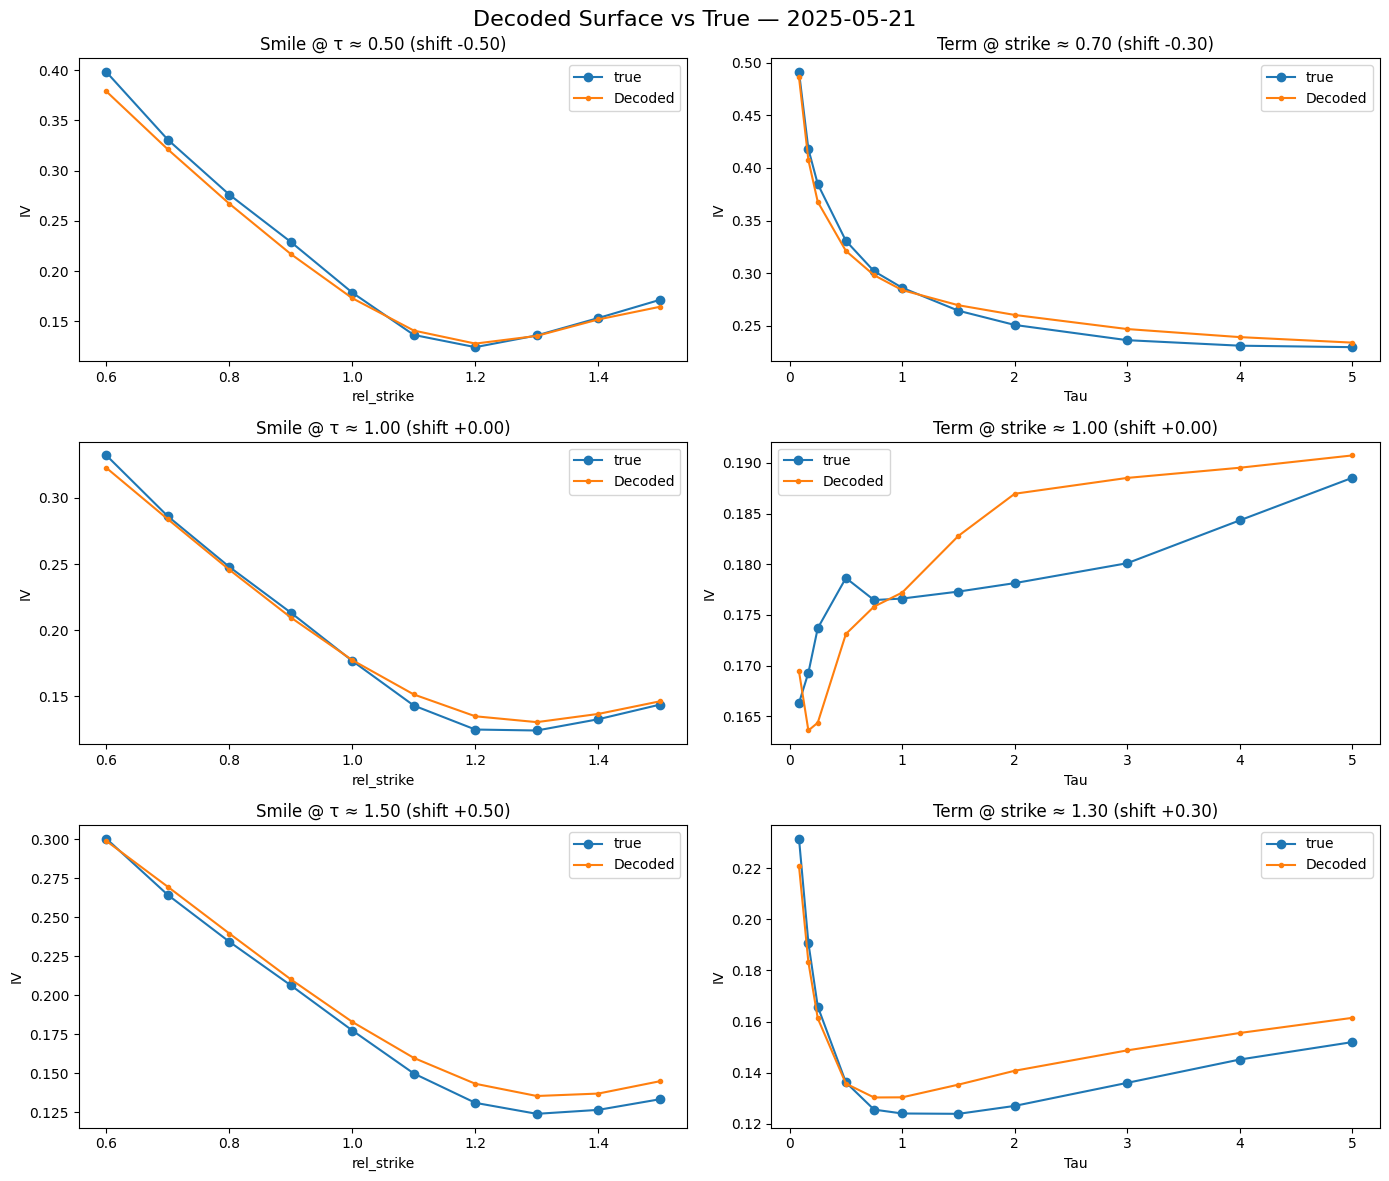

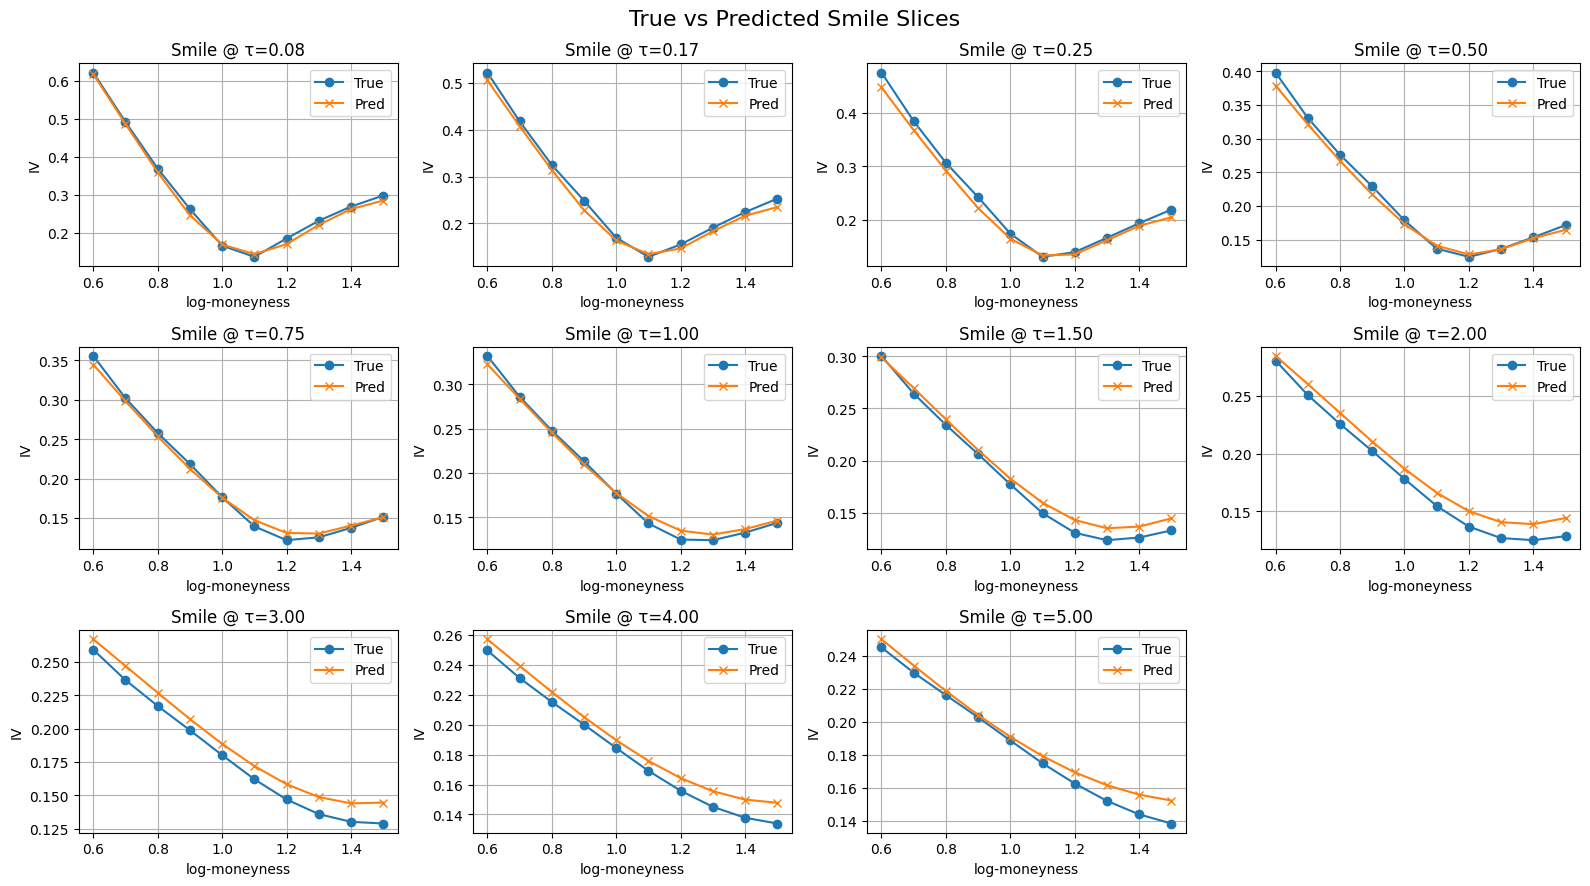

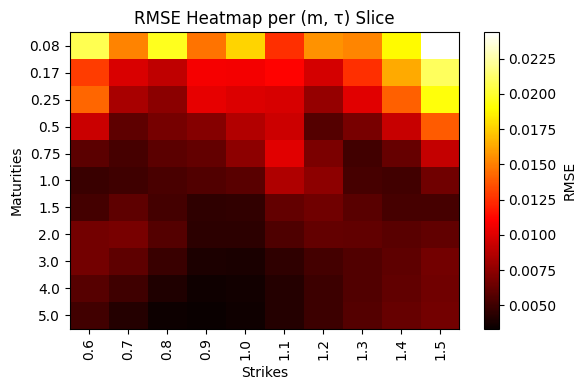

In [22]:
import models.decoder
import importlib
importlib.reload(models.decoder)

from utils.eval import evaluate_decoder_output


Z_eval = Z_decoder            # (N, latent_dim)
F_eval = F_aligned            # (N, feature_dim)
X_grid_eval = Y_decoder       # (N, M, K)


m_grid, tau_grid = np.meshgrid(
    ops.convert_to_numpy(tensors["strike_tensor"]),
    ops.convert_to_numpy(tensors["taus"])
)
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

X_pred_raw = np.stack([
    decoder_pw.predict_surface(z, f, m_flat, tau_flat)
    for z, f in zip(Z_eval, F_eval)
])


evaluate_decoder_output(
    decoder=decoder_pw,
    Z_forecast=Z_eval,
    X_grid=X_grid_eval,
    X_true_idx=None,
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoded_surfaces_override=X_pred_raw,
    title="Raw VAE–GRU (Feature-Aware Decoder)"
)


630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
residual stats: mean=-0.000214, std=0.013021
training samples: 20130
input shapes: zf=(20130, 149), m=(20130, 1), tau=(20130, 1)
Epoch 1/150
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0169 - val_loss: 0.0124 - learning_rate: 1.0000e-04
Epoch 2/150
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0148 - val_loss: 0.0169 - learning_rate: 1.0000e-04
Epoch 3/150
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0142 - val_loss: 0.0104 - learning_rate: 1.0000e-04
Epoch 4/150
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0128 - val_loss: 0.0160 - learning_rate: 1.0000e-04
Epoch 5/150
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0153 - val_loss: 0.0096 - learning_rate: 1.0000e-04
Epoch 6/150
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0102 - val_loss: 0.0123 - learning_rate: 1.0000e-04
Epoch 7/150
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0108 - val_loss: 0.0119 - learning_rate: 1.0000e-04
Epoch 8/150
535/535 ━━━━━

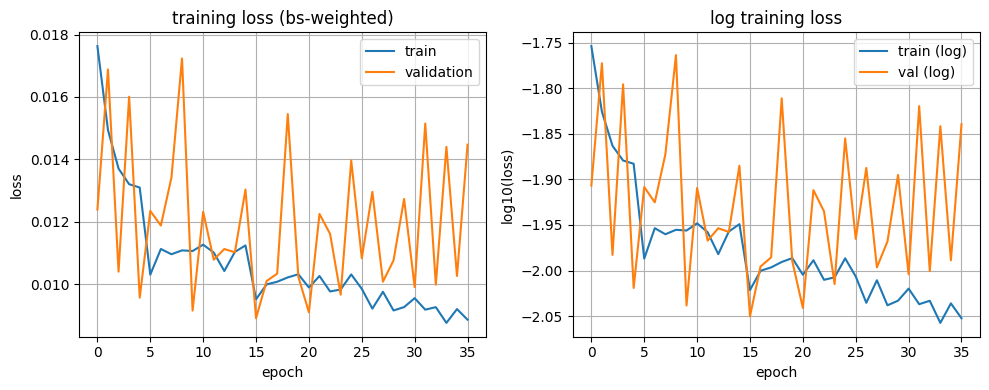

final train loss: 0.008865
final val loss: 0.014471

using black-scholes weighted loss:
  mse weight: 0.5
  vega weight: 0.3
  gamma weight: 0.2


In [23]:
import models.rl_decoder
import importlib    
importlib.reload(models.rl_decoder)

from models.rl_decoder import PointwiseRLDecoder
import os
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

# prepare (n, m, k) predicted and true surfaces
IV_pred_flat = decoder_pw.predict(X_test)  # shape: (n*m*k, 1)
IV_true_flat = y_test
N = Z_test.shape[0]
IV_pred_surf = IV_pred_flat.reshape(N, M, K)
IV_true_surf = IV_true_flat.reshape(N, M, K)

# create repeated z and f for each surface point
# z_test shape: (n, latent_dim), need to repeat for each m*k point
Z_test_repeat = np.repeat(Z_test, M * K, axis=0)  # (n*m*k, latent_dim)

# if features exist, repeat them too
if 'F_test' in locals():
   F_test_repeat = ops.convert_to_numpy(ops.repeat(F_test, M * K, axis=0))
   X_zf_rl = np.concatenate([Z_test_repeat, F_test_repeat, IV_pred_flat], axis=1)
else:
    # no features, just use z and predictions
    X_zf_rl = np.concatenate([Z_test_repeat, IV_pred_flat], axis=1)

# strike and maturity positions (should already be defined from earlier)
X_m_rl = X_m_test  # strike positions (n*m*k, 1)
X_tau_rl = X_tau_test  # maturity positions (n*m*k, 1)

use_delta = True
Y_rl = y_test - IV_pred_flat if use_delta else y_test

print(f"residual stats: mean={Y_rl.mean():.6f}, std={Y_rl.std():.6f}")
print(f"training samples: {len(Y_rl)}")
print(f"input shapes: zf={X_zf_rl.shape}, m={X_m_rl.shape}, tau={X_tau_rl.shape}")

# option to use black-scholes loss
use_bs_loss = True  # set to true to enable bs loss

if use_bs_loss:
    # create black-scholes loss function
    from models.decoder_losses import create_black_scholes_hybrid_loss
    
    bs_loss_fn, vega_weights, gamma_weights = create_black_scholes_hybrid_loss(
        taus=tensors["taus"],
        rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
        M=M, K=K,
        mse_weight=0.5,
        vega_weight=0.3,
        gamma_weight=0.2,
        S0=100,  # adjust as needed
        r=0.02,
        base_vol=0.2
    )
    
    # setup model with bs loss
    rl_model = PointwiseRLDecoder(
        use_delta=use_delta,
        normalize_delta=False,
        correction_scale=0.1,
        use_bs_loss=True,
        taus=tensors["taus"],
        rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
        M=M,
        K=K
    )
else:
    # standard mse loss
    rl_model = PointwiseRLDecoder(
        use_delta=use_delta,
        normalize_delta=False,
        correction_scale=0.1,
        use_bs_loss=False
    )

# compile model
rl_model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0))

# callbacks
os.makedirs("saved_models/rl_decoder", exist_ok=True)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=8, min_lr=1e-7),
    ModelCheckpoint("saved_models/rl_decoder/pointwise_rl_decoder.keras", save_best_only=True, verbose=0)
]

# train with proper input format - model expects 3 separate inputs
history = rl_model.fit(
    x=[X_zf_rl, X_m_rl, X_tau_rl],  # pass as list of 3 inputs
    y=Y_rl,
    validation_split=0.15,
    batch_size=BATCH_SIZE,
    epochs=150,
    callbacks=callbacks,
    verbose=1
)

# plot training curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.title("training loss" + (" (bs-weighted)" if use_bs_loss else " (mse)"))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.log10(history.history["loss"]), label="train (log)")
plt.plot(np.log10(history.history["val_loss"]), label="val (log)")
plt.title("log training loss")
plt.xlabel("epoch")
plt.ylabel("log10(loss)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"final train loss: {history.history['loss'][-1]:.6f}")
print(f"final val loss: {history.history['val_loss'][-1]:.6f}")

if use_bs_loss:
    print("\nusing black-scholes weighted loss:")
    print(f"  mse weight: 0.5")
    print(f"  vega weight: 0.3") 
    print(f"  gamma weight: 0.2")

In [24]:

split = int(0.80 * len(X_rl))
X_rl_train, X_rl_val = X_rl[:split], X_rl[split:]
Y_rl_train, Y_rl_val = Y_rl_true[:split], Y_rl_true[split:]

# fit the split into the right dims
X_zf_train, X_zf_val = X_zf_rl[:split], X_zf_rl[split:]
X_m_train, X_m_val = X_m_rl[:split], X_m_rl[split:]
X_tau_train, X_tau_val = X_tau_rl[:split], X_tau_rl[split:]

# evaluate - model needs 3 separate inputs
train_pred = rl_model.predict([X_zf_train, X_m_train, X_tau_train])
val_pred = rl_model.predict([X_zf_val, X_m_val, X_tau_val])

print(f"train prediction range: [{train_pred.min():.6f}, {train_pred.max():.6f}]")
print(f"val prediction range: [{val_pred.min():.6f}, {val_pred.max():.6f}]")
print(f"target range: [{Y_rl.min():.6f}, {Y_rl.max():.6f}]")

# flatten Y_rl_val if need
Y_rl_val_flat = Y_rl_val.reshape(-1, 1) if len(Y_rl_val.shape) > 2 else Y_rl_val
IV_pred_val = IV_pred_flat[split:].reshape(-1, 1)

# ensure matching shapes
print(f"shapes: Y_rl_val_flat={Y_rl_val_flat.shape}, IV_pred_val={IV_pred_val.shape}, val_pred={val_pred.shape}")

# rmse comparison
if use_delta:
    # for residual mode, add corrections to base predictions
    corrected_val = IV_pred_val.flatten() + val_pred.flatten()
    true_val = y_test[split:].flatten() if 'y_test' in locals() else Y_rl_val_flat.flatten() + IV_pred_val.flatten()
else:
    corrected_val = val_pred.flatten()
    true_val = Y_rl_val_flat.flatten()

# calculate rmse - using ground truth, not residuals
base_rmse = np.sqrt(np.mean((true_val - IV_pred_val.flatten())**2))
corrected_rmse = np.sqrt(np.mean((true_val - corrected_val)**2))

print(f"\nbase rmse: {base_rmse:.6f}")
print(f"corrected rmse: {corrected_rmse:.6f}")
print(f"improvement: {(base_rmse - corrected_rmse) / base_rmse * 100:.2f}%")

335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
train prediction range: [-0.010446, 0.020000]
val prediction range: [-0.010548, 0.020000]
target range: [-0.063820, 0.076929]
shapes: Y_rl_val_flat=(26760, 1), IV_pred_val=(9430, 1), val_pred=(9430, 1)

base rmse: 0.012170
corrected rmse: 0.009250
improvement: 24.00%


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
decoder + rl correction (pointwise - delta) RMSE_σ: 0.0077
RMSE by maturity (mean ± std): 0.0082 ± 0.0041
RMSE by strike    (mean ± std): 0.0088 ± 0.0025


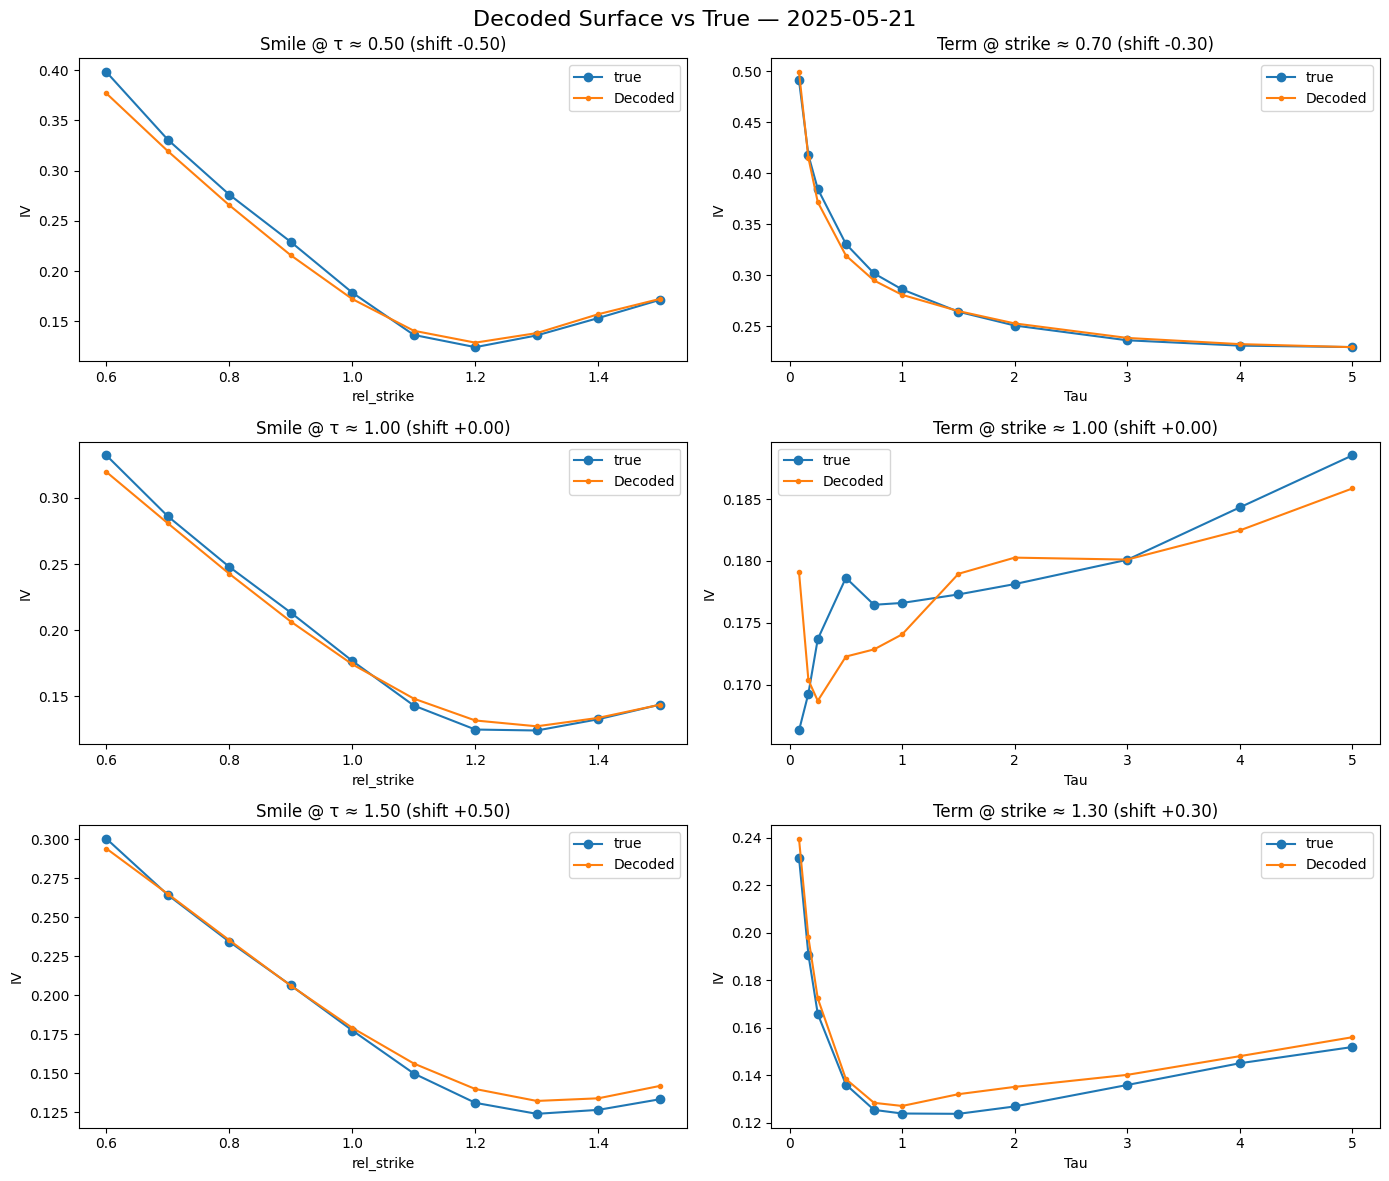

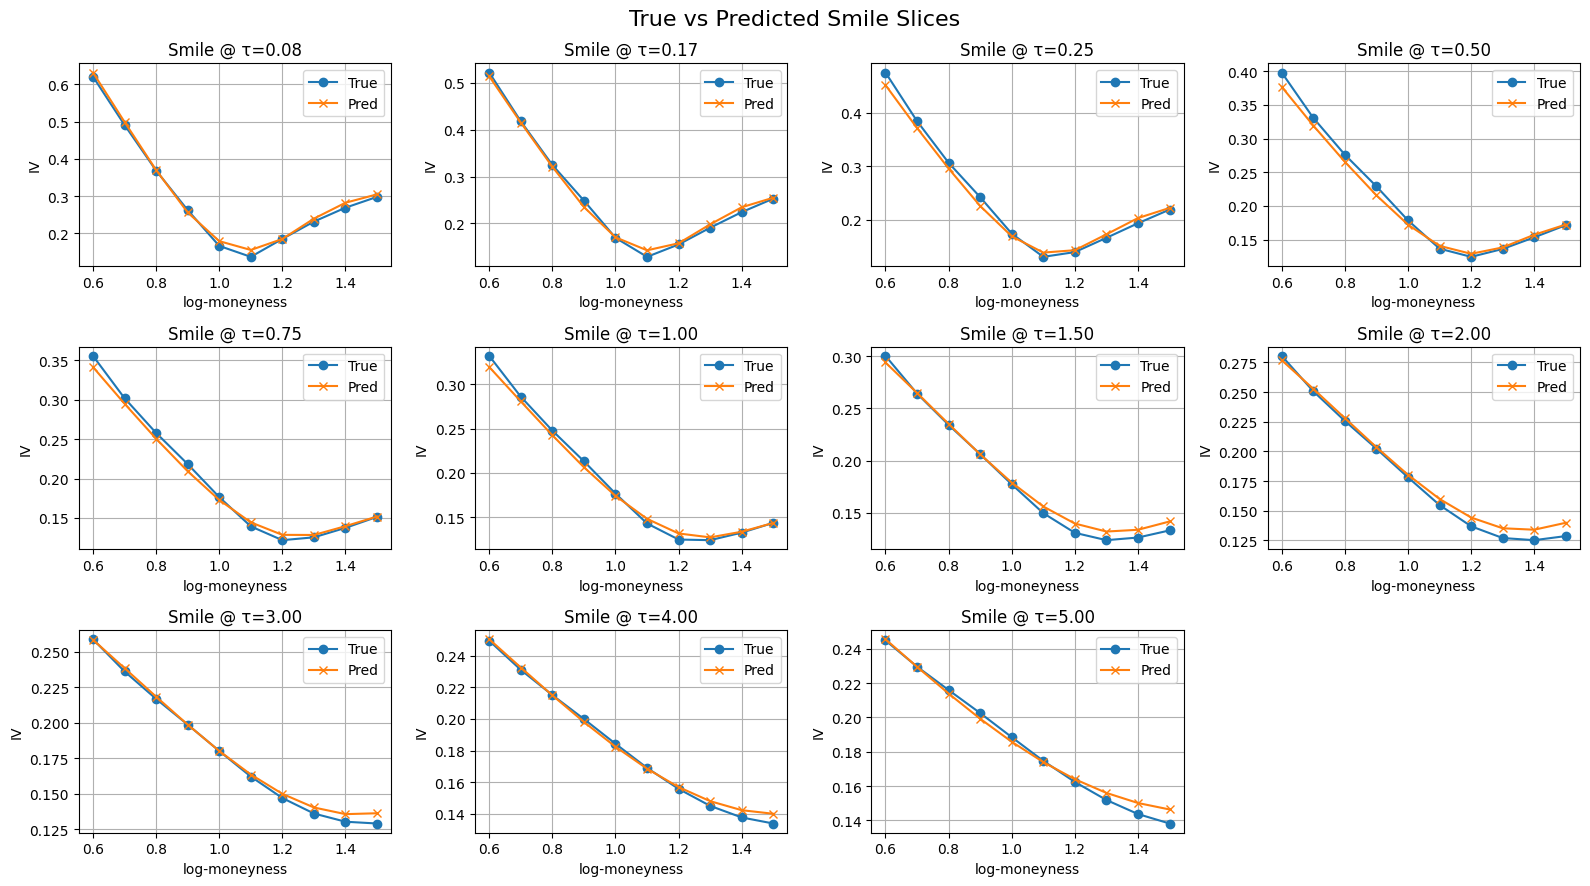

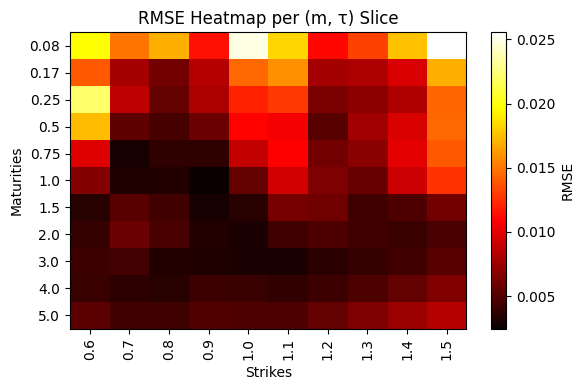

In [25]:
# predict raw decoder surfaces
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

X_pred_raw = np.stack([
    decoder_pw.predict_surface(z, f, m_flat, tau_flat)
    for z, f in zip(Z_test, F_test)
])

# apply pointwise rl correction
# prepare the three separate inputs for rl model
Z_test_repeat_rl = ops.convert_to_numpy(ops.repeat(Z_test, M * K, axis=0))
F_test_repeat_rl = ops.convert_to_numpy(ops.repeat(F_test, M * K, axis=0)) if 'F_test' in locals() else None

if F_test_repeat_rl is not None:
    X_zf_test = np.concatenate([Z_test_repeat_rl, F_test_repeat_rl, IV_pred_flat], axis=1)
else:
    X_zf_test = np.concatenate([Z_test_repeat_rl, IV_pred_flat], axis=1)

# predict with 3 separate inputs
delta_rl = rl_model.predict([X_zf_test, X_m_test, X_tau_test], batch_size=128)

if rl_model.use_delta:
    IV_corrected_flat = IV_pred_flat + delta_rl
else:
    IV_corrected_flat = delta_rl

X_pred_rl = IV_corrected_flat.reshape(Z_test.shape[0], M, K)

# evaluate
evaluate_decoder_output(
    decoder=decoder_pw,
    Z_forecast=Z_test,
    X_grid=Y_test.reshape(-1, M, K),
    X_true_idx=None,
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoded_surfaces_override=X_pred_rl,
    title="decoder + rl correction (pointwise - delta)" if use_delta else "decoder + rl correction (pointwise - absolute)"
)

slice dataset shapes:
  x_train: (1811, 10, 1), y_train: (1811, 10, 1)
  x_val: (202, 10, 1), y_val: (202, 10, 1)
  each slice: (K=10, 1)
Epoch 1/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5991e-04 - val_loss: 2.3857e-04 - learning_rate: 1.0000e-06
Epoch 2/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4417e-04 - val_loss: 2.1246e-04 - learning_rate: 1.0000e-06
Epoch 3/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2227e-04 - val_loss: 1.8943e-04 - learning_rate: 1.0000e-06
Epoch 4/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9887e-04 - val_loss: 1.6911e-04 - learning_rate: 1.0000e-06
Epoch 5/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7093e-04 - val_loss: 1.5280e-04 - learning_rate: 1.0000e-06
Epoch 6/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6213e-04 - val_loss: 1.3962e-04 - learning_rate: 1.0000e-06
Epoch 7/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4838e-04 - val_loss: 1.2623e-04 - learning_rate: 1.0000e-06
Epoch 8/500
29/

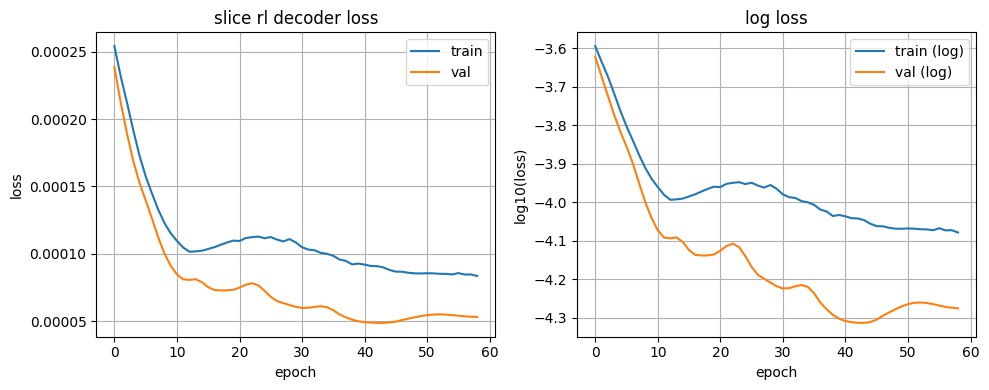


final train loss: 0.000083
final val loss: 0.000053


In [26]:
from models.rl_decoder import SliceRLDecoder, build_slice_dataset
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
import os

# slice training input from pointwise-corrected surface
X_rl_slice, Y_rl_slice = build_slice_dataset(X_pred_rl, selected_taus=None)
_, Y_rl_true_slice = build_slice_dataset(Y_test.reshape(-1, M, K), selected_taus=None)

# define slice correction model
rl_slice_model = SliceRLDecoder(
   K=K, 
   use_cnn=True,  # use cnn architecture
   mode="residual",  # residual learning mode
   lambda_convexity=0.1,  # convexity penalty
   alpha=1e-2  # delta penalty weight
)
rl_slice_model.compile(optimizer=Adam(1e-6))

# callbacks
os.makedirs("saved_models/rl_decoder", exist_ok=True)
callbacks = [
   EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
   ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=10, min_lr=1e-8),
   ModelCheckpoint("saved_models/rl_decoder/slice_after_pointwise.keras", save_best_only=True)
]

# train split
split = int(0.9 * len(X_rl_slice))
X_train, X_val = X_rl_slice[:split], X_rl_slice[split:]
Y_train, Y_val = Y_rl_true_slice[:split], Y_rl_true_slice[split:]

print(f"slice dataset shapes:")
print(f"  x_train: {X_train.shape}, y_train: {Y_train.shape}")
print(f"  x_val: {X_val.shape}, y_val: {Y_val.shape}")
print(f"  each slice: (K={K}, 1)")

# fit
history = rl_slice_model.fit(
   x=X_train,
   y=Y_train,
   validation_data=(X_val, Y_val),
   batch_size=64,
   epochs=500,
   callbacks=callbacks,
   verbose=1
)

# plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("slice rl decoder loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.log10(history.history["loss"]), label="train (log)")
plt.plot(np.log10(history.history["val_loss"]), label="val (log)")
plt.title("log loss")
plt.xlabel("epoch")
plt.ylabel("log10(loss)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nfinal train loss: {history.history['loss'][-1]:.6f}")
print(f"final val loss: {history.history['val_loss'][-1]:.6f}")

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Decoder + RL (Pointwise → Slice) RMSE_σ: 0.0080
RMSE by maturity (mean ± std): 0.0084 ± 0.0036
RMSE by strike    (mean ± std): 0.0089 ± 0.0019


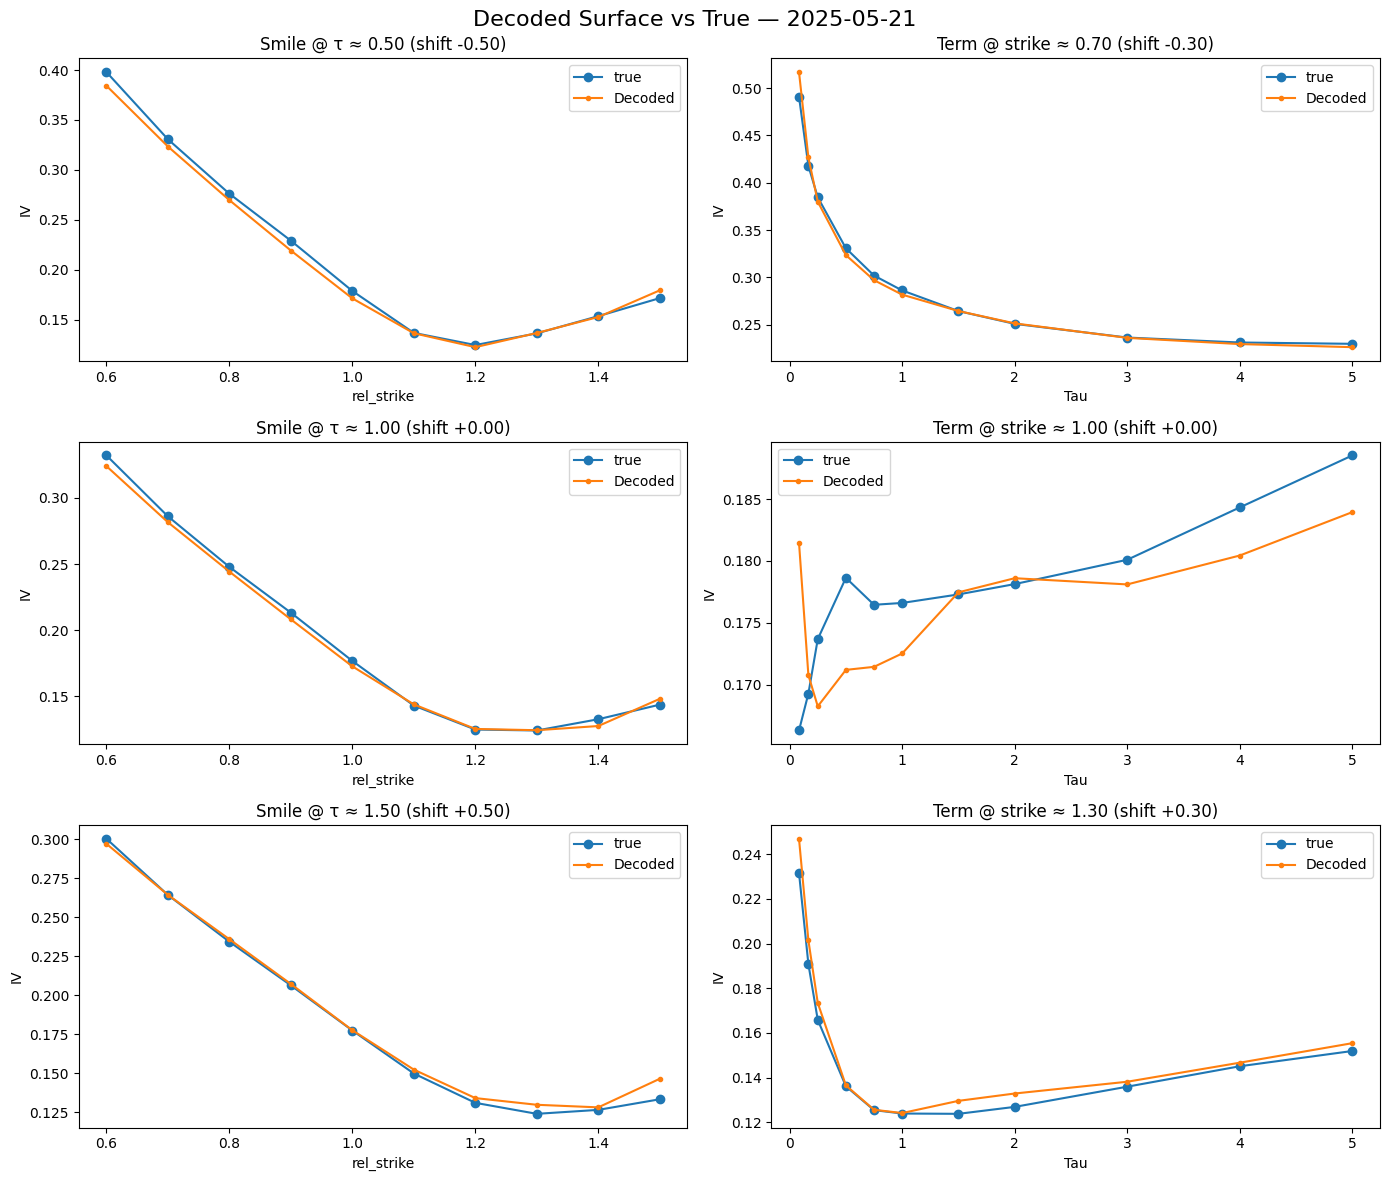

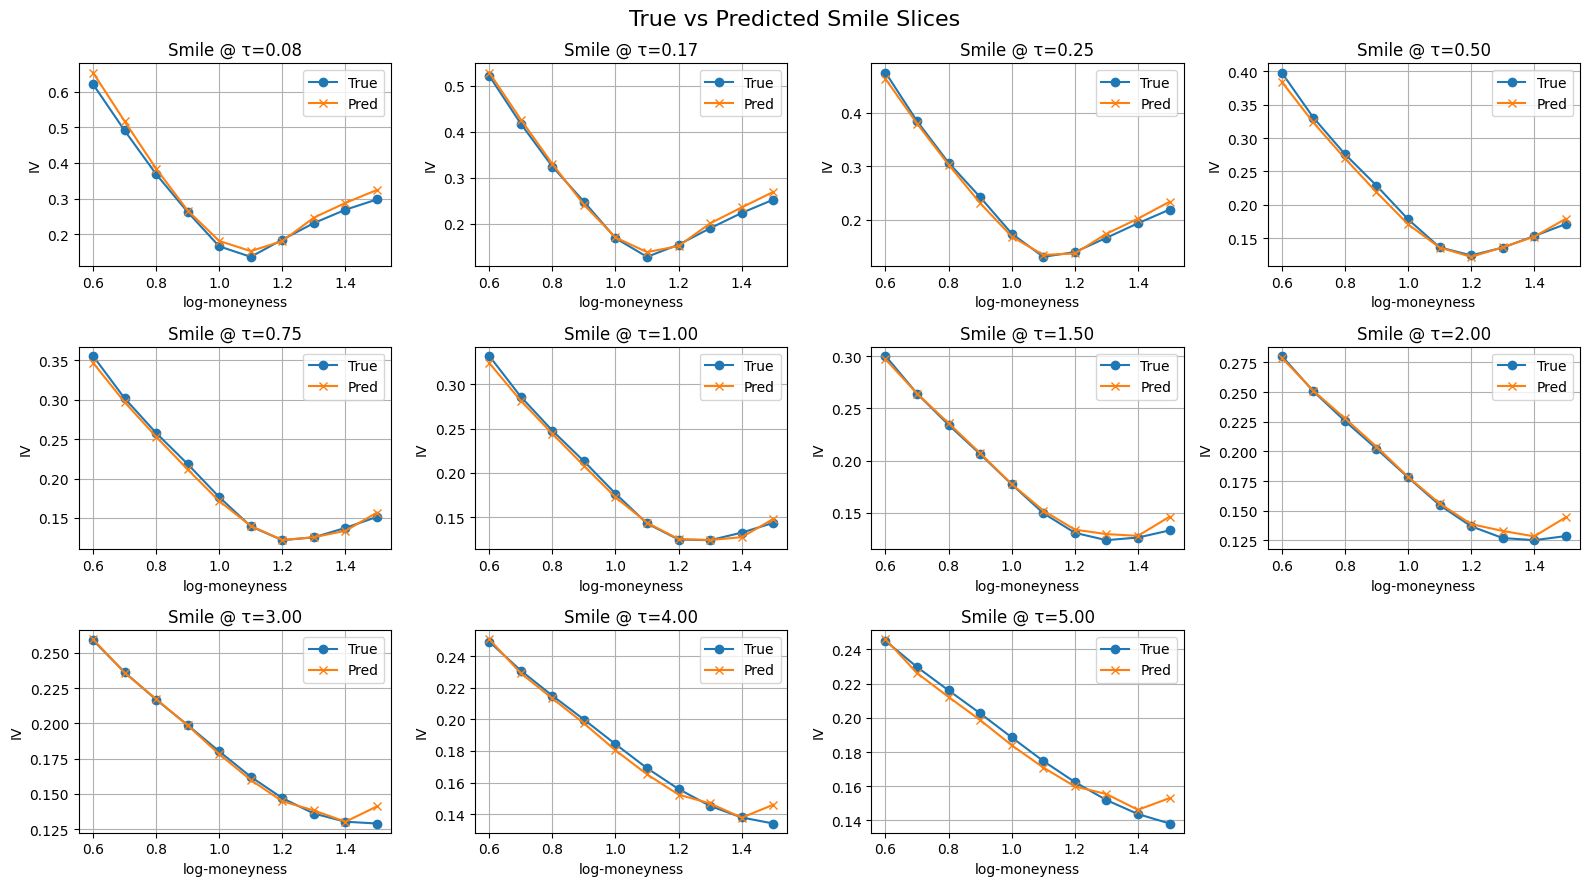

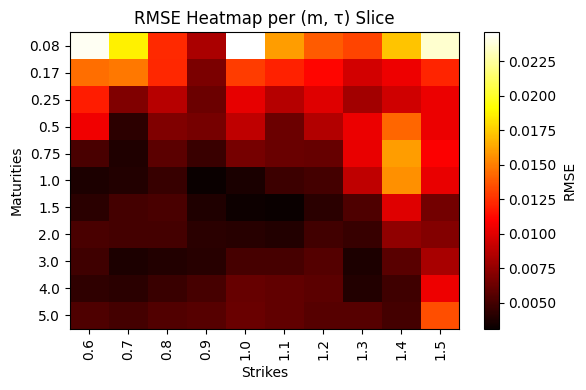

In [27]:
from utils.eval import evaluate_decoder_output

#  raw surfaces
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

X_pred_raw = np.stack([
    decoder_pw.predict_surface(z, f, m_flat, tau_flat)
    for z, f in zip(Z_test, F_test)
])  # shape: (N, M, K)

#  pointwise RL correction
# Use the same input format as training for PointwiseRLDecoder
delta_rl = rl_model.predict([X_zf_test, X_m_test, X_tau_test], batch_size=128)
IV_corrected_flat = IV_pred_flat + delta_rl if use_delta else delta_rl
X_pred_rl = IV_corrected_flat.reshape(Z_test.shape[0], M, K)

#  Apply slice RL correction
X_rl_slice = X_pred_rl.reshape(-1, K, 1)
delta_slice = rl_slice_model.predict(X_rl_slice, batch_size=128)
X_pred_rl_final = (X_rl_slice + delta_slice).reshape(Z_test.shape[0], M, K)

# corrected surface (pointwise + slice)
evaluate_decoder_output(
    decoder=decoder_pw,
    Z_forecast=Z_test,
    X_grid=Y_test.reshape(-1, M, K),
    X_true_idx=None,
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoded_surfaces_override=X_pred_rl_final,
    title="Decoder + RL (Pointwise → Slice)"
)


generated 3 residual-sensitive regions
region keys: ['region_high_gamma', 'region_wings', 'region_safe']


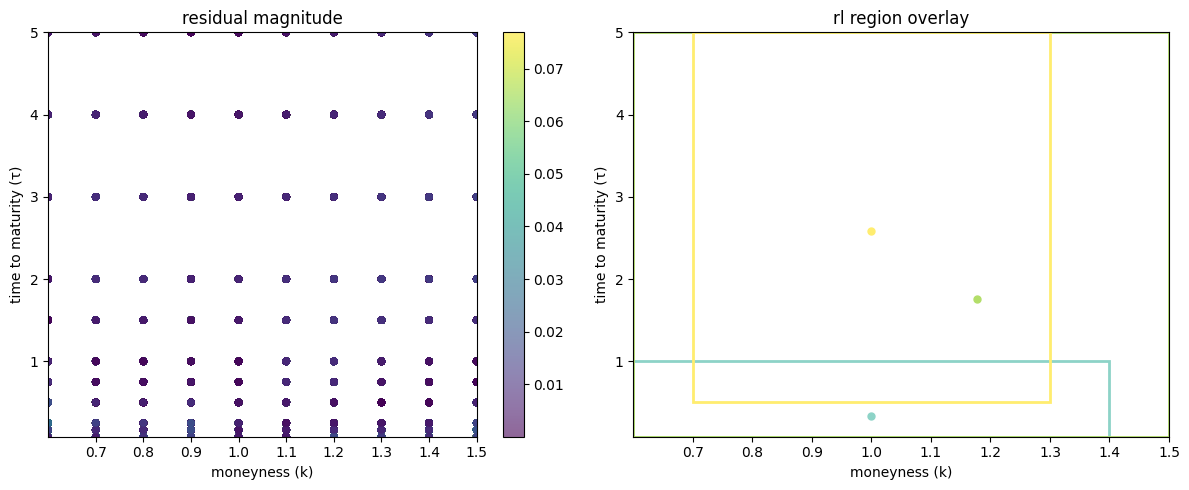

[region_high_gamma] region rmse: 0.0148
[region_wings] region rmse: 0.0163
[region_safe] region rmse: 0.0081
[region_high_gamma] training on 6222 samples
[region_wings] training on 5673 samples
[region_safe] training on 8235 samples


In [28]:
import importlib
import models.rl_decoder
import utils.pointwise_router

importlib.reload(models.rl_decoder)
importlib.reload(utils.pointwise_router)

from models.rl_decoder import PointwiseRLDecoder
from utils.pointwise_router import PointwiseCorrectionRouter
from utils.pointwise_router import generate_residual_masks, visualize_residual_regions

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import matplotlib.pyplot as plt

# build rl inputs - keep as list of 3 arrays for pointwiserl
X_rl = [IV_pred_flat, X_m_test, X_tau_test]  # [features, strikes, maturities]
use_delta = True
Y_rl = y_test - IV_pred_flat if use_delta else y_test

# extract flattened coordinates for visualization
k_vals = X_m_test.flatten()
tau_vals = X_tau_test.flatten()
residuals = (y_test - IV_pred_flat).flatten()

region_config = {
  "method": "gamma_based",
  "bins_k": 4,                
  "bins_tau": 4,              
  "quantile_thresholds": (0, 1),  
  "n_clusters": 12,
  "max_depth": 3,
  "min_samples": 100,
  "improvement_threshold": 0.001,
  "error_threshold": 0.02,
  "atm_lower": 0.9,
  "atm_upper": 1.10,
  "tau_short": 0.12,
  "tau_mid": 3, 
}

region_masks, region_centers, aux_info, _ = generate_residual_masks(
  k_vals=k_vals,
  tau_vals=tau_vals,
  residuals=residuals,
  **region_config
)

print(f"generated {len(region_masks)} residual-sensitive regions")
print("region keys:", list(region_masks.keys()))

if region_config["method"] == "grid":
  visualize_residual_regions(k_vals, tau_vals, residuals, aux_info, region_masks)
else:
  visualize_residual_regions(k_vals, tau_vals, residuals, region_masks=region_masks)

# instantiate rl router using residual-based masks
router = PointwiseCorrectionRouter(
  region_masks=region_masks,
  region_centers=region_centers,
  model_cls=PointwiseRLDecoder,
  model_kwargs={"use_delta": use_delta, "normalize_delta": False, "correction_scale": 0.25}
)

router.true_targets = Y_rl

# add rmse-proportional scaling
global_residuals = Y_rl
router.global_residuals = global_residuals.flatten()

router.region_rmse = {}
for name, mask in region_masks.items():
  if np.any(mask):
      router.region_rmse[name] = np.sqrt(np.mean(global_residuals[mask]**2))
      print(f"[{name}] region rmse: {router.region_rmse[name]:.4f}")

# compile and train
router.compile_all(optimizer_fn=lambda: Adam(learning_rate=5e-5, clipnorm=1.0))
callbacks = [
  EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
  ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=10, min_lr=1e-9)
]

# fit with list of 3 arrays
router.fit_all(
  X_rl,  # now [IV_pred_flat, X_m_test, X_tau_test]
  Y_rl,
  batch_size=BATCH_SIZE,
  epochs=200,
  validation_split=0.2,
  callbacks=callbacks,
  verbose=0
)

# save all region-specific decoders
router.save_all("saved_models/rl_decoder/pointwise_rl_{name}.keras")

[region_high_gamma] mask count: 6222
[region_wings] mask count: 5673
[region_safe] mask count: 8235
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


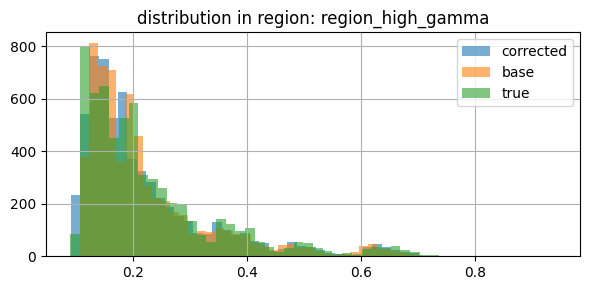

[region_high_gamma] rmse (base): 0.014844217
[region_high_gamma] rmse (corrected): 0.013455016
X_mask shapes: [(6222, 1), (6222, 1), (6222, 1)]
delta_mask stats: -0.02 0.019608784 -0.0026220728
base_mask stats: 0.10555688 0.89815116
input X_rl shapes: [(20130, 1), (20130, 1), (20130, 1)]
number of trained models: 3
Y_rl stats: -0.063820064 0.076928675 -0.0002138644 0.013021468


In [29]:
for name, mask in region_masks.items():
    print(f"[{name}] mask count: {np.sum(mask)}")

# select region to debug
region_name = "region_high_gamma"  # change to your desired region name
mask = router.masks[region_name]
model = router.models[region_name]

# slice inputs - maintain list structure for pointwiserl
if isinstance(X_rl, list):
    # X_rl is [IV_pred_flat, X_m_test, X_tau_test]
    X_mask = [x[mask] for x in X_rl]  # slice each array in the list
else:
    X_mask = X_rl[mask]

Y_true_mask = y_test[mask]  # true flat iv
base_mask = IV_pred_flat[mask]  # base prediction

# predict delta - pass list of 3 arrays
delta_mask = model.predict(X_mask, batch_size=BATCH_SIZE)

# apply correction
use_delta = getattr(model, "use_delta", True)
IV_corrected_mask = base_mask + delta_mask if use_delta else delta_mask

# debug statistics
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
plt.hist(ops.convert_to_numpy(IV_corrected_mask).flatten(), bins=50, alpha=0.6, label="corrected")
plt.hist(ops.convert_to_numpy(base_mask).flatten(), bins=50, alpha=0.6, label="base")
plt.hist(ops.convert_to_numpy(Y_true_mask).flatten(), bins=50, alpha=0.6, label="true")
plt.title(f"distribution in region: {region_name}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# rmse comparison
rmse = lambda x, y: np.sqrt(np.mean((ops.convert_to_numpy(x) - ops.convert_to_numpy(y)) ** 2))
print(f"[{region_name}] rmse (base):", rmse(base_mask, Y_true_mask))
print(f"[{region_name}] rmse (corrected):", rmse(IV_corrected_mask, Y_true_mask))

# debug shapes
if isinstance(X_mask, list):
    print("X_mask shapes:", [x.shape for x in X_mask])
else:
    print("X_mask shape:", X_mask.shape)
    
delta_numpy = ops.convert_to_numpy(delta_mask)
print("delta_mask stats:", delta_numpy.min(), delta_numpy.max(), delta_numpy.mean())

base_numpy = ops.convert_to_numpy(base_mask)
print("base_mask stats:", base_numpy.min(), base_numpy.max())

# router info
if isinstance(X_rl, list):
    print(f"input X_rl shapes: {[x.shape for x in X_rl]}")
else:
    print(f"input X_rl shape: {X_rl.shape}")
    
print(f"number of trained models: {len(router.trained_models)}")

Y_rl_numpy = ops.convert_to_numpy(Y_rl)
print("Y_rl stats:", Y_rl_numpy.min(), Y_rl_numpy.max(), Y_rl_numpy.mean(), Y_rl_numpy.std())

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Decoder + RL Correction (Soft Blend) RMSE_σ: 0.0126
RMSE by maturity (mean ± std): 0.0132 ± 0.0052
RMSE by strike    (mean ± std): 0.0138 ± 0.0035


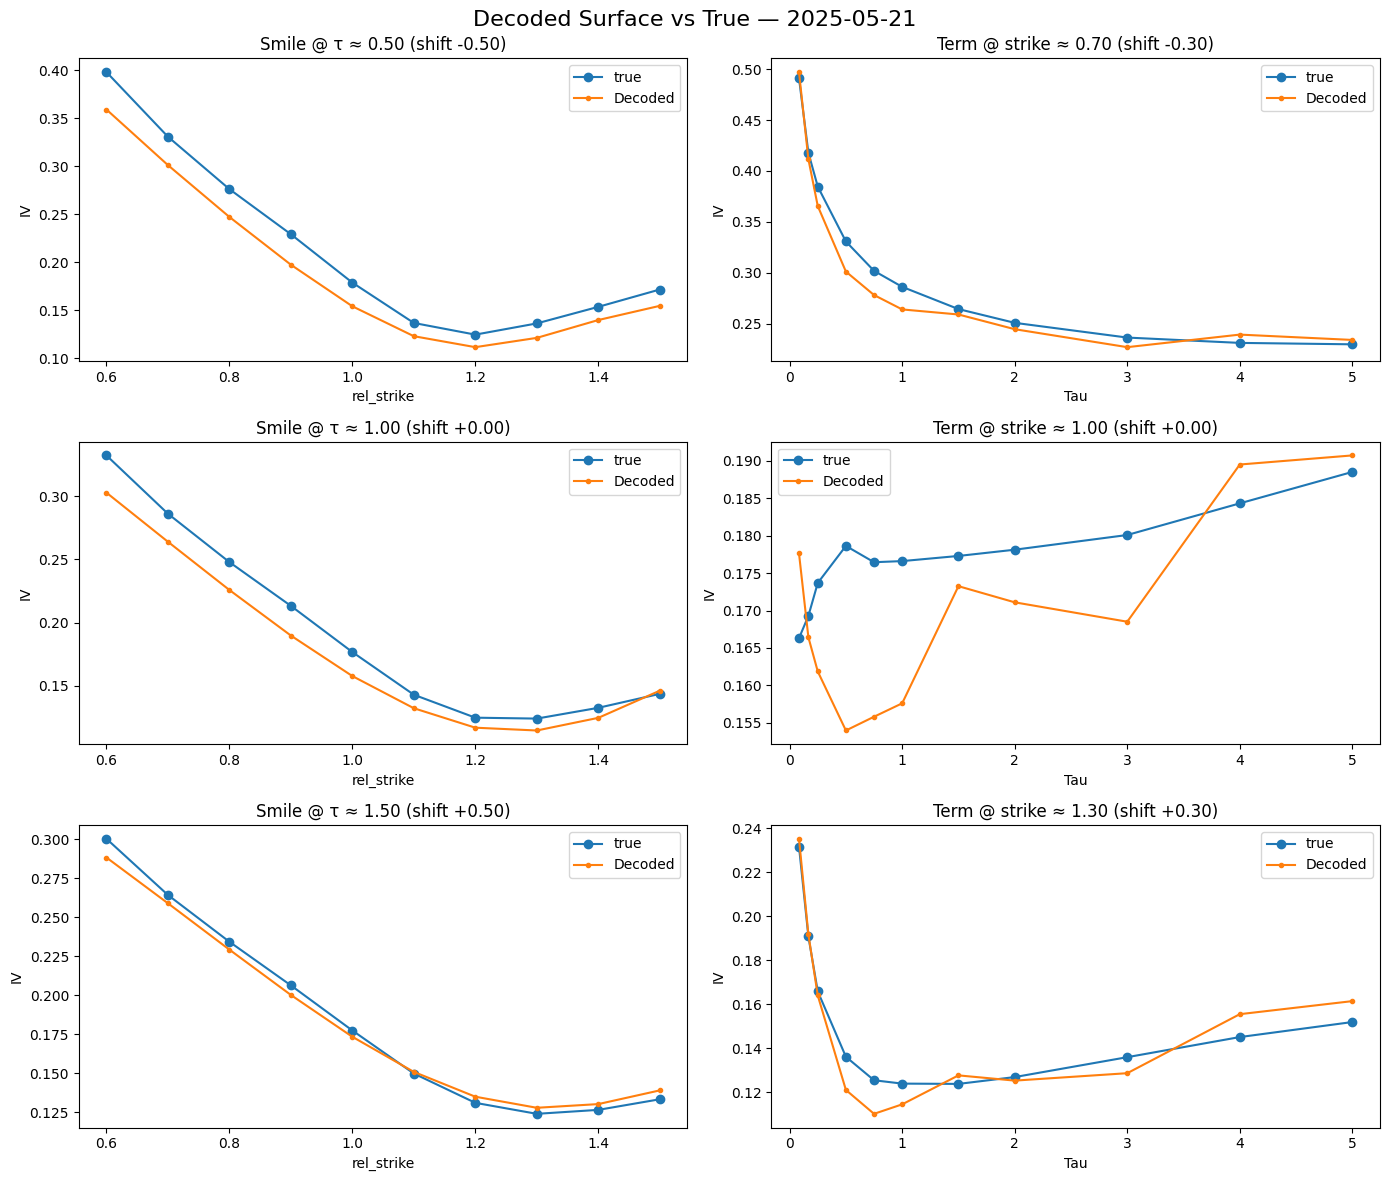

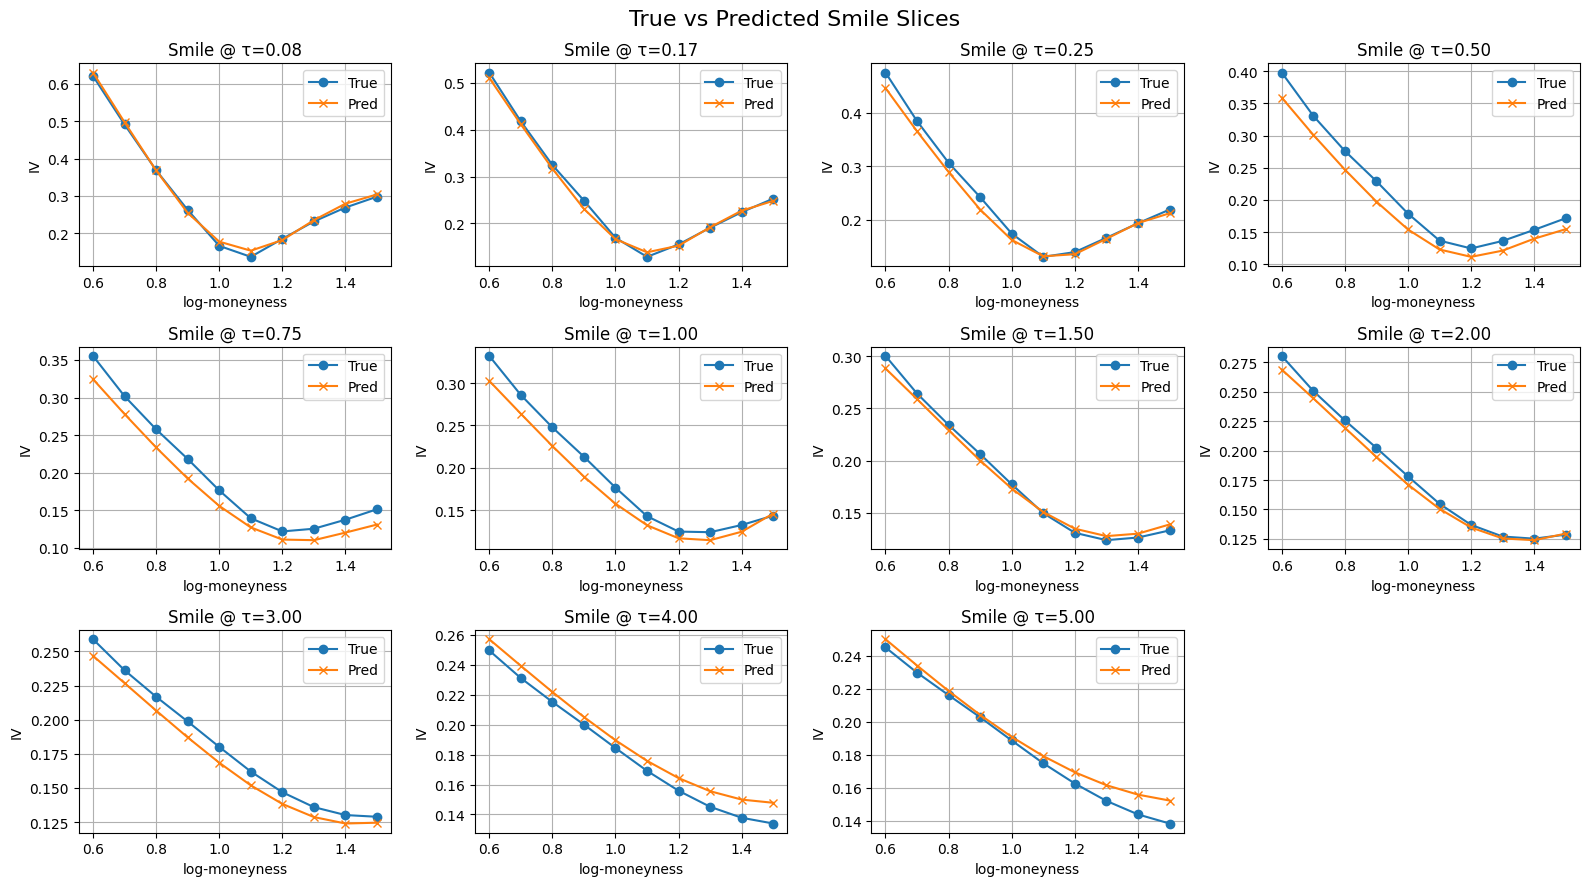

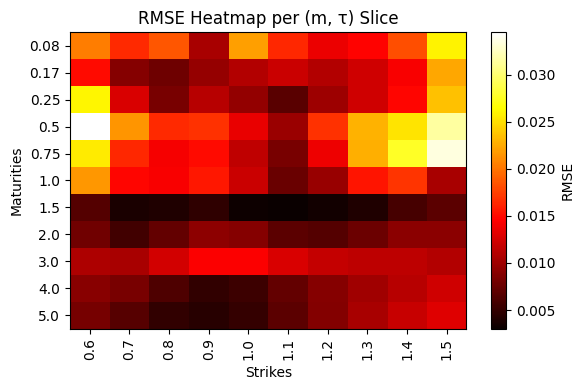

input shapes: IV_pred_flat=(20130, 1), X_m_test=(20130, 1), X_tau_test=(20130, 1)
corrected shape: (20130, 1)
final surface shape: (183, 11, 10)


In [30]:
import importlib
import utils.pointwise_router
importlib.reload(utils.pointwise_router)

from utils.pointwise_router import visualize_residual_regions

# predict raw decoder surfaces
m_flat = m_grid.reshape(-1, 1).astype(np.float32)
tau_flat = tau_grid.reshape(-1, 1).astype(np.float32)

X_pred_raw = np.stack([
    decoder_pw.predict_surface(z, f, m_flat, tau_flat)
    for z, f in zip(Z_test, F_test)
])

# prepare inputs for pointwise rl - keep as list of 3 arrays
IV_pred_flat = X_pred_raw.reshape(-1, 1)

# create list format for pointwiserl decoder
# order: [features, strikes, maturities]
X_rl_pointwise = [IV_pred_flat, X_m_test, X_tau_test]  

# soft vs hard routing toggle
use_soft_blend = True

if use_soft_blend:
    # coordinates for gaussian router
    X_coord = np.concatenate([X_m_test, X_tau_test], axis=1)
    
    # router with gaussian weighting
    IV_corrected_flat = router.predict(
        X_full=X_rl_pointwise,  # list of 3 arrays
        X_coord=X_coord,
        base=IV_pred_flat,
        sigma=0.15  # adjust sigma for blending radius
    )
else:
    # fallback: direct patching from trained regions
    # for hard routing, you might need x_coord too
    X_coord = np.concatenate([X_m_test, X_tau_test], axis=1)
    IV_corrected_flat = router.predict(
        X_full=X_rl_pointwise,  # list of 3 arrays
        X_coord=X_coord,  # still needed for region centers
        base=IV_pred_flat
    )

# reshape corrected predictions
X_pred_rl = IV_corrected_flat.reshape(Z_test.shape[0], M, K)

# evaluate results
evaluate_decoder_output(
    decoder=decoder_pw,
    Z_forecast=Z_test,
    X_grid=Y_test.reshape(-1, M, K),
    X_true_idx=None,
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoded_surfaces_override=X_pred_rl,
    title="Decoder + RL Correction (Soft Blend)" if use_soft_blend else "Decoder + Routed RL Correction"
)

# debug info
print(f"input shapes: IV_pred_flat={IV_pred_flat.shape}, X_m_test={X_m_test.shape}, X_tau_test={X_tau_test.shape}")
print(f"corrected shape: {IV_corrected_flat.shape}")
print(f"final surface shape: {X_pred_rl.shape}")

In [31]:
import importlib
import models.rl_decoder
import utils.pointwise_router
import pandas as pd
import time

importlib.reload(models.rl_decoder)
importlib.reload(utils.pointwise_router)

from models.rl_decoder import PointwiseRLDecoder
from utils.pointwise_router import PointwiseCorrectionRouter
from utils.pointwise_router import generate_residual_masks

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

IV_pred_flat = X_pred_raw.reshape(-1, 1)
X_rl = [IV_pred_flat, X_m_test, X_tau_test]
use_delta = True
Y_rl = y_test - IV_pred_flat if use_delta else y_test

k_vals = X_m_test.flatten()
tau_vals = X_tau_test.flatten()
residuals = (y_test - IV_pred_flat).flatten()

methods_to_test = [
   "grid", "fixed_grid", "atm_term_structure", "gamma_based", "adaptive_error"
]

base_config = {
   "bins_k": 4,                
   "bins_tau": 4,              
   "n_clusters": 8,
   "min_samples": 100,
   "error_threshold": 0.02,
   "atm_lower": 0.9,
   "atm_upper": 1.10,
   "tau_short": 0.5,
   "tau_mid": 2.0, 
}

results = []
baseline_rmse = 0.0068

print("testing methods...")

for method in methods_to_test:
   print(f"\n{method}")
   start_time = time.time()
   
   try:
       region_config = base_config.copy()
       region_config["method"] = method
       
       region_masks, region_centers, aux_info, _ = generate_residual_masks(
           k_vals=k_vals,
           tau_vals=tau_vals,
           residuals=residuals,
           **region_config
       )
       
       n_regions = len(region_masks)
       valid_regions = {name: mask for name, mask in region_masks.items() 
                       if np.sum(mask) >= base_config["min_samples"]}
       
       if len(valid_regions) < 2:
           print(f"  skip - {len(valid_regions)} regions")
           continue
           
       print(f"  {n_regions} regions, {len(valid_regions)} valid")
       
       router = PointwiseCorrectionRouter(
           region_masks=region_masks,
           region_centers=region_centers,
           model_cls=PointwiseRLDecoder,
           model_kwargs={"use_delta": use_delta, "normalize_delta": False, "correction_scale": 0.1}
       )
       
       router.compile_all(optimizer_fn=lambda: Adam(learning_rate=5e-5, clipnorm=1.0))
       callbacks = [
           EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
           ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=5, min_lr=1e-8)
       ]
       
       router.fit_all(
           X_rl,
           Y_rl,
           batch_size=128,
           epochs=100,
           validation_split=0.2,
           callbacks=callbacks,
           verbose=0
       )
       
       X_pred_raw_eval = np.stack([
           decoder_pw.predict_surface(z, f, m_flat, tau_flat)
           for z, f in zip(Z_test, F_test)
       ])
       
       IV_pred_flat_eval = X_pred_raw_eval.reshape(-1, 1)
       X_rl_pointwise = [IV_pred_flat_eval, X_m_test, X_tau_test]
       X_coord = np.concatenate([X_m_test, X_tau_test], axis=1)
       
       IV_corrected_flat = router.predict(
           X_full=X_rl_pointwise,
           X_coord=X_coord,
           base=IV_pred_flat_eval
       )
       
       final_rmse = np.sqrt(np.mean((y_test.flatten() - IV_corrected_flat.flatten())**2))
       improvement = (baseline_rmse - final_rmse) / baseline_rmse * 100
       
       print(f"  rmse: {final_rmse:.6f} ({improvement:+.1f}%)")
       
       results.append({
           'method': method,
           'rmse': final_rmse,
           'improvement': improvement,
           'n_regions': len(valid_regions),
           'time': time.time() - start_time
       })
       
   except Exception as e:
       print(f"  error: {str(e)[:50]}")

df_results = pd.DataFrame(results)
if not df_results.empty:
   df_results = df_results.sort_values('rmse', ascending=True)
   
   print(f"\nbaseline: {baseline_rmse:.6f}")
   print("\nresults:")
   for _, row in df_results.iterrows():
       print(f"{row['method']:20s} | {row['rmse']:.6f} | "
             f"{row['improvement']:+5.1f}% | "
             f"{row['n_regions']:2d} | "
             f"{row['time']:4.1f}s")
   
   best = df_results.iloc[0]
   print(f"\nbest: {best['method']}")
   print(f"{best['rmse']:.6f} ({best['improvement']:+.1f}%)")

testing methods...

grid
  17 regions, 17 valid
[region_0_0] training on 3294 samples
[region_0_1] training on 1098 samples
[region_0_2] training on 549 samples
[region_0_3] training on 549 samples
[region_1_0] training on 2196 samples
[region_1_1] training on 732 samples
[region_1_2] training on 366 samples
[region_1_3] training on 366 samples
[region_2_0] training on 2196 samples
[region_2_1] training on 732 samples
[region_2_2] training on 366 samples
[region_2_3] training on 366 samples
[region_3_0] training on 2196 samples
[region_3_1] training on 732 samples
[region_3_2] training on 366 samples
[region_3_3] training on 366 samples
[region_fallback_0] training on 3660 samples
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
158/158 ━━━━━━━━━━━━━━━

### we need option related adjustment and decoding in line with option theory 

coordinates: rel_strikes (10,), taus (11,)
original y_decoder shape: (1216, 110)
y_surface_flat shape: (1216, 110)

split shapes:
train: z=(851, 12), f=torch.Size([851, 136]), y=(851, 110)
val: z=(182, 12), f=torch.Size([182, 136]), y=(182, 110)

pointwise data shapes:
x_train: zf=(93610, 148), m=(93610, 1), tau=(93610, 1)
y_train: (93610, 1)
Epoch 1/200
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0502 - val_loss: 0.0098 - learning_rate: 1.0000e-05
Epoch 2/200
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0061 - val_loss: 0.0042 - learning_rate: 1.0000e-05
Epoch 3/200
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0028 - val_loss: 0.0028 - learning_rate: 1.0000e-05
Epoch 4/200
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0023 - val_loss: 0.0027 - learning_rate: 1.0000e-05
Epoch 5/200
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0021 - val_loss: 0.0025 - learning_rate: 1.0000e-05
Epoch 6/200
2926/2926 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0

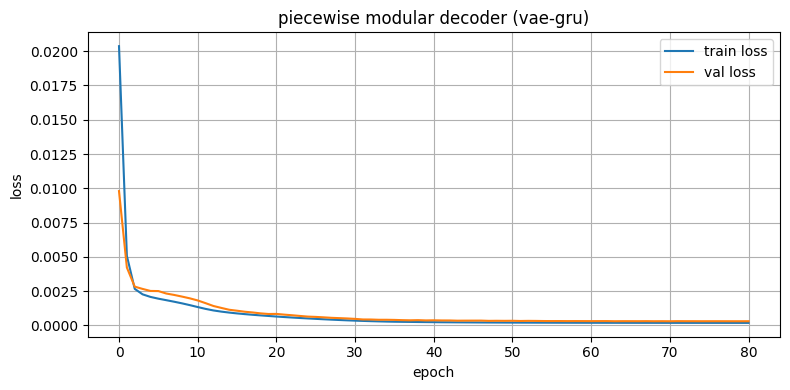

In [32]:
import models.decoder
import importlib
importlib.reload(models.decoder)

from models.decoder import PiecewiseSurfaceDecoderModular
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import matplotlib.pyplot as plt

# prepare coordinate arrays for surface grid
rel_strikes = ops.convert_to_numpy(tensors["rel_strikes"]).flatten()  # shape (K,)
taus = ops.convert_to_numpy(tensors["taus"]).flatten()  # shape (M,)
print(f"coordinates: rel_strikes {rel_strikes.shape}, taus {taus.shape}")

# fix y_decoder shape mismatch - ensure it matches z_decoder sample count
print(f"original y_decoder shape: {Y_decoder.shape}")
if Y_decoder.shape[0] == Z_decoder.shape[0] * M:
   # y_decoder is (n*m, k) - reshape to (n, m, k)
   Y_surface_full = Y_decoder.reshape(Z_decoder.shape[0], M, K)
   print(f"reshaped y_decoder from {Y_decoder.shape} to {Y_surface_full.shape}")
else:
   # y_decoder already correct shape
   Y_surface_full = Y_decoder.reshape(Z_decoder.shape[0], M, K)

# flatten surfaces to (n, m*k) for pointwise decoder
Y_surface_flat = Y_surface_full.reshape(Z_decoder.shape[0], M * K)
print(f"y_surface_flat shape: {Y_surface_flat.shape}")

# train/val/test split with corrected data
N_total = len(Z_decoder)
train_split = int(0.7 * N_total)
val_split = int(0.85 * N_total)

Z_train, Z_val, Z_test = np.split(Z_decoder, [train_split, val_split])
F_train, F_val, F_test = np.split(F_aligned, [train_split, val_split])
Y_train, Y_val, Y_test = np.split(Y_surface_flat, [train_split, val_split])

print(f"\nsplit shapes:")
print(f"train: z={Z_train.shape}, f={F_train.shape}, y={Y_train.shape}")
print(f"val: z={Z_val.shape}, f={F_val.shape}, y={Y_val.shape}")

# instantiate modular pointwise decoder
decoder_pw_mod = PiecewiseSurfaceDecoderModular(
   latent_dim=LATENT_DIM,
   M=M,
   K=K,
   feature_dim=F_aligned.shape[1],
   activation="gelu",
   use_layernorm=False,
   dropout_rate=0.0,
   m_expand=False,
   tau_expand=False,
   atm_weighting=True
)

# build pointwise training data - converts surfaces to individual points
[X_zf_train, X_m_train, X_tau_train], y_train_pw = decoder_pw_mod.build_training_data_from_surfaces(
   Z_latent=Z_train,
   Y_surface_flat=Y_train,  # now correctly shaped (n_train, m*k)
   strike_tensor=rel_strikes,
   tau_tensor=taus,
   F_features=F_train
)

[X_zf_val, X_m_val, X_tau_val], y_val_pw = decoder_pw_mod.build_training_data_from_surfaces(
   Z_latent=Z_val,
   Y_surface_flat=Y_val,
   strike_tensor=rel_strikes,
   tau_tensor=taus,
   F_features=F_val
)

# package as list inputs for keras
X_train_pw = [X_zf_train, X_m_train, X_tau_train]
X_val_pw = [X_zf_val, X_m_val, X_tau_val]

print(f"\npointwise data shapes:")
print(f"x_train: zf={X_zf_train.shape}, m={X_m_train.shape}, tau={X_tau_train.shape}")
print(f"y_train: {y_train_pw.shape}")

# compile and configure training
decoder_pw_mod.compile(optimizer=Adam(learning_rate=1e-5), loss="mse")

os.makedirs("saved_models/piecewise_surface_mod", exist_ok=True)
callbacks = [
   EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
   ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=5),
   ModelCheckpoint("saved_models/piecewise_surface_mod/decoder.keras", save_best_only=True)
]

# train pointwise decoder
history = decoder_pw_mod.fit(
   X_train_pw,  # list of [x_zf, x_m, x_tau]
   y_train_pw,
   validation_data=(X_val_pw, y_val_pw),
   batch_size=BATCH_SIZE,
   epochs=200,
   callbacks=callbacks,
   verbose=1
)

# visualize training progress
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title("piecewise modular decoder (vae-gru)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

raw vae-gru (modular pw decoder) RMSE_σ: 0.0134
RMSE by maturity (mean ± std): 0.0138 ± 0.0073
RMSE by strike    (mean ± std): 0.0154 ± 0.0025


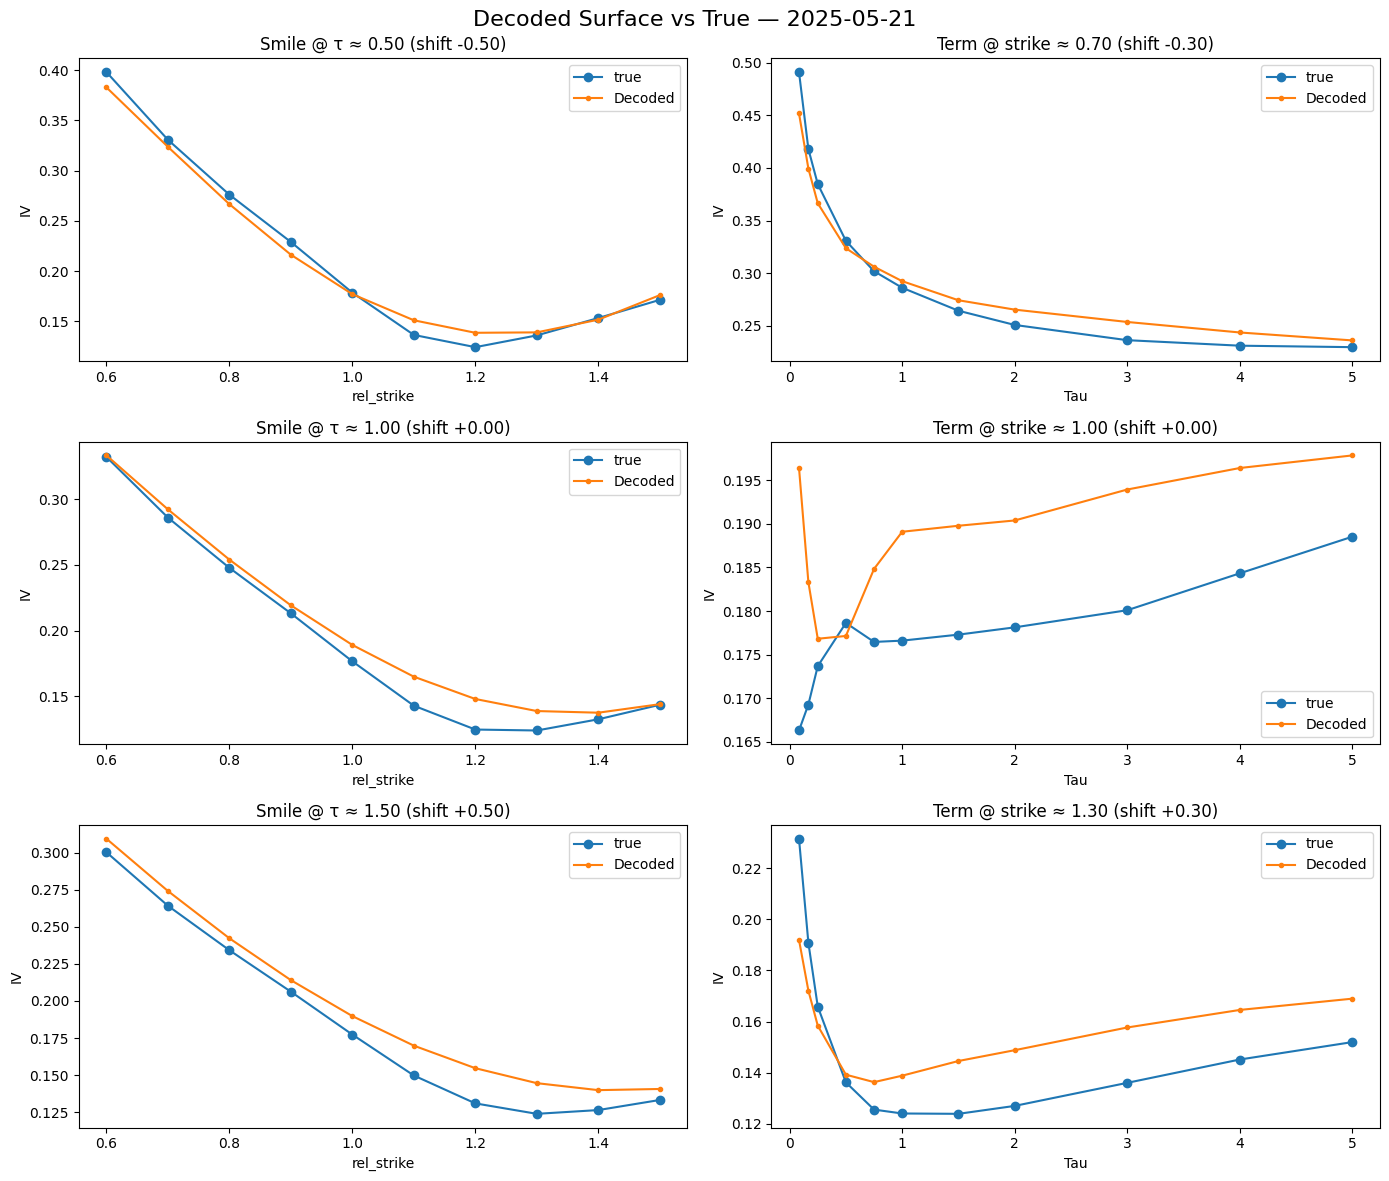

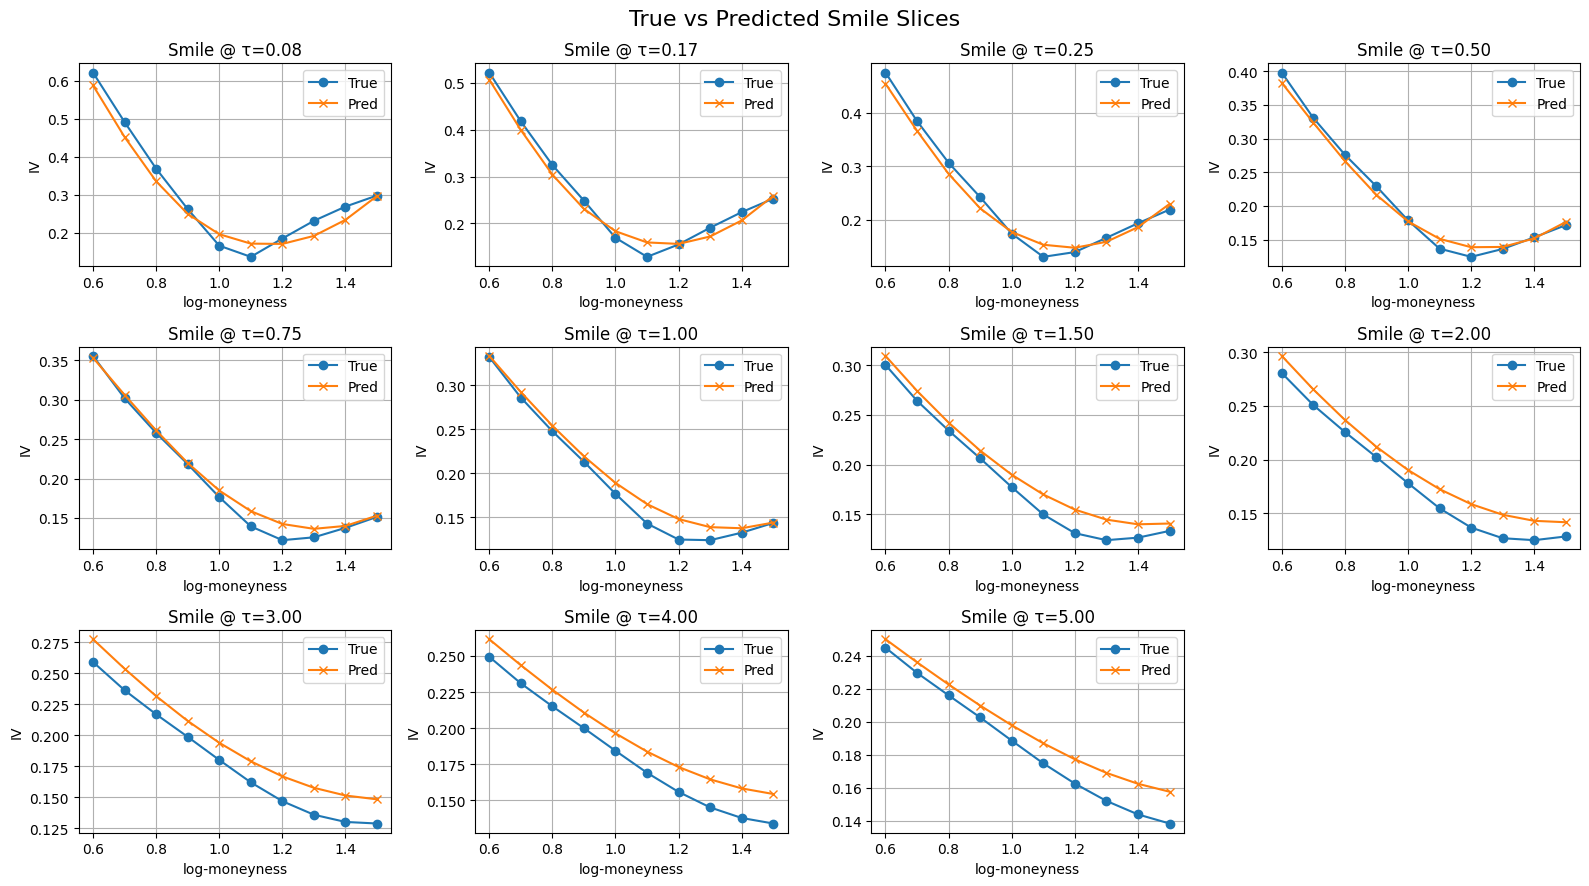

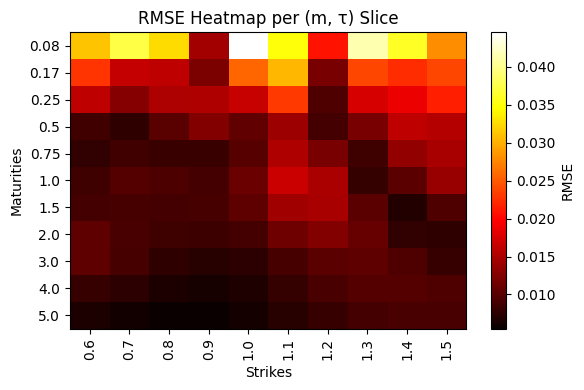

In [33]:
from utils.eval import evaluate_decoder_output

# select evaluation subset
Z_eval = Z_decoder
X_grid_eval = Y_decoder
F_eval = F_aligned

# predict full surface per latent z (reshape to m x k)
X_pred_raw_mod = np.stack([
   decoder_pw_mod.predict_surface(z, f, m_flat, tau_flat)
   for z, f in zip(Z_eval, F_eval)
])

# evaluate decoded surfaces
evaluate_decoder_output(
   decoder=decoder_pw_mod,
   Z_forecast=Z_eval,
   X_grid=X_grid_eval,
   X_true_idx=None,
   tensors=tensors,
   rel_strikes=rel_strikes,
   taus=taus,
   target_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
   decoded_surfaces_override=X_pred_raw_mod,
   title="raw vae-gru (modular pw decoder)"
)

smoothed vae-gru (piecewise modular) RMSE_σ: 0.0328
RMSE by maturity (mean ± std): 0.0390 ± 0.0341
RMSE by strike    (mean ± std): 0.0433 ± 0.0283


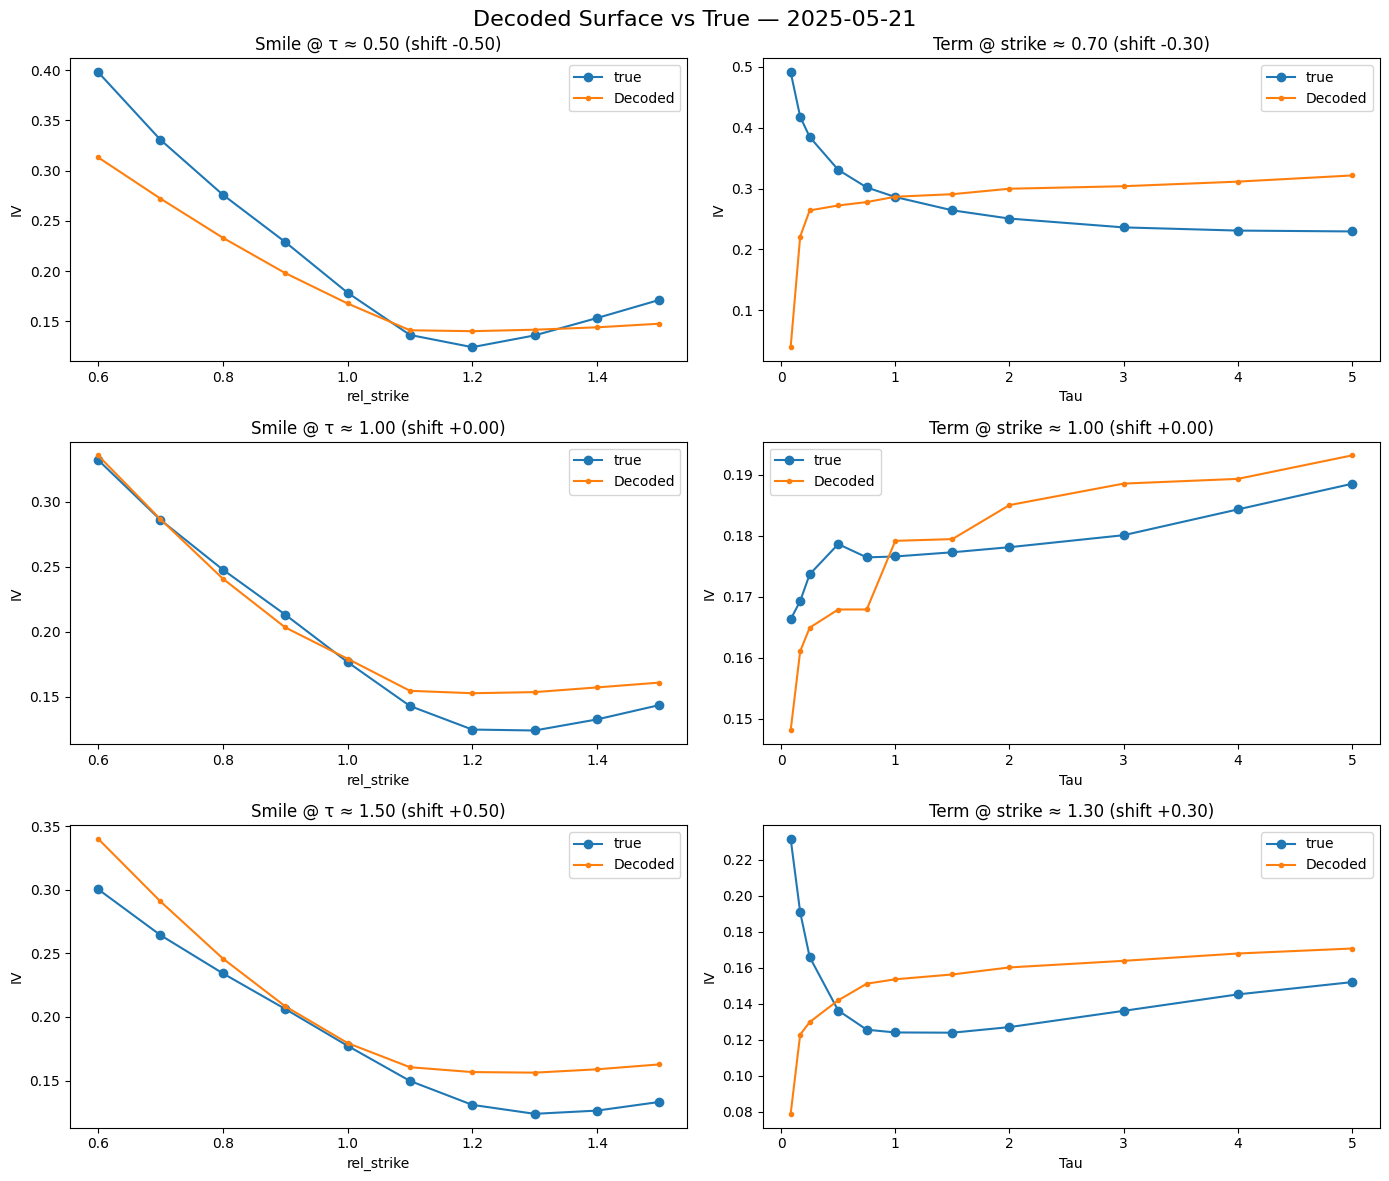

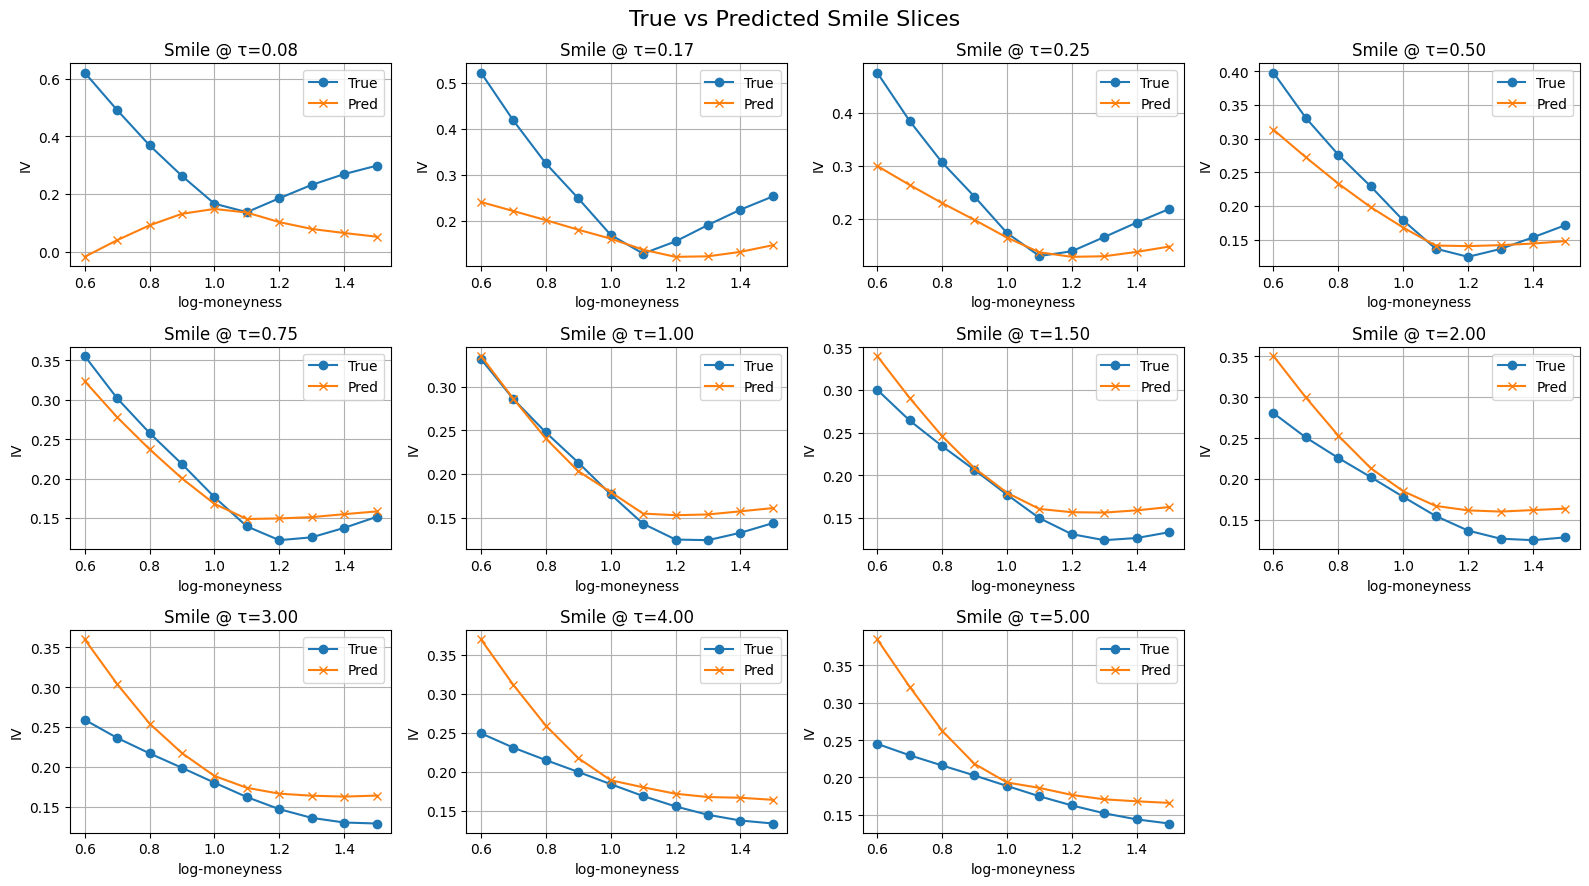

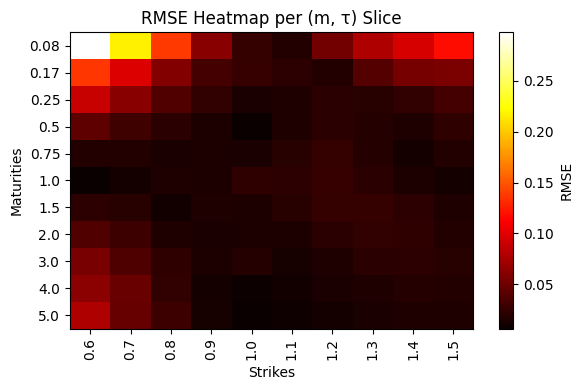

In [34]:
import importlib
import utils.eval
importlib.reload(utils.eval)

from utils.eval import evaluate_decoder_output

# config
SMOOTH_ALL = False
N_surfaces = 10


Z_eval = Z_decoder if SMOOTH_ALL else Z_decoder[-N_surfaces:]
F_eval = F_aligned if SMOOTH_ALL else F_aligned[-N_surfaces:]
X_grid_eval = Y_decoder if SMOOTH_ALL else Y_decoder[-N_surfaces:]

# predict surfaces from z + f
X_pred_mod = np.stack([
   decoder_pw_mod.predict_surface(z, f, m_flat, tau_flat)
   for z, f in zip(Z_eval, F_eval)
])

# apply surface refinement
X_pred_mod_smooth = np.stack([
   decoder_pw_mod.refine_surface(surf, lambda_cal=1.0, lambda_smile=1.0)
   for surf in X_pred_mod
])


evaluate_decoder_output(
   decoder=decoder_pw_mod,
   Z_forecast=Z_eval,
   X_grid=X_grid_eval,
   X_true_idx=None,
   tensors=tensors,
   rel_strikes=rel_strikes,
   taus=taus,
   target_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
   decoded_surfaces_override=X_pred_mod_smooth,
   title="smoothed vae-gru (piecewise modular)"
)

---
---
### CNN Expeiments 

original y_decoder shape: (1216, 110)
reshaped y_surface: (1216, 11, 10)
zf_decoder shape: (1216, 148)
train shapes: zf=(851, 148), y=(851, 11, 10)
val shapes: zf=(182, 148), y=(182, 11, 10)
Epoch 1/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2137 - val_loss: 0.2142 - learning_rate: 1.0000e-04
Epoch 2/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1425 - val_loss: 0.0436 - learning_rate: 1.0000e-04
Epoch 3/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0148 - val_loss: 0.0071 - learning_rate: 1.0000e-04
Epoch 4/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075 - val_loss: 0.0104 - learning_rate: 1.0000e-04
Epoch 5/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - val_loss: 0.0086 - learning_rate: 1.0000e-04
Epoch 6/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - val_loss: 0.0080 - learning_rate: 1.0000e-04
Epoch 7/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - val_loss: 0.0077 - learning_rate: 1.0000e-04
Epoch 8/300
27/27

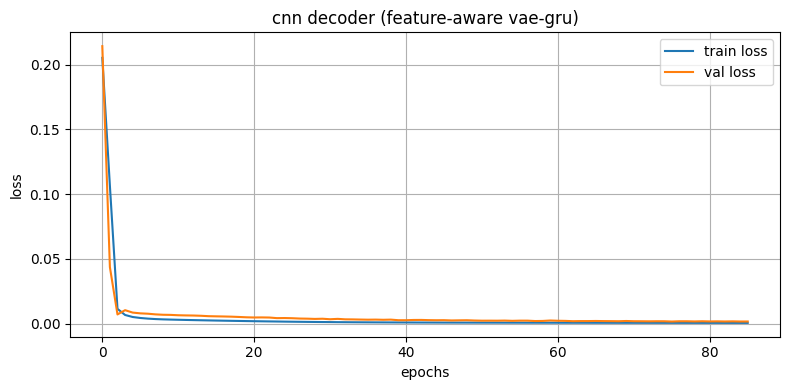

In [35]:
import models.cnn
import importlib
importlib.reload(models.cnn)

from models.cnn import CNNDecoder
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import matplotlib.pyplot as plt

# prepare data - fix shape mismatch
print(f"original y_decoder shape: {Y_decoder.shape}")
if Y_decoder.shape[0] == Z_decoder.shape[0] * M:
   # y_decoder is (n*m, k) - reshape to (n, m, k)
   Y_surface_reshaped = Y_decoder.reshape(Z_decoder.shape[0], M, K)
else:
   # y_decoder already has correct samples
   Y_surface_reshaped = Y_decoder.reshape(-1, M, K)
print(f"reshaped y_surface: {Y_surface_reshaped.shape}")

# combine z and features
F_aligned_np = ops.convert_to_numpy(F_aligned)
ZF_decoder = np.concatenate([Z_decoder, F_aligned_np], axis=-1)
print(f"zf_decoder shape: {ZF_decoder.shape}")

# train/val split
N_total = len(ZF_decoder)
train_split = int(0.7 * N_total)
val_split = int(0.85 * N_total)

ZF_train = ZF_decoder[:train_split]
ZF_val = ZF_decoder[train_split:val_split]
Y_train = Y_surface_reshaped[:train_split]
Y_val = Y_surface_reshaped[train_split:val_split]

print(f"train shapes: zf={ZF_train.shape}, y={Y_train.shape}")
print(f"val shapes: zf={ZF_val.shape}, y={Y_val.shape}")

# instantiate cnn decoder
decoder_cnn = CNNDecoder(
   latent_dim=LATENT_DIM,
   feature_dim=F_aligned_np.shape[1],
   M=M,
   K=K
)
decoder_cnn.compile(optimizer=Adam(learning_rate=1e-4), loss="mse")

# callbacks
os.makedirs("saved_models/cnn_surface", exist_ok=True)
callbacks = [
   EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
   ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=5),
   ModelCheckpoint("saved_models/cnn_surface/decoder.keras", save_best_only=True)
]

# train
history_cnn = decoder_cnn.fit(
   ZF_train, Y_train,
   validation_data=(ZF_val, Y_val),
   batch_size=32,
   epochs=300,
   callbacks=callbacks,
   verbose=1
)

# plot training history
plt.figure(figsize=(8, 4))
plt.plot(history_cnn.history["loss"], label="train loss")
plt.plot(history_cnn.history["val_loss"], label="val loss")
plt.title("cnn decoder (feature-aware vae-gru)")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

raw vae-gru (feature-aware cnn decoder) RMSE_σ: 0.0288
RMSE by maturity (mean ± std): 0.0295 ± 0.0042
RMSE by strike    (mean ± std): 0.0295 ± 0.0045


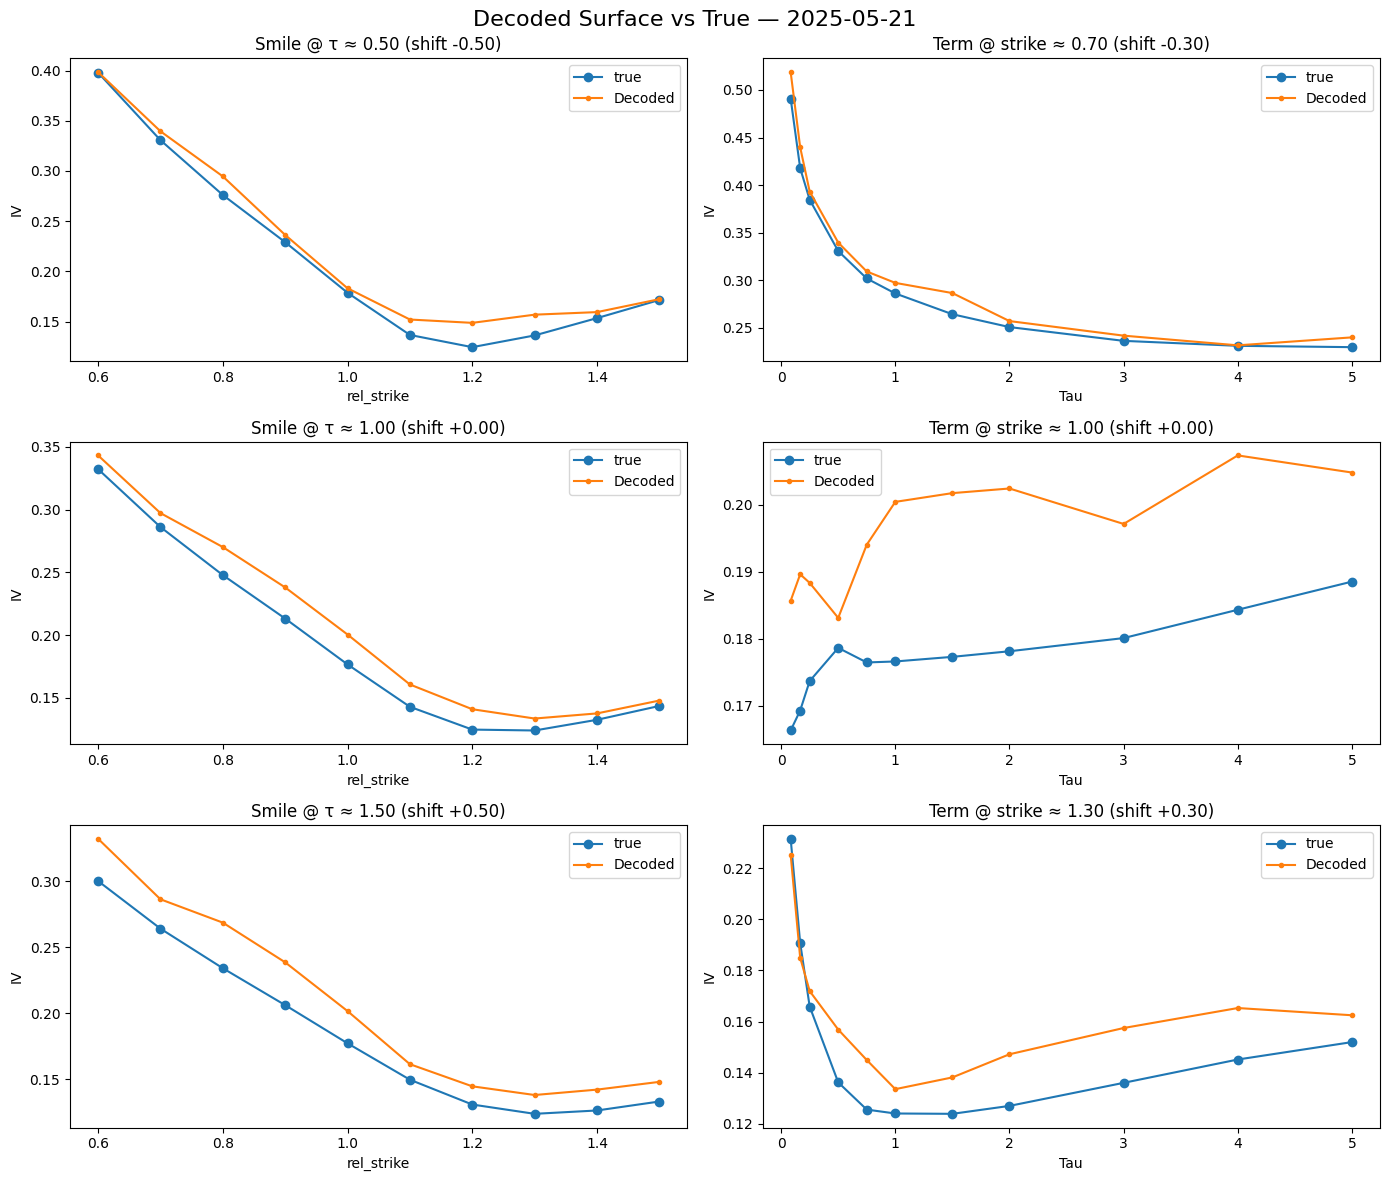

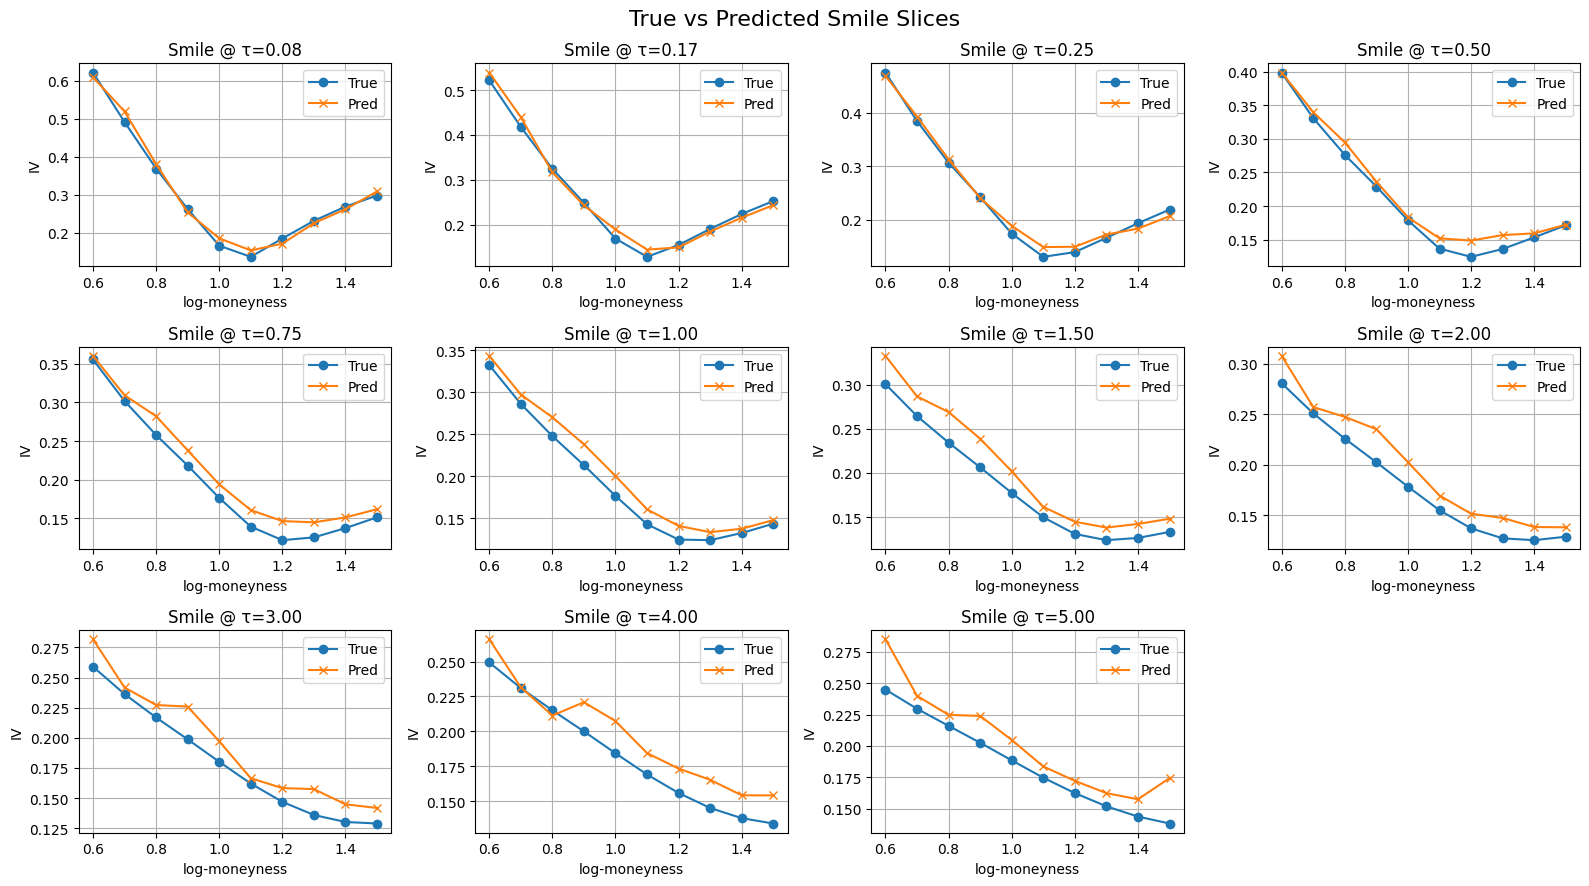

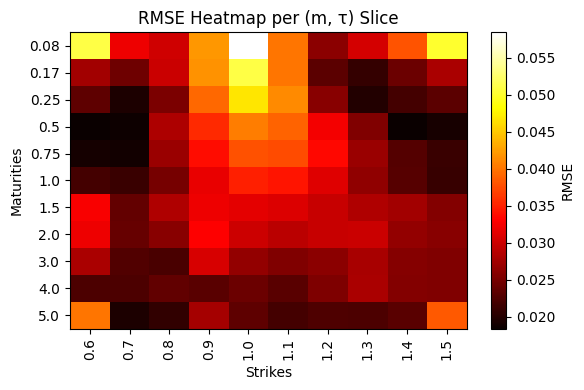

In [36]:
from utils.eval import evaluate_decoder_output

# eval config
Z_eval = Z_decoder
F_eval = F_aligned_np
X_grid_eval = Y_surface_reshaped  # use the already reshaped version

# predict decoded surfaces from cnn
X_pred_raw = np.stack([
   decoder_cnn.predict_surface(z, f)
   for z, f in zip(Z_eval, F_eval)
])  # shape (n, m, k)

# evaluate decoded surfaces
evaluate_decoder_output(
   decoder=decoder_cnn,
   Z_forecast=Z_eval,
   X_grid=X_grid_eval,
   X_true_idx=None,
   tensors=tensors,
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   taus=ops.convert_to_numpy(tensors["taus"]),
   target_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
   decoded_surfaces_override=X_pred_raw,
   title="raw vae-gru (feature-aware cnn decoder)"
)

original y_decoder shape: (1216, 110)
reshaped y_surface: (1216, 11, 10)
zf_decoder shape: (1216, 148)
train shapes: zf=(851, 148), y=(851, 11, 10)
val shapes: zf=(182, 148), y=(182, 11, 10)
Epoch 1/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1883 - val_loss: 0.0625 - learning_rate: 1.0000e-04
Epoch 2/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0213 - val_loss: 0.0056 - learning_rate: 1.0000e-04
Epoch 3/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - val_loss: 0.0089 - learning_rate: 1.0000e-04
Epoch 4/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0070 - learning_rate: 1.0000e-04
Epoch 5/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 0.0067 - learning_rate: 1.0000e-04
Epoch 6/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 0.0061 - learning_rate: 1.0000e-04
Epoch 7/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0060 - learning_rate: 1.0000e-04
Epoch 8/500
27/27 

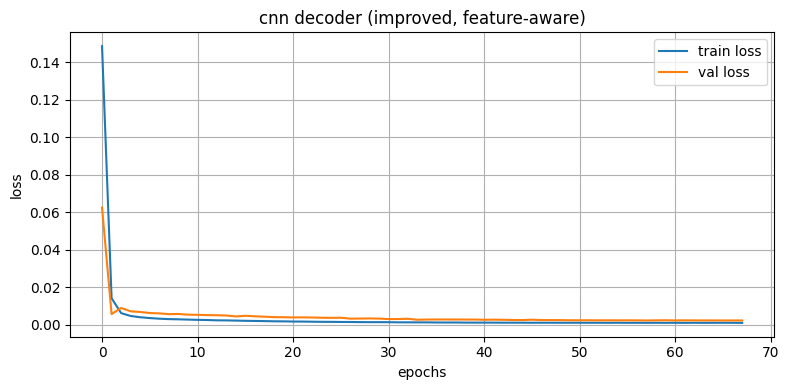

In [37]:
import models.cnn
import importlib
importlib.reload(models.cnn)

from models.cnn import CNNDecoderImproved
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import matplotlib.pyplot as plt

# fix y_decoder shape first
print(f"original y_decoder shape: {Y_decoder.shape}")
if Y_decoder.shape[0] == Z_decoder.shape[0] * M:
   Y_surface_reshaped = Y_decoder.reshape(Z_decoder.shape[0], M, K)
else:
   Y_surface_reshaped = Y_decoder.reshape(-1, M, K)
print(f"reshaped y_surface: {Y_surface_reshaped.shape}")

# prepare feature-aware inputs
F_aligned_np = ops.convert_to_numpy(F_aligned)
ZF_decoder = np.concatenate([Z_decoder, F_aligned_np], axis=-1)
print(f"zf_decoder shape: {ZF_decoder.shape}")

# instantiate improved cnn decoder
decoder_cnn = CNNDecoderImproved(
   latent_dim=LATENT_DIM,
   feature_dim=F_aligned_np.shape[1],
   M=M,
   K=K,
   hidden_dim=512,
   dropout_rate=0.2
)
decoder_cnn.compile(optimizer=Adam(learning_rate=1e-4), loss="mse")

# split data
N_total = len(ZF_decoder)
train_split = int(0.7 * N_total)
val_split = int(0.85 * N_total)

ZF_train = ZF_decoder[:train_split]
ZF_val = ZF_decoder[train_split:val_split]
Y_train = Y_surface_reshaped[:train_split]
Y_val = Y_surface_reshaped[train_split:val_split]

print(f"train shapes: zf={ZF_train.shape}, y={Y_train.shape}")
print(f"val shapes: zf={ZF_val.shape}, y={Y_val.shape}")

# callbacks
os.makedirs("saved_models/cnn_surface_improved", exist_ok=True)
callbacks = [
   EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
   ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5),
   ModelCheckpoint("saved_models/cnn_surface_improved/decoder.keras", save_best_only=True)
]

# fit model
history = decoder_cnn.fit(
   ZF_train, Y_train,
   validation_data=(ZF_val, Y_val),
   batch_size=32,
   epochs=500,
   callbacks=callbacks,
   verbose=1
)

# plot training history
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title("cnn decoder (improved, feature-aware)")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Raw VAE–GRU (CNN Decoder Improved) RMSE_σ: 0.0319
RMSE by maturity (mean ± std): 0.0323 ± 0.0038
RMSE by strike    (mean ± std): 0.0324 ± 0.0034


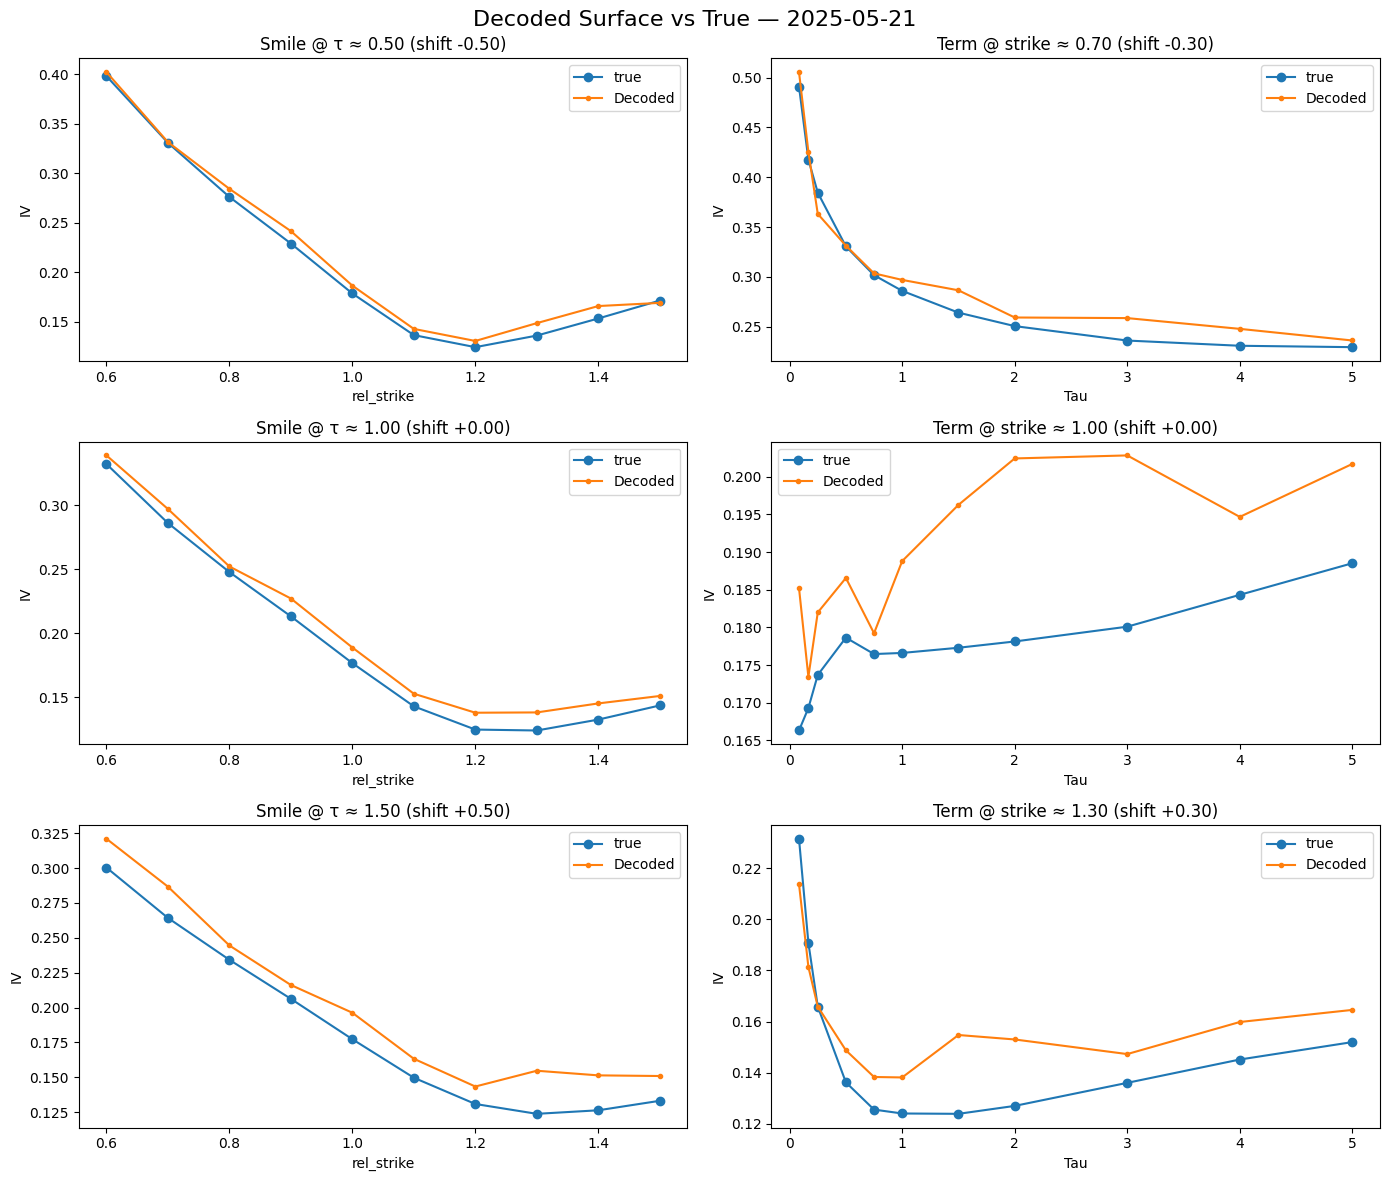

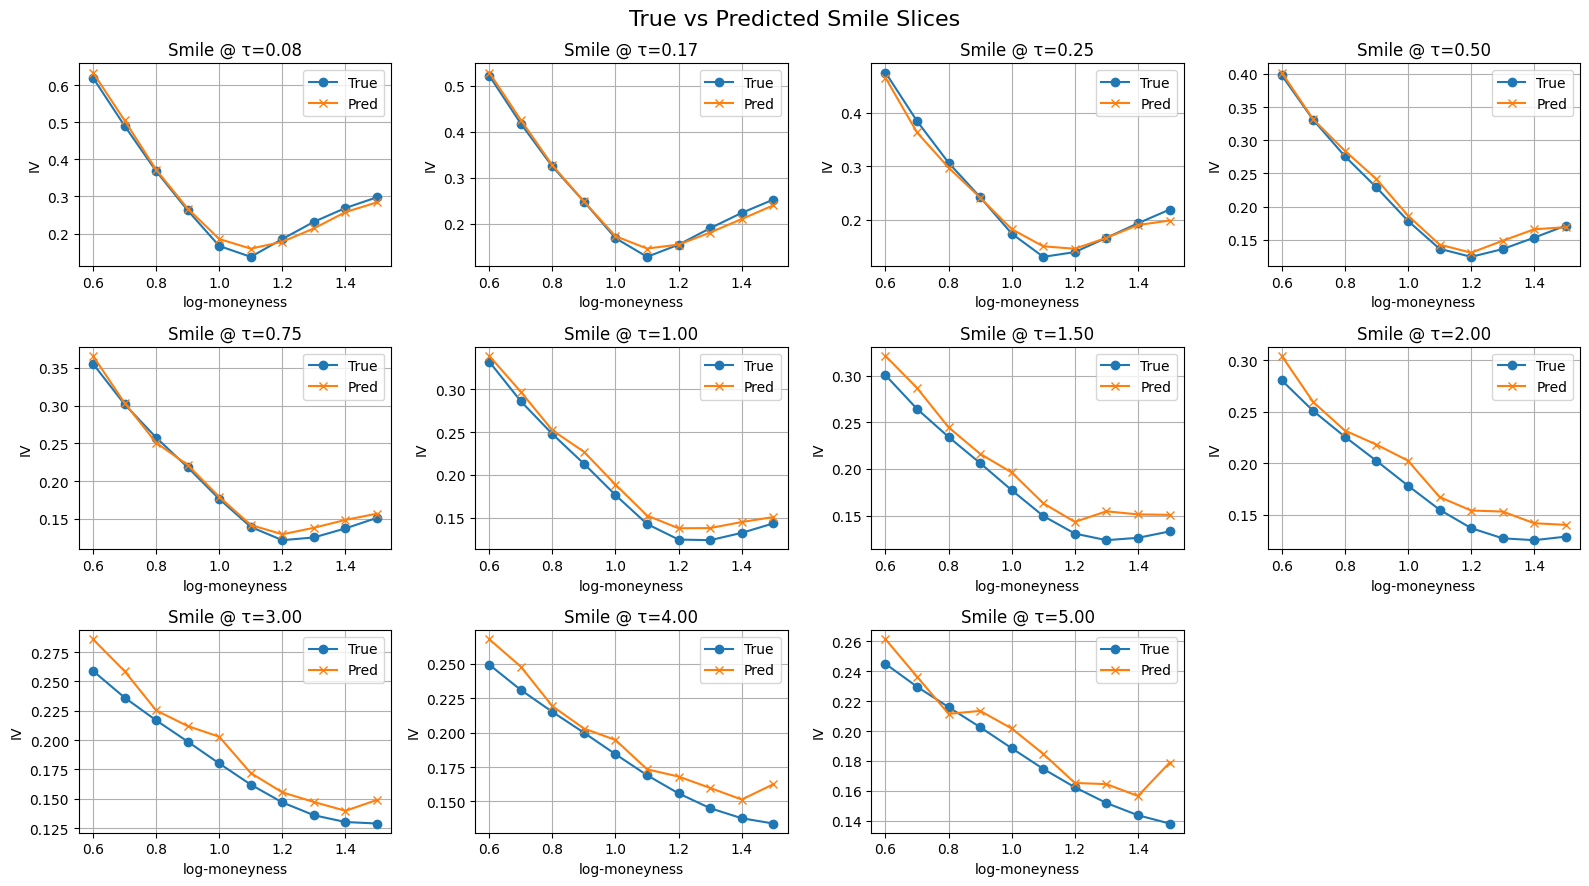

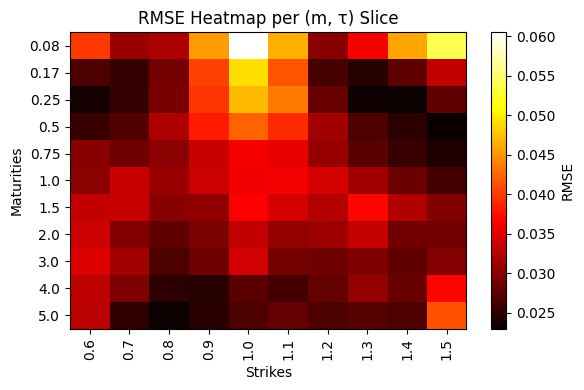

In [38]:
from utils.eval import evaluate_decoder_output

# --- Evaluation inputs
Z_eval = Z_decoder
F_eval = F_aligned
X_grid_eval = Y_decoder.reshape(-1, M, K)

# --- Concatenate z ⊕ f
ZF_eval = np.concatenate([Z_eval, ops.convert_to_numpy(F_eval)], axis=-1)

# --- Predict IV surfaces
X_pred_raw = np.stack([
    decoder_cnn.predict_surface(zf) for zf in ZF_eval
])  # shape (N, M, K)

# --- Evaluate decoded surfaces
evaluate_decoder_output(
    decoder=decoder_cnn,
    Z_forecast=Z_eval,
    X_grid=X_grid_eval,
    X_true_idx=None,
    tensors=tensors,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=ops.convert_to_numpy(tensors["taus"]),
    target_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
    decoded_surfaces_override=X_pred_raw,
    title="Raw VAE–GRU (CNN Decoder Improved)"
)
